In [341]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
#import deep_inference_inference as dii
import glob
np.set_printoptions(precision=3)
# Set styles
sns.set(style = "white")

In [342]:
def run_bayesian_t_tests_single_exp_fcn(experiment = [],
                                        experiment_meta_data = [],
                                        p_val = 0.05,
                                        n_post_samples = 10000):
    
    # Process meta dat
    n_perturb = len(np.unique(experiment_meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(experiment_meta_data.iloc[:, 1])) - 1
    
    
    base_post_estimates = experiment[1][0, :n_params]
    base_post_variances = experiment[1][0, n_params:]
    compare_post_estimates = experiment[1][1:, :n_params]
    compare_post_variances = experiment[1][1:, n_params:]
    
    base_post_samples = np.random.normal(loc = base_post_estimates, 
                                         scale = np.sqrt(base_post_variances), 
                                         size = (n_post_samples, n_params))
    
    #print(experiment[0])
    
    diff_samples = np.zeros((n_perturb * n_params, n_post_samples, n_params))
    p_val_crit_array = (np.zeros((n_perturb * n_params, n_params))).astype(bool)

    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            # Can run this less (--> optimize)
            compare_post_samples = np.random.normal(loc = compare_post_estimates[i], 
                                                    scale = np.sqrt(compare_post_variances[i]),
                                                    size = (n_post_samples, n_params))
            #print(compare_post_samples.shape)
            #print(compare_post_samples[i].shape)
            diff_samples[i] = (base_post_samples - compare_post_samples) 
            tmp_quantiles = np.quantile(diff_samples[i],
                                        q = [(p_val / 2), p_val, 1 - p_val, 1 - (p_val / 2)], 
                                        axis = 0)
            p_val_crit_array[i, :] = (tmp_quantiles[0, :] > 0) + (tmp_quantiles[3, :] < 0)
            
            if (experiment[0][0][param] - experiment[0][i + 1][param]) > 0:
                print('we passed')
                print(experiment[0][0][param])
                p_val_crit_array[i, param] = (tmp_quantiles[1, param] > 0)
            else: 
                p_val_crit_array[i, param] = (tmp_quantiles[2, param] < 0)
            i += 1
    print(p_val_crit_array)
    print('experiment outcomes: ')
    print(experiment[1][:, :])
    return p_val_crit_array


def run_bayesian_t_tests_single_exp(experiment = [0], 
                                    experiment_meta_data = [],
                                    p_val = 0.05):
    
    # Process meta dat
    n_perturb = len(np.unique(experiment_meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(experiment_meta_data.iloc[:, 1])) - 1
    
    
    base_post_samples = experiment[1][0]
    compare_post_samples = experiment[1][1:]
    diff_samples = np.zeros((compare_post_samples.shape))
    
    #print('diff_samples shape: ', diff_samples.shape)
   
    p_val_crit_array = (np.zeros((compare_post_samples.shape[0], n_params))).astype(bool)
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            diff_samples[i] = (base_post_samples - compare_post_samples[i])
            tmp_quantiles = np.quantile(diff_samples[i], q = [(p_val / 2), p_val, 1 - p_val, 1 - (p_val / 2)], axis = 0)
            p_val_crit_array[i, :] = (tmp_quantiles[0, :] > 0) + (tmp_quantiles[3, :] < 0)
            
            if (experiment[0][0][param] - experiment[0][i + 1][param]) > 0:
                p_val_crit_array[i, param] = (tmp_quantiles[1, param] > 0)
            else: 
                p_val_crit_array[i, param] = (tmp_quantiles[2, param] < 0)
            i += 1
    
    return p_val_crit_array
   # return diff_samples, np.array(p_vals), np.array(p_vals_crit), param_perturb_array
    
def get_param_perturb_array(n_params = 0, 
                            n_perturb = 0):
    
    param_perturb_array = np.zeros(((n_params * n_perturb), n_params)).astype(bool)
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            param_perturb_array[i, param] = True
        i += 1
    return param_perturb_array


def get_one_confusion_matrix(p_val_array = 0 ,
                             param_perturb_array = 0,
                             n_params = 0,
                             n_perturb = 0
                            ):
    
    # true_true --> gorundtruth: true, moel_pred: true
    true_true_cnt = np.zeros((n_perturb, n_params))
    false_false_cnt = np.zeros((n_perturb, n_params))
    true_false_cnt = np.zeros((n_perturb, n_params))
    false_true_cnt = np.zeros((n_perturb, n_params))
    
    invert_p_val_array = np.invert(p_val_array)
    invert_perturb_array = np.invert(param_perturb_array)
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            #peram_slice_array = np.bool(np.zeros((p_val_array.shape)))
            spotlight_array = np.zeros((p_val_array.shape[0])).astype(bool)
            spotlight_array[i] = True
            
            true_true_cnt[perturb, param] = np.sum(np.multiply(p_val_array[:, param], spotlight_array))
            true_false_cnt[perturb, param] = 1 - true_true_cnt[perturb, param]
            false_false_cnt[:, param] += np.sum(np.multiply(invert_p_val_array[:, param], invert_perturb_array[:, param]))
            false_true_cnt[:, param] += np.sum(np.multiply(p_val_array[:, param], invert_perturb_array[:, param]))                       
            i += 1
    
    confusion_array = np.zeros((2, 2, n_perturb, n_params))
    confusion_array[0, 0] = false_false_cnt
    confusion_array[0, 1] = false_true_cnt
    confusion_array[1, 0] = true_false_cnt
    confusion_array[1, 1] = true_true_cnt
    return confusion_array
    

def bayesian_t_test_global(file_list = '',
                           meta_data = [0],
                           kind = 'posterior_samples'):
    
    n_files = len(file_list)
    
    n_perturb = len(np.unique(meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(meta_data.iloc[:, 1])) - 1
    
    param_perturb_array = get_param_perturb_array(n_params = n_params,
                                                  n_perturb = n_perturb)
    confusion_matrix_cnts = np.zeros((2, 2, n_perturb, n_params)) 

    if n_files == 0:
        print('Supply files ....')
        return 
    if n_files == 1:
        tmp_dat = pickle.load(open(file_list[0], 'rb'))
        p_vals = run_bayesian_t_tests_single_exp(experiment = tmp_dat[2],
                                                experiment_meta_data = meta_data)
        confusion_matrix_cnts = get_one_confusion_matrix(p_val_array = p_vals, 
                                                         param_perturb_array = param_perturb_array,
                                                         n_params = n_params,
                                                         n_perturb = n_perturb)

    if n_files > 1:
        for file_ in file_list:
            
            # Process file
            tmp_dat = pickle.load(open(file_, 'rb'))
            tmp_dat = [tmp_dat[0], tmp_dat[2]]
#             print(tmp_dat)
#             print(tmp_dat[0].shape)
#             print(tmp_dat[1].shape)
            if kind == 'posterior_samples':
                p_vals = run_bayesian_t_tests_single_exp(experiment = tmp_dat,
                                                         experiment_meta_data = meta_data)
                
            if kind == 'fcn':
                p_vals = run_bayesian_t_tests_single_exp_fcn(experiment = tmp_dat,
                                                             experiment_meta_data = meta_data)
            #print(p_vals)
            confusion_tmp = get_one_confusion_matrix(p_val_array = p_vals,
                                                     param_perturb_array = param_perturb_array,
                                                     n_params = n_params,
                                                     n_perturb = n_perturb)
            
            #print(confusion_tmp)
 
            confusion_matrix_cnts = confusion_matrix_cnts + confusion_tmp
    
    confusion_matrix_cnts[0, :] = confusion_matrix_cnts[0, :] / (confusion_matrix_cnts[0, 0] + confusion_matrix_cnts[0, 1])
    confusion_matrix_cnts[1, :] = confusion_matrix_cnts[1, :] / (confusion_matrix_cnts[1, 0] + confusion_matrix_cnts[1, 1])
    
    return confusion_matrix_cnts

def confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                           title = 'Confusion Matrix',
                           data = [],
                           n_perturb = 3):
    #                       cols = 
    
    cols = len(ax_titles)
    #rows = int(np.ceil(len(ax_titles) / cols))
    rows = n_perturb
    
    sns.set(style = "white", 
            palette = "Greys", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for row in range(rows):
        for col in range(cols):
            colorbar = False
            if col == (cols - 1):
                colorbar = True
            sns.heatmap(data[:, :, row, col], ax = ax[row, col],
                        vmin = 0.0, 
                        vmax = 1.0, 
                        cmap = 'Greys', 
                        cbar = colorbar,
                        annot = True,
                        annot_kws = {'fontsize': 24})

            ax[row, col].set_xlabel('Model', 
                                    fontsize = 24);
            ax[row, col].set_title(ax_titles[col], 
                                    fontsize = 30);
            ax[row, col].tick_params(axis = "x", 
                                     labelsize = 24)
            ax[row, col].tick_params(axis = "y", 
                                     labelsize = 24)
            ax[row, col].set_ylabel('True', 
                                    fontsize = 24);

    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    return plt.show()

In [240]:
out[:, :, 2, 2] #/ (out[0, 0] + out[0, 1])

array([[0.77, 0.23],
       [0.07, 0.93]])

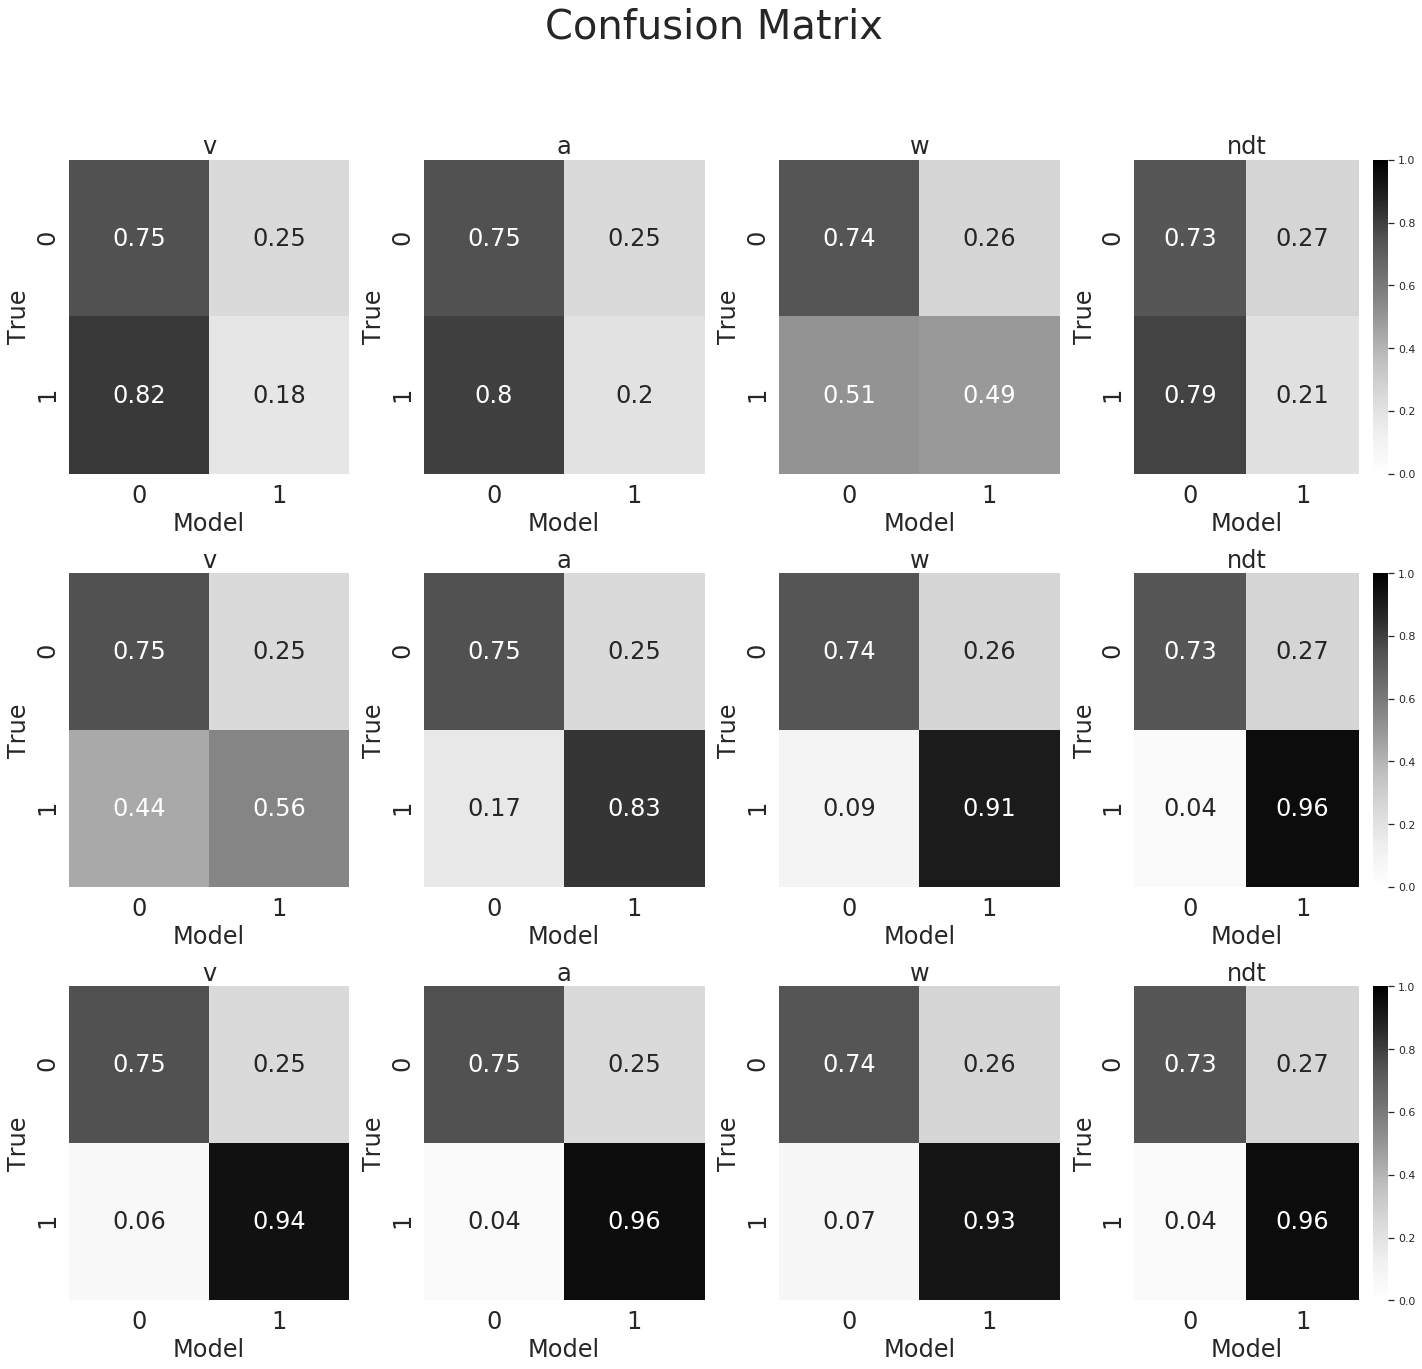

In [244]:
# confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
#                        title = 'Confusion Matrix: N = 100',
#                        data = out[0],
#                        n_perturb = 3)

In [285]:
# Initializations
sample_sizes = [100, 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/kde/ddm/method_comparison/'
file_base_name = file_folder + 'post_samp_perturbation_experiment_nexp_1_n_'
out = []

# Load meta_data file (assumed to be same across all experiment datasets)
meta_data = pickle.load(open(glob.glob(file_folder + 'base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]

# Get detection ratios for all experiments
for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out.append(bayesian_t_test_global(file_list = files_, meta_data = meta_data))

[array([[0.63393466, 0.74967852, 0.50927476, 0.59189311],
       [0.68393466, 0.74967852, 0.50927476, 0.59189311],
       [0.73393466, 0.74967852, 0.50927476, 0.59189311],
       [0.83393466, 0.74967852, 0.50927476, 0.59189311],
       [0.63393466, 0.79967852, 0.50927476, 0.59189311],
       [0.63393466, 0.84967852, 0.50927476, 0.59189311],
       [0.63393466, 0.94967852, 0.50927476, 0.59189311],
       [0.63393466, 0.74967852, 0.55927476, 0.59189311],
       [0.63393466, 0.74967852, 0.60927476, 0.59189311],
       [0.63393466, 0.74967852, 0.70927476, 0.59189311],
       [0.63393466, 0.74967852, 0.50927476, 0.64189311],
       [0.63393466, 0.74967852, 0.50927476, 0.69189311],
       [0.63393466, 0.74967852, 0.50927476, 0.79189311]]), array([[[0.60410156, 0.7261601 , 0.50577137, 0.59900686],
        [0.57206635, 0.71915133, 0.51648542, 0.5959966 ],
        [0.59607593, 0.72342627, 0.49232594, 0.62066794],
        ...,
        [0.51070831, 0.73189878, 0.54043664, 0.61116504],
        [0.

[array([[-1.19401893,  1.08466327,  0.51683693,  0.48976484],
       [-1.14401893,  1.08466327,  0.51683693,  0.48976484],
       [-1.09401893,  1.08466327,  0.51683693,  0.48976484],
       [-0.99401893,  1.08466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.13466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.18466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.28466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.56683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.61683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.71683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.51683693,  0.53976484],
       [-1.19401893,  1.08466327,  0.51683693,  0.58976484],
       [-1.19401893,  1.08466327,  0.51683693,  0.68976484]]), array([[[-1.22141722,  1.0975253 ,  0.50816261,  0.48394934],
        [-1.20881854,  1.10785149,  0.51228216,  0.49519442],
        [-1.2121957 ,  1.08090198,  0.50175462,  0.50100506],
        ...,
     

[array([[-1.21384634,  0.69937762,  0.635356  ,  0.75912854],
       [-1.16384634,  0.69937762,  0.635356  ,  0.75912854],
       [-1.11384634,  0.69937762,  0.635356  ,  0.75912854],
       [-1.01384634,  0.69937762,  0.635356  ,  0.75912854],
       [-1.21384634,  0.74937762,  0.635356  ,  0.75912854],
       [-1.21384634,  0.79937762,  0.635356  ,  0.75912854],
       [-1.21384634,  0.89937762,  0.635356  ,  0.75912854],
       [-1.21384634,  0.69937762,  0.685356  ,  0.75912854],
       [-1.21384634,  0.69937762,  0.735356  ,  0.75912854],
       [-1.21384634,  0.69937762,  0.835356  ,  0.75912854],
       [-1.21384634,  0.69937762,  0.635356  ,  0.80912854],
       [-1.21384634,  0.69937762,  0.635356  ,  0.85912854],
       [-1.21384634,  0.69937762,  0.635356  ,  0.95912854]]), array([[[-1.26023015,  0.73073589,  0.57879958,  0.78920747],
        [-1.29762352,  0.73273308,  0.55948936,  0.78914246],
        [-1.28859074,  0.7380521 ,  0.61969306,  0.77958824],
        ...,
     

[array([[1.20318793, 1.3191468 , 0.62020129, 0.73133127],
       [1.25318793, 1.3191468 , 0.62020129, 0.73133127],
       [1.30318793, 1.3191468 , 0.62020129, 0.73133127],
       [1.40318793, 1.3191468 , 0.62020129, 0.73133127],
       [1.20318793, 1.3691468 , 0.62020129, 0.73133127],
       [1.20318793, 1.4191468 , 0.62020129, 0.73133127],
       [1.20318793, 1.5191468 , 0.62020129, 0.73133127],
       [1.20318793, 1.3191468 , 0.67020129, 0.73133127],
       [1.20318793, 1.3191468 , 0.72020129, 0.73133127],
       [1.20318793, 1.3191468 , 0.82020129, 0.73133127],
       [1.20318793, 1.3191468 , 0.62020129, 0.78133127],
       [1.20318793, 1.3191468 , 0.62020129, 0.83133127],
       [1.20318793, 1.3191468 , 0.62020129, 0.93133127]]), array([[[1.20040052, 1.36449708, 0.61140356, 0.74471806],
        [1.21294271, 1.37291274, 0.6284138 , 0.76310161],
        [1.20625544, 1.34050788, 0.5956115 , 0.77312537],
        ...,
        [1.14445144, 1.36987226, 0.67932811, 0.83256105],
        [1.

[array([[-0.46693868,  0.89030187,  0.41734138,  0.64641066],
       [-0.41693868,  0.89030187,  0.41734138,  0.64641066],
       [-0.36693868,  0.89030187,  0.41734138,  0.64641066],
       [-0.26693868,  0.89030187,  0.41734138,  0.64641066],
       [-0.46693868,  0.94030187,  0.41734138,  0.64641066],
       [-0.46693868,  0.99030187,  0.41734138,  0.64641066],
       [-0.46693868,  1.09030187,  0.41734138,  0.64641066],
       [-0.46693868,  0.89030187,  0.46734138,  0.64641066],
       [-0.46693868,  0.89030187,  0.51734138,  0.64641066],
       [-0.46693868,  0.89030187,  0.61734138,  0.64641066],
       [-0.46693868,  0.89030187,  0.41734138,  0.69641066],
       [-0.46693868,  0.89030187,  0.41734138,  0.74641066],
       [-0.46693868,  0.89030187,  0.41734138,  0.84641066]]), array([[[-0.46570231,  0.87236904,  0.39965934,  0.65690223],
        [-0.48150077,  0.87968214,  0.39449538,  0.6767807 ],
        [-0.48035249,  0.84522519,  0.39284887,  0.67597073],
        ...,
     

[array([[-1.41672151,  1.18591649,  0.370568  ,  0.20176202],
       [-1.36672151,  1.18591649,  0.370568  ,  0.20176202],
       [-1.31672151,  1.18591649,  0.370568  ,  0.20176202],
       [-1.21672151,  1.18591649,  0.370568  ,  0.20176202],
       [-1.41672151,  1.23591649,  0.370568  ,  0.20176202],
       [-1.41672151,  1.28591649,  0.370568  ,  0.20176202],
       [-1.41672151,  1.38591649,  0.370568  ,  0.20176202],
       [-1.41672151,  1.18591649,  0.420568  ,  0.20176202],
       [-1.41672151,  1.18591649,  0.470568  ,  0.20176202],
       [-1.41672151,  1.18591649,  0.570568  ,  0.20176202],
       [-1.41672151,  1.18591649,  0.370568  ,  0.25176202],
       [-1.41672151,  1.18591649,  0.370568  ,  0.30176202],
       [-1.41672151,  1.18591649,  0.370568  ,  0.40176202]]), array([[[-1.42343294,  1.18878287,  0.37074025,  0.2008992 ],
        [-1.44515914,  1.18360911,  0.37049821,  0.20470671],
        [-1.45889819,  1.19156956,  0.36780446,  0.20210212],
        ...,
     

[array([[1.09109536, 1.02248876, 0.48023259, 0.67192578],
       [1.14109536, 1.02248876, 0.48023259, 0.67192578],
       [1.19109536, 1.02248876, 0.48023259, 0.67192578],
       [1.29109536, 1.02248876, 0.48023259, 0.67192578],
       [1.09109536, 1.07248876, 0.48023259, 0.67192578],
       [1.09109536, 1.12248876, 0.48023259, 0.67192578],
       [1.09109536, 1.22248876, 0.48023259, 0.67192578],
       [1.09109536, 1.02248876, 0.53023259, 0.67192578],
       [1.09109536, 1.02248876, 0.58023259, 0.67192578],
       [1.09109536, 1.02248876, 0.68023259, 0.67192578],
       [1.09109536, 1.02248876, 0.48023259, 0.72192578],
       [1.09109536, 1.02248876, 0.48023259, 0.77192578],
       [1.09109536, 1.02248876, 0.48023259, 0.87192578]]), array([[[1.07181766, 1.07746178, 0.47905716, 0.66884331],
        [1.13824073, 1.05630067, 0.48335321, 0.65998671],
        [1.13469944, 1.05933985, 0.46876417, 0.68247258],
        ...,
        [1.01385125, 1.01709851, 0.5341599 , 0.70693024],
        [1.

[array([[0.66568085, 1.36145954, 0.32817287, 0.49674715],
       [0.71568085, 1.36145954, 0.32817287, 0.49674715],
       [0.76568085, 1.36145954, 0.32817287, 0.49674715],
       [0.86568085, 1.36145954, 0.32817287, 0.49674715],
       [0.66568085, 1.41145954, 0.32817287, 0.49674715],
       [0.66568085, 1.46145954, 0.32817287, 0.49674715],
       [0.66568085, 1.56145954, 0.32817287, 0.49674715],
       [0.66568085, 1.36145954, 0.37817287, 0.49674715],
       [0.66568085, 1.36145954, 0.42817287, 0.49674715],
       [0.66568085, 1.36145954, 0.52817287, 0.49674715],
       [0.66568085, 1.36145954, 0.32817287, 0.54674715],
       [0.66568085, 1.36145954, 0.32817287, 0.59674715],
       [0.66568085, 1.36145954, 0.32817287, 0.69674715]]), array([[[0.65254703, 1.33199863, 0.32820274, 0.49890797],
        [0.67502985, 1.35888689, 0.32037474, 0.46325679],
        [0.66834289, 1.35973146, 0.33230764, 0.48663175],
        ...,
        [0.54315935, 1.39482201, 0.32151179, 0.57294926],
        [0.

[array([[0.59261681, 0.83288767, 0.36107092, 0.7816566 ],
       [0.64261681, 0.83288767, 0.36107092, 0.7816566 ],
       [0.69261681, 0.83288767, 0.36107092, 0.7816566 ],
       [0.79261681, 0.83288767, 0.36107092, 0.7816566 ],
       [0.59261681, 0.88288767, 0.36107092, 0.7816566 ],
       [0.59261681, 0.93288767, 0.36107092, 0.7816566 ],
       [0.59261681, 1.03288767, 0.36107092, 0.7816566 ],
       [0.59261681, 0.83288767, 0.41107092, 0.7816566 ],
       [0.59261681, 0.83288767, 0.46107092, 0.7816566 ],
       [0.59261681, 0.83288767, 0.56107092, 0.7816566 ],
       [0.59261681, 0.83288767, 0.36107092, 0.8316566 ],
       [0.59261681, 0.83288767, 0.36107092, 0.8816566 ],
       [0.59261681, 0.83288767, 0.36107092, 0.9816566 ]]), array([[[0.63991693, 0.83256232, 0.33917022, 0.83437912],
        [0.6172407 , 0.78979055, 0.33014602, 0.82191459],
        [0.61424354, 0.84430893, 0.3370203 , 0.82244126],
        ...,
        [0.56310993, 0.80505277, 0.31304334, 0.8196296 ],
        [0.

[array([[0.63015171, 1.18196877, 0.53436426, 0.38713145],
       [0.68015171, 1.18196877, 0.53436426, 0.38713145],
       [0.73015171, 1.18196877, 0.53436426, 0.38713145],
       [0.83015171, 1.18196877, 0.53436426, 0.38713145],
       [0.63015171, 1.23196877, 0.53436426, 0.38713145],
       [0.63015171, 1.28196877, 0.53436426, 0.38713145],
       [0.63015171, 1.38196877, 0.53436426, 0.38713145],
       [0.63015171, 1.18196877, 0.58436426, 0.38713145],
       [0.63015171, 1.18196877, 0.63436426, 0.38713145],
       [0.63015171, 1.18196877, 0.73436426, 0.38713145],
       [0.63015171, 1.18196877, 0.53436426, 0.43713145],
       [0.63015171, 1.18196877, 0.53436426, 0.48713145],
       [0.63015171, 1.18196877, 0.53436426, 0.58713145]]), array([[[0.62596591, 1.17657071, 0.53102391, 0.41727779],
        [0.62571952, 1.15514449, 0.52933908, 0.41166419],
        [0.62447428, 1.14270915, 0.52911215, 0.41241483],
        ...,
        [0.50191923, 1.16248433, 0.56856407, 0.41451191],
        [0.

[array([[1.24376057, 1.04320333, 0.31413505, 0.25418502],
       [1.29376057, 1.04320333, 0.31413505, 0.25418502],
       [1.34376057, 1.04320333, 0.31413505, 0.25418502],
       [1.44376057, 1.04320333, 0.31413505, 0.25418502],
       [1.24376057, 1.09320333, 0.31413505, 0.25418502],
       [1.24376057, 1.14320333, 0.31413505, 0.25418502],
       [1.24376057, 1.24320333, 0.31413505, 0.25418502],
       [1.24376057, 1.04320333, 0.36413505, 0.25418502],
       [1.24376057, 1.04320333, 0.41413505, 0.25418502],
       [1.24376057, 1.04320333, 0.51413505, 0.25418502],
       [1.24376057, 1.04320333, 0.31413505, 0.30418502],
       [1.24376057, 1.04320333, 0.31413505, 0.35418502],
       [1.24376057, 1.04320333, 0.31413505, 0.45418502]]), array([[[1.25087731, 1.04280374, 0.31055854, 0.29658027],
        [1.18429768, 1.0205859 , 0.31232487, 0.29661587],
        [1.13006464, 1.03005949, 0.31127094, 0.30108495],
        ...,
        [1.10026502, 1.10584163, 0.31669022, 0.2497652 ],
        [1.

[array([[1.76633148, 0.61177349, 0.47383612, 0.70759797],
       [1.81633148, 0.61177349, 0.47383612, 0.70759797],
       [1.86633148, 0.61177349, 0.47383612, 0.70759797],
       [1.96633148, 0.61177349, 0.47383612, 0.70759797],
       [1.76633148, 0.66177349, 0.47383612, 0.70759797],
       [1.76633148, 0.71177349, 0.47383612, 0.70759797],
       [1.76633148, 0.81177349, 0.47383612, 0.70759797],
       [1.76633148, 0.61177349, 0.52383612, 0.70759797],
       [1.76633148, 0.61177349, 0.57383612, 0.70759797],
       [1.76633148, 0.61177349, 0.67383612, 0.70759797],
       [1.76633148, 0.61177349, 0.47383612, 0.75759797],
       [1.76633148, 0.61177349, 0.47383612, 0.80759797],
       [1.76633148, 0.61177349, 0.47383612, 0.90759797]]), array([[[1.80592242, 0.64219488, 0.47382928, 0.71184239],
        [1.73885719, 0.64749948, 0.47362069, 0.71212904],
        [1.7533887 , 0.64321636, 0.46955769, 0.69093001],
        ...,
        [1.85656948, 0.63531671, 0.47867415, 0.70147304],
        [1.

[array([[-1.51812762,  0.9035607 ,  0.34569254,  0.60488139],
       [-1.46812762,  0.9035607 ,  0.34569254,  0.60488139],
       [-1.41812762,  0.9035607 ,  0.34569254,  0.60488139],
       [-1.31812762,  0.9035607 ,  0.34569254,  0.60488139],
       [-1.51812762,  0.9535607 ,  0.34569254,  0.60488139],
       [-1.51812762,  1.0035607 ,  0.34569254,  0.60488139],
       [-1.51812762,  1.1035607 ,  0.34569254,  0.60488139],
       [-1.51812762,  0.9035607 ,  0.39569254,  0.60488139],
       [-1.51812762,  0.9035607 ,  0.44569254,  0.60488139],
       [-1.51812762,  0.9035607 ,  0.54569254,  0.60488139],
       [-1.51812762,  0.9035607 ,  0.34569254,  0.65488139],
       [-1.51812762,  0.9035607 ,  0.34569254,  0.70488139],
       [-1.51812762,  0.9035607 ,  0.34569254,  0.80488139]]), array([[[-1.5752919 ,  0.92398947,  0.35148081,  0.61386067],
        [-1.56803294,  0.89343454,  0.33680511,  0.60955089],
        [-1.60928794,  0.93184415,  0.33011218,  0.62230171],
        ...,
     

[array([[-0.26788883,  0.84001314,  0.32320749,  0.20427593],
       [-0.21788883,  0.84001314,  0.32320749,  0.20427593],
       [-0.16788883,  0.84001314,  0.32320749,  0.20427593],
       [-0.06788883,  0.84001314,  0.32320749,  0.20427593],
       [-0.26788883,  0.89001314,  0.32320749,  0.20427593],
       [-0.26788883,  0.94001314,  0.32320749,  0.20427593],
       [-0.26788883,  1.04001314,  0.32320749,  0.20427593],
       [-0.26788883,  0.84001314,  0.37320749,  0.20427593],
       [-0.26788883,  0.84001314,  0.42320749,  0.20427593],
       [-0.26788883,  0.84001314,  0.52320749,  0.20427593],
       [-0.26788883,  0.84001314,  0.32320749,  0.25427593],
       [-0.26788883,  0.84001314,  0.32320749,  0.30427593],
       [-0.26788883,  0.84001314,  0.32320749,  0.40427593]]), array([[[-0.23977113,  0.90937754,  0.33238413,  0.21544273],
        [-0.2688241 ,  0.90293381,  0.32347968,  0.19517898],
        [-0.24766152,  0.9161172 ,  0.32203843,  0.19653957],
        ...,
     

[array([[1.41680576, 1.3337949 , 0.40364022, 0.77211035],
       [1.46680576, 1.3337949 , 0.40364022, 0.77211035],
       [1.51680576, 1.3337949 , 0.40364022, 0.77211035],
       [1.61680576, 1.3337949 , 0.40364022, 0.77211035],
       [1.41680576, 1.3837949 , 0.40364022, 0.77211035],
       [1.41680576, 1.4337949 , 0.40364022, 0.77211035],
       [1.41680576, 1.5337949 , 0.40364022, 0.77211035],
       [1.41680576, 1.3337949 , 0.45364022, 0.77211035],
       [1.41680576, 1.3337949 , 0.50364022, 0.77211035],
       [1.41680576, 1.3337949 , 0.60364022, 0.77211035],
       [1.41680576, 1.3337949 , 0.40364022, 0.82211035],
       [1.41680576, 1.3337949 , 0.40364022, 0.87211035],
       [1.41680576, 1.3337949 , 0.40364022, 0.97211035]]), array([[[1.43838611, 1.35485868, 0.4089371 , 0.78168395],
        [1.43988759, 1.38915698, 0.39227391, 0.83823417],
        [1.44203418, 1.38976344, 0.4423472 , 0.79143563],
        ...,
        [1.38872495, 1.34229417, 0.40328083, 0.8285239 ],
        [1.

[array([[-1.89935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.84935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.79935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.69935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.33697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.38697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.48697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.60491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.65491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.75491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.55491001,  0.27436487],
       [-1.89935227,  1.28697786,  0.55491001,  0.32436487],
       [-1.89935227,  1.28697786,  0.55491001,  0.42436487]]), array([[[-1.88731185,  1.22984654,  0.56509458,  0.22435517],
        [-1.8863603 ,  1.23564337,  0.56482042,  0.23459157],
        [-1.87306802,  1.24003481,  0.56168354,  0.24508796],
        ...,
     

[array([[0.65313841, 0.92072361, 0.32136865, 0.78629567],
       [0.70313841, 0.92072361, 0.32136865, 0.78629567],
       [0.75313841, 0.92072361, 0.32136865, 0.78629567],
       [0.85313841, 0.92072361, 0.32136865, 0.78629567],
       [0.65313841, 0.97072361, 0.32136865, 0.78629567],
       [0.65313841, 1.02072361, 0.32136865, 0.78629567],
       [0.65313841, 1.12072361, 0.32136865, 0.78629567],
       [0.65313841, 0.92072361, 0.37136865, 0.78629567],
       [0.65313841, 0.92072361, 0.42136865, 0.78629567],
       [0.65313841, 0.92072361, 0.52136865, 0.78629567],
       [0.65313841, 0.92072361, 0.32136865, 0.83629567],
       [0.65313841, 0.92072361, 0.32136865, 0.88629567],
       [0.65313841, 0.92072361, 0.32136865, 0.98629567]]), array([[[0.66643223, 0.92898833, 0.31879497, 0.78591753],
        [0.66828761, 0.93631157, 0.31821442, 0.81154744],
        [0.65847655, 0.93381943, 0.31699189, 0.80629441],
        ...,
        [0.63332353, 0.91949446, 0.33212642, 0.80917397],
        [0.

[array([[-0.39814158,  0.8255507 ,  0.45176162,  0.17826085],
       [-0.34814158,  0.8255507 ,  0.45176162,  0.17826085],
       [-0.29814158,  0.8255507 ,  0.45176162,  0.17826085],
       [-0.19814158,  0.8255507 ,  0.45176162,  0.17826085],
       [-0.39814158,  0.8755507 ,  0.45176162,  0.17826085],
       [-0.39814158,  0.9255507 ,  0.45176162,  0.17826085],
       [-0.39814158,  1.0255507 ,  0.45176162,  0.17826085],
       [-0.39814158,  0.8255507 ,  0.50176162,  0.17826085],
       [-0.39814158,  0.8255507 ,  0.55176162,  0.17826085],
       [-0.39814158,  0.8255507 ,  0.65176162,  0.17826085],
       [-0.39814158,  0.8255507 ,  0.45176162,  0.22826085],
       [-0.39814158,  0.8255507 ,  0.45176162,  0.27826085],
       [-0.39814158,  0.8255507 ,  0.45176162,  0.37826085]]), array([[[-0.41785638,  0.82447614,  0.43216552,  0.1855225 ],
        [-0.45530588,  0.82136981,  0.44607988,  0.18190215],
        [-0.44106449,  0.80632754,  0.45534449,  0.17724978],
        ...,
     

[array([[1.45650011, 0.96477809, 0.45223086, 0.56840502],
       [1.50650011, 0.96477809, 0.45223086, 0.56840502],
       [1.55650011, 0.96477809, 0.45223086, 0.56840502],
       [1.65650011, 0.96477809, 0.45223086, 0.56840502],
       [1.45650011, 1.01477809, 0.45223086, 0.56840502],
       [1.45650011, 1.06477809, 0.45223086, 0.56840502],
       [1.45650011, 1.16477809, 0.45223086, 0.56840502],
       [1.45650011, 0.96477809, 0.50223086, 0.56840502],
       [1.45650011, 0.96477809, 0.55223086, 0.56840502],
       [1.45650011, 0.96477809, 0.65223086, 0.56840502],
       [1.45650011, 0.96477809, 0.45223086, 0.61840502],
       [1.45650011, 0.96477809, 0.45223086, 0.66840502],
       [1.45650011, 0.96477809, 0.45223086, 0.76840502]]), array([[[1.41816459, 1.0109121 , 0.44018346, 0.56099327],
        [1.44444589, 1.02157663, 0.367912  , 0.56100247],
        [1.5108547 , 1.00450994, 0.36800159, 0.5484919 ],
        ...,
        [1.68433625, 0.96401734, 0.36129565, 0.56989627],
        [1.

[array([[-0.63914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.58914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.53914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.43914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.13581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.18581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.28581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.42096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.47096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.57096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.37096693,  0.28806506],
       [-0.63914378,  1.08581187,  0.37096693,  0.33806506],
       [-0.63914378,  1.08581187,  0.37096693,  0.43806506]]), array([[[-0.6448619 ,  1.0936328 ,  0.37101014,  0.24100749],
        [-0.6850734 ,  1.0565669 ,  0.37589991,  0.24454235],
        [-0.62906689,  1.07401936,  0.37575645,  0.24763511],
        ...,
     

[array([[0.9932625 , 1.34851103, 0.41812859, 0.3948148 ],
       [1.0432625 , 1.34851103, 0.41812859, 0.3948148 ],
       [1.0932625 , 1.34851103, 0.41812859, 0.3948148 ],
       [1.1932625 , 1.34851103, 0.41812859, 0.3948148 ],
       [0.9932625 , 1.39851103, 0.41812859, 0.3948148 ],
       [0.9932625 , 1.44851103, 0.41812859, 0.3948148 ],
       [0.9932625 , 1.54851103, 0.41812859, 0.3948148 ],
       [0.9932625 , 1.34851103, 0.46812859, 0.3948148 ],
       [0.9932625 , 1.34851103, 0.51812859, 0.3948148 ],
       [0.9932625 , 1.34851103, 0.61812859, 0.3948148 ],
       [0.9932625 , 1.34851103, 0.41812859, 0.4448148 ],
       [0.9932625 , 1.34851103, 0.41812859, 0.4948148 ],
       [0.9932625 , 1.34851103, 0.41812859, 0.5948148 ]]), array([[[1.03116638, 1.38201885, 0.41839255, 0.3949125 ],
        [0.99027282, 1.38308785, 0.41987565, 0.39780878],
        [0.98032926, 1.36308668, 0.42841681, 0.38260157],
        ...,
        [0.87020722, 1.34601184, 0.44617535, 0.41016803],
        [0.

[array([[0.38636557, 0.72231311, 0.49484934, 0.64206932],
       [0.43636557, 0.72231311, 0.49484934, 0.64206932],
       [0.48636557, 0.72231311, 0.49484934, 0.64206932],
       [0.58636557, 0.72231311, 0.49484934, 0.64206932],
       [0.38636557, 0.77231311, 0.49484934, 0.64206932],
       [0.38636557, 0.82231311, 0.49484934, 0.64206932],
       [0.38636557, 0.92231311, 0.49484934, 0.64206932],
       [0.38636557, 0.72231311, 0.54484934, 0.64206932],
       [0.38636557, 0.72231311, 0.59484934, 0.64206932],
       [0.38636557, 0.72231311, 0.69484934, 0.64206932],
       [0.38636557, 0.72231311, 0.49484934, 0.69206932],
       [0.38636557, 0.72231311, 0.49484934, 0.74206932],
       [0.38636557, 0.72231311, 0.49484934, 0.84206932]]), array([[[0.36703809, 0.72329133, 0.47904463, 0.65810152],
        [0.38567635, 0.72608964, 0.48219509, 0.67134108],
        [0.33293367, 0.71887773, 0.49024741, 0.66534583],
        ...,
        [0.37381238, 0.71963216, 0.48954792, 0.67433897],
        [0.

[array([[-1.15278846,  1.33288623,  0.35805599,  0.45156957],
       [-1.10278846,  1.33288623,  0.35805599,  0.45156957],
       [-1.05278846,  1.33288623,  0.35805599,  0.45156957],
       [-0.95278846,  1.33288623,  0.35805599,  0.45156957],
       [-1.15278846,  1.38288623,  0.35805599,  0.45156957],
       [-1.15278846,  1.43288623,  0.35805599,  0.45156957],
       [-1.15278846,  1.53288623,  0.35805599,  0.45156957],
       [-1.15278846,  1.33288623,  0.40805599,  0.45156957],
       [-1.15278846,  1.33288623,  0.45805599,  0.45156957],
       [-1.15278846,  1.33288623,  0.55805599,  0.45156957],
       [-1.15278846,  1.33288623,  0.35805599,  0.50156957],
       [-1.15278846,  1.33288623,  0.35805599,  0.55156957],
       [-1.15278846,  1.33288623,  0.35805599,  0.65156957]]), array([[[-1.10718017,  1.3321993 ,  0.37355386,  0.45147342],
        [-1.12647246,  1.31785874,  0.37962401,  0.45763012],
        [-1.03493401,  1.31870691,  0.37976949,  0.45771932],
        ...,
     

[array([[0.84239906, 1.2600257 , 0.36348901, 0.51628025],
       [0.89239906, 1.2600257 , 0.36348901, 0.51628025],
       [0.94239906, 1.2600257 , 0.36348901, 0.51628025],
       [1.04239906, 1.2600257 , 0.36348901, 0.51628025],
       [0.84239906, 1.3100257 , 0.36348901, 0.51628025],
       [0.84239906, 1.3600257 , 0.36348901, 0.51628025],
       [0.84239906, 1.4600257 , 0.36348901, 0.51628025],
       [0.84239906, 1.2600257 , 0.41348901, 0.51628025],
       [0.84239906, 1.2600257 , 0.46348901, 0.51628025],
       [0.84239906, 1.2600257 , 0.56348901, 0.51628025],
       [0.84239906, 1.2600257 , 0.36348901, 0.56628025],
       [0.84239906, 1.2600257 , 0.36348901, 0.61628025],
       [0.84239906, 1.2600257 , 0.36348901, 0.71628025]]), array([[[0.81689162, 1.28947689, 0.33496423, 0.55714777],
        [0.76991712, 1.32006257, 0.32585233, 0.55713253],
        [0.74712537, 1.25758871, 0.31018139, 0.53169295],
        ...,
        [0.6647482 , 1.22391465, 0.36778239, 0.58734729],
        [0.

[array([[-0.9190947 ,  0.62007603,  0.50262207,  0.14095142],
       [-0.8690947 ,  0.62007603,  0.50262207,  0.14095142],
       [-0.8190947 ,  0.62007603,  0.50262207,  0.14095142],
       [-0.7190947 ,  0.62007603,  0.50262207,  0.14095142],
       [-0.9190947 ,  0.67007603,  0.50262207,  0.14095142],
       [-0.9190947 ,  0.72007603,  0.50262207,  0.14095142],
       [-0.9190947 ,  0.82007603,  0.50262207,  0.14095142],
       [-0.9190947 ,  0.62007603,  0.55262207,  0.14095142],
       [-0.9190947 ,  0.62007603,  0.60262207,  0.14095142],
       [-0.9190947 ,  0.62007603,  0.70262207,  0.14095142],
       [-0.9190947 ,  0.62007603,  0.50262207,  0.19095142],
       [-0.9190947 ,  0.62007603,  0.50262207,  0.24095142],
       [-0.9190947 ,  0.62007603,  0.50262207,  0.34095142]]), array([[[-0.93533707,  0.6527253 ,  0.49871289,  0.14213789],
        [-0.89186761,  0.62862271,  0.49513877,  0.14040744],
        [-0.88356776,  0.64168361,  0.49663753,  0.14956866],
        ...,
     

[array([[0.75317918, 0.91428525, 0.60325632, 0.27026067],
       [0.80317918, 0.91428525, 0.60325632, 0.27026067],
       [0.85317918, 0.91428525, 0.60325632, 0.27026067],
       [0.95317918, 0.91428525, 0.60325632, 0.27026067],
       [0.75317918, 0.96428525, 0.60325632, 0.27026067],
       [0.75317918, 1.01428525, 0.60325632, 0.27026067],
       [0.75317918, 1.11428525, 0.60325632, 0.27026067],
       [0.75317918, 0.91428525, 0.65325632, 0.27026067],
       [0.75317918, 0.91428525, 0.70325632, 0.27026067],
       [0.75317918, 0.91428525, 0.80325632, 0.27026067],
       [0.75317918, 0.91428525, 0.60325632, 0.32026067],
       [0.75317918, 0.91428525, 0.60325632, 0.37026067],
       [0.75317918, 0.91428525, 0.60325632, 0.47026067]]), array([[[0.80218674, 0.94622412, 0.60297547, 0.27436484],
        [0.71251296, 0.94407507, 0.58933154, 0.27347526],
        [0.75861518, 0.9379321 , 0.60937029, 0.27533665],
        ...,
        [0.75834512, 0.9045275 , 0.6137369 , 0.28865381],
        [0.

[array([[0.87467197, 1.3894295 , 0.51196683, 0.79798104],
       [0.92467197, 1.3894295 , 0.51196683, 0.79798104],
       [0.97467197, 1.3894295 , 0.51196683, 0.79798104],
       [1.07467197, 1.3894295 , 0.51196683, 0.79798104],
       [0.87467197, 1.4394295 , 0.51196683, 0.79798104],
       [0.87467197, 1.4894295 , 0.51196683, 0.79798104],
       [0.87467197, 1.5894295 , 0.51196683, 0.79798104],
       [0.87467197, 1.3894295 , 0.56196683, 0.79798104],
       [0.87467197, 1.3894295 , 0.61196683, 0.79798104],
       [0.87467197, 1.3894295 , 0.71196683, 0.79798104],
       [0.87467197, 1.3894295 , 0.51196683, 0.84798104],
       [0.87467197, 1.3894295 , 0.51196683, 0.89798104],
       [0.87467197, 1.3894295 , 0.51196683, 0.99798104]]), array([[[0.86570074, 1.39752075, 0.46423171, 0.85705412],
        [0.88423909, 1.39770829, 0.46577013, 0.83944695],
        [0.82148439, 1.37651621, 0.48656062, 0.821534  ],
        ...,
        [0.72160037, 1.27500265, 0.49693999, 0.89938713],
        [0.

[array([[-1.12282318,  1.3304753 ,  0.68257842,  0.21654013],
       [-1.07282318,  1.3304753 ,  0.68257842,  0.21654013],
       [-1.02282318,  1.3304753 ,  0.68257842,  0.21654013],
       [-0.92282318,  1.3304753 ,  0.68257842,  0.21654013],
       [-1.12282318,  1.3804753 ,  0.68257842,  0.21654013],
       [-1.12282318,  1.4304753 ,  0.68257842,  0.21654013],
       [-1.12282318,  1.5304753 ,  0.68257842,  0.21654013],
       [-1.12282318,  1.3304753 ,  0.73257842,  0.21654013],
       [-1.12282318,  1.3304753 ,  0.78257842,  0.21654013],
       [-1.12282318,  1.3304753 ,  0.88257842,  0.21654013],
       [-1.12282318,  1.3304753 ,  0.68257842,  0.26654013],
       [-1.12282318,  1.3304753 ,  0.68257842,  0.31654013],
       [-1.12282318,  1.3304753 ,  0.68257842,  0.41654013]]), array([[[-1.13970563,  1.32093845,  0.68816287,  0.21486716],
        [-1.13931747,  1.26026024,  0.67481074,  0.21476836],
        [-1.13610709,  1.28016559,  0.68998612,  0.23333895],
        ...,
     

[array([[0.59158891, 1.16697052, 0.35124986, 0.33192162],
       [0.64158891, 1.16697052, 0.35124986, 0.33192162],
       [0.69158891, 1.16697052, 0.35124986, 0.33192162],
       [0.79158891, 1.16697052, 0.35124986, 0.33192162],
       [0.59158891, 1.21697052, 0.35124986, 0.33192162],
       [0.59158891, 1.26697052, 0.35124986, 0.33192162],
       [0.59158891, 1.36697052, 0.35124986, 0.33192162],
       [0.59158891, 1.16697052, 0.40124986, 0.33192162],
       [0.59158891, 1.16697052, 0.45124986, 0.33192162],
       [0.59158891, 1.16697052, 0.55124986, 0.33192162],
       [0.59158891, 1.16697052, 0.35124986, 0.38192162],
       [0.59158891, 1.16697052, 0.35124986, 0.43192162],
       [0.59158891, 1.16697052, 0.35124986, 0.53192162]]), array([[[0.58221819, 1.21030309, 0.3645732 , 0.31794638],
        [0.50330845, 1.27480273, 0.34295642, 0.32489196],
        [0.54149586, 1.24848332, 0.34261049, 0.33238977],
        ...,
        [0.61663763, 1.16763418, 0.31558914, 0.40529401],
        [0.

[array([[-1.02277967,  0.89568145,  0.34521782,  0.82037554],
       [-0.97277967,  0.89568145,  0.34521782,  0.82037554],
       [-0.92277967,  0.89568145,  0.34521782,  0.82037554],
       [-0.82277967,  0.89568145,  0.34521782,  0.82037554],
       [-1.02277967,  0.94568145,  0.34521782,  0.82037554],
       [-1.02277967,  0.99568145,  0.34521782,  0.82037554],
       [-1.02277967,  1.09568145,  0.34521782,  0.82037554],
       [-1.02277967,  0.89568145,  0.39521782,  0.82037554],
       [-1.02277967,  0.89568145,  0.44521782,  0.82037554],
       [-1.02277967,  0.89568145,  0.54521782,  0.82037554],
       [-1.02277967,  0.89568145,  0.34521782,  0.87037554],
       [-1.02277967,  0.89568145,  0.34521782,  0.92037554],
       [-1.02277967,  0.89568145,  0.34521782,  1.02037554]]), array([[[-1.10066092,  0.88727234,  0.34339643,  0.81917661],
        [-1.10564763,  0.89086876,  0.37067238,  0.83292305],
        [-1.13893499,  0.91151139,  0.36930468,  0.83099498],
        ...,
     

[array([[-0.97844757,  1.15596385,  0.47658403,  0.89835052],
       [-0.92844757,  1.15596385,  0.47658403,  0.89835052],
       [-0.87844757,  1.15596385,  0.47658403,  0.89835052],
       [-0.77844757,  1.15596385,  0.47658403,  0.89835052],
       [-0.97844757,  1.20596385,  0.47658403,  0.89835052],
       [-0.97844757,  1.25596385,  0.47658403,  0.89835052],
       [-0.97844757,  1.35596385,  0.47658403,  0.89835052],
       [-0.97844757,  1.15596385,  0.52658403,  0.89835052],
       [-0.97844757,  1.15596385,  0.57658403,  0.89835052],
       [-0.97844757,  1.15596385,  0.67658403,  0.89835052],
       [-0.97844757,  1.15596385,  0.47658403,  0.94835052],
       [-0.97844757,  1.15596385,  0.47658403,  0.99835052],
       [-0.97844757,  1.15596385,  0.47658403,  1.09835052]]), array([[[-0.94948051,  1.1552198 ,  0.45915225,  0.89817544],
        [-0.96848002,  1.14632216,  0.47145745,  0.89726985],
        [-0.94357168,  1.14468868,  0.45463204,  0.89683448],
        ...,
     

[array([[0.78100573, 1.00241789, 0.45279169, 0.32676596],
       [0.83100573, 1.00241789, 0.45279169, 0.32676596],
       [0.88100573, 1.00241789, 0.45279169, 0.32676596],
       [0.98100573, 1.00241789, 0.45279169, 0.32676596],
       [0.78100573, 1.05241789, 0.45279169, 0.32676596],
       [0.78100573, 1.10241789, 0.45279169, 0.32676596],
       [0.78100573, 1.20241789, 0.45279169, 0.32676596],
       [0.78100573, 1.00241789, 0.50279169, 0.32676596],
       [0.78100573, 1.00241789, 0.55279169, 0.32676596],
       [0.78100573, 1.00241789, 0.65279169, 0.32676596],
       [0.78100573, 1.00241789, 0.45279169, 0.37676596],
       [0.78100573, 1.00241789, 0.45279169, 0.42676596],
       [0.78100573, 1.00241789, 0.45279169, 0.52676596]]), array([[[0.78823585, 1.02002927, 0.42628077, 0.35117358],
        [0.79526738, 1.01738361, 0.42331459, 0.34680592],
        [0.74297637, 0.96302163, 0.48901157, 0.3483572 ],
        ...,
        [0.60689553, 0.96821941, 0.5168849 , 0.35571011],
        [0.

[array([[-0.72948255,  1.18610241,  0.62372347,  0.72775654],
       [-0.67948255,  1.18610241,  0.62372347,  0.72775654],
       [-0.62948255,  1.18610241,  0.62372347,  0.72775654],
       [-0.52948255,  1.18610241,  0.62372347,  0.72775654],
       [-0.72948255,  1.23610241,  0.62372347,  0.72775654],
       [-0.72948255,  1.28610241,  0.62372347,  0.72775654],
       [-0.72948255,  1.38610241,  0.62372347,  0.72775654],
       [-0.72948255,  1.18610241,  0.67372347,  0.72775654],
       [-0.72948255,  1.18610241,  0.72372347,  0.72775654],
       [-0.72948255,  1.18610241,  0.82372347,  0.72775654],
       [-0.72948255,  1.18610241,  0.62372347,  0.77775654],
       [-0.72948255,  1.18610241,  0.62372347,  0.82775654],
       [-0.72948255,  1.18610241,  0.62372347,  0.92775654]]), array([[[-0.72834265,  1.17448686,  0.63592986,  0.71753315],
        [-0.73841357,  1.17395813,  0.63826931,  0.7617715 ],
        [-0.77289627,  1.20526569,  0.63748845,  0.77834831],
        ...,
     

[array([[-1.61429805,  1.31969555,  0.63701021,  0.76755983],
       [-1.56429805,  1.31969555,  0.63701021,  0.76755983],
       [-1.51429805,  1.31969555,  0.63701021,  0.76755983],
       [-1.41429805,  1.31969555,  0.63701021,  0.76755983],
       [-1.61429805,  1.36969555,  0.63701021,  0.76755983],
       [-1.61429805,  1.41969555,  0.63701021,  0.76755983],
       [-1.61429805,  1.51969555,  0.63701021,  0.76755983],
       [-1.61429805,  1.31969555,  0.68701021,  0.76755983],
       [-1.61429805,  1.31969555,  0.73701021,  0.76755983],
       [-1.61429805,  1.31969555,  0.83701021,  0.76755983],
       [-1.61429805,  1.31969555,  0.63701021,  0.81755983],
       [-1.61429805,  1.31969555,  0.63701021,  0.86755983],
       [-1.61429805,  1.31969555,  0.63701021,  0.96755983]]), array([[[-1.66350599,  1.32620645,  0.60559151,  0.77132171],
        [-1.635102  ,  1.32763602,  0.63416706,  0.78568124],
        [-1.63631409,  1.36161201,  0.5848792 ,  0.78803457],
        ...,
     

[array([[0.18344729, 0.93800095, 0.50001515, 0.82250186],
       [0.23344729, 0.93800095, 0.50001515, 0.82250186],
       [0.28344729, 0.93800095, 0.50001515, 0.82250186],
       [0.38344729, 0.93800095, 0.50001515, 0.82250186],
       [0.18344729, 0.98800095, 0.50001515, 0.82250186],
       [0.18344729, 1.03800095, 0.50001515, 0.82250186],
       [0.18344729, 1.13800095, 0.50001515, 0.82250186],
       [0.18344729, 0.93800095, 0.55001515, 0.82250186],
       [0.18344729, 0.93800095, 0.60001515, 0.82250186],
       [0.18344729, 0.93800095, 0.70001515, 0.82250186],
       [0.18344729, 0.93800095, 0.50001515, 0.87250186],
       [0.18344729, 0.93800095, 0.50001515, 0.92250186],
       [0.18344729, 0.93800095, 0.50001515, 1.02250186]]), array([[[0.18546776, 0.9321392 , 0.49793495, 0.82734147],
        [0.14018893, 0.93444924, 0.43817813, 0.81348564],
        [0.19023394, 0.93372652, 0.49151003, 0.82301614],
        ...,
        [0.13317399, 0.85501676, 0.48575337, 0.85182865],
        [0.

[array([[-0.81142222,  1.07117395,  0.46125402,  0.64156803],
       [-0.76142222,  1.07117395,  0.46125402,  0.64156803],
       [-0.71142222,  1.07117395,  0.46125402,  0.64156803],
       [-0.61142222,  1.07117395,  0.46125402,  0.64156803],
       [-0.81142222,  1.12117395,  0.46125402,  0.64156803],
       [-0.81142222,  1.17117395,  0.46125402,  0.64156803],
       [-0.81142222,  1.27117395,  0.46125402,  0.64156803],
       [-0.81142222,  1.07117395,  0.51125402,  0.64156803],
       [-0.81142222,  1.07117395,  0.56125402,  0.64156803],
       [-0.81142222,  1.07117395,  0.66125402,  0.64156803],
       [-0.81142222,  1.07117395,  0.46125402,  0.69156803],
       [-0.81142222,  1.07117395,  0.46125402,  0.74156803],
       [-0.81142222,  1.07117395,  0.46125402,  0.84156803]]), array([[[-0.79251169,  1.07057851,  0.46115064,  0.64156717],
        [-0.79026081,  1.07630696,  0.42215476,  0.65466034],
        [-0.82709646,  1.07652174,  0.42768883,  0.69190101],
        ...,
     

[array([[-1.14181285,  1.2234504 ,  0.44079989,  0.40259389],
       [-1.09181285,  1.2234504 ,  0.44079989,  0.40259389],
       [-1.04181285,  1.2234504 ,  0.44079989,  0.40259389],
       [-0.94181285,  1.2234504 ,  0.44079989,  0.40259389],
       [-1.14181285,  1.2734504 ,  0.44079989,  0.40259389],
       [-1.14181285,  1.3234504 ,  0.44079989,  0.40259389],
       [-1.14181285,  1.4234504 ,  0.44079989,  0.40259389],
       [-1.14181285,  1.2234504 ,  0.49079989,  0.40259389],
       [-1.14181285,  1.2234504 ,  0.54079989,  0.40259389],
       [-1.14181285,  1.2234504 ,  0.64079989,  0.40259389],
       [-1.14181285,  1.2234504 ,  0.44079989,  0.45259389],
       [-1.14181285,  1.2234504 ,  0.44079989,  0.50259389],
       [-1.14181285,  1.2234504 ,  0.44079989,  0.60259389]]), array([[[-1.16289292,  1.23294316,  0.43724565,  0.39845314],
        [-1.1613257 ,  1.2921024 ,  0.41910618,  0.39558695],
        [-1.19604897,  1.30329267,  0.40861501,  0.38653522],
        ...,
     

[array([[0.14943077, 1.04076694, 0.38862499, 0.14510265],
       [0.19943077, 1.04076694, 0.38862499, 0.14510265],
       [0.24943077, 1.04076694, 0.38862499, 0.14510265],
       [0.34943077, 1.04076694, 0.38862499, 0.14510265],
       [0.14943077, 1.09076694, 0.38862499, 0.14510265],
       [0.14943077, 1.14076694, 0.38862499, 0.14510265],
       [0.14943077, 1.24076694, 0.38862499, 0.14510265],
       [0.14943077, 1.04076694, 0.43862499, 0.14510265],
       [0.14943077, 1.04076694, 0.48862499, 0.14510265],
       [0.14943077, 1.04076694, 0.58862499, 0.14510265],
       [0.14943077, 1.04076694, 0.38862499, 0.19510265],
       [0.14943077, 1.04076694, 0.38862499, 0.24510265],
       [0.14943077, 1.04076694, 0.38862499, 0.34510265]]), array([[[0.108191  , 1.09325006, 0.36930245, 0.17494895],
        [0.13219043, 1.08873096, 0.38071901, 0.13655968],
        [0.16043473, 1.06423126, 0.38213012, 0.15268693],
        ...,
        [0.02834014, 1.04566861, 0.36204352, 0.15513969],
        [0.

[array([[1.66152909, 1.06447318, 0.53553065, 0.3379637 ],
       [1.71152909, 1.06447318, 0.53553065, 0.3379637 ],
       [1.76152909, 1.06447318, 0.53553065, 0.3379637 ],
       [1.86152909, 1.06447318, 0.53553065, 0.3379637 ],
       [1.66152909, 1.11447318, 0.53553065, 0.3379637 ],
       [1.66152909, 1.16447318, 0.53553065, 0.3379637 ],
       [1.66152909, 1.26447318, 0.53553065, 0.3379637 ],
       [1.66152909, 1.06447318, 0.58553065, 0.3379637 ],
       [1.66152909, 1.06447318, 0.63553065, 0.3379637 ],
       [1.66152909, 1.06447318, 0.73553065, 0.3379637 ],
       [1.66152909, 1.06447318, 0.53553065, 0.3879637 ],
       [1.66152909, 1.06447318, 0.53553065, 0.4379637 ],
       [1.66152909, 1.06447318, 0.53553065, 0.5379637 ]]), array([[[1.6681268 , 1.15175363, 0.47590973, 0.35174885],
        [1.7229016 , 1.09195482, 0.48181281, 0.32447909],
        [1.68889331, 1.09125286, 0.47423272, 0.3371225 ],
        ...,
        [1.19286289, 1.00544141, 0.58277183, 0.41139455],
        [1.

[array([[-0.16338244,  1.01796293,  0.65133526,  0.26798421],
       [-0.11338244,  1.01796293,  0.65133526,  0.26798421],
       [-0.06338244,  1.01796293,  0.65133526,  0.26798421],
       [ 0.03661756,  1.01796293,  0.65133526,  0.26798421],
       [-0.16338244,  1.06796293,  0.65133526,  0.26798421],
       [-0.16338244,  1.11796293,  0.65133526,  0.26798421],
       [-0.16338244,  1.21796293,  0.65133526,  0.26798421],
       [-0.16338244,  1.01796293,  0.70133526,  0.26798421],
       [-0.16338244,  1.01796293,  0.75133526,  0.26798421],
       [-0.16338244,  1.01796293,  0.85133526,  0.26798421],
       [-0.16338244,  1.01796293,  0.65133526,  0.31798421],
       [-0.16338244,  1.01796293,  0.65133526,  0.36798421],
       [-0.16338244,  1.01796293,  0.65133526,  0.46798421]]), array([[[-0.15642218,  1.04585248,  0.65436846,  0.27431692],
        [-0.16302213,  1.03169837,  0.65312446,  0.31486634],
        [-0.13269828,  1.03195796,  0.65337824,  0.31510664],
        ...,
     

[array([[-0.75171482,  0.87401003,  0.54111454,  0.77970494],
       [-0.70171482,  0.87401003,  0.54111454,  0.77970494],
       [-0.65171482,  0.87401003,  0.54111454,  0.77970494],
       [-0.55171482,  0.87401003,  0.54111454,  0.77970494],
       [-0.75171482,  0.92401003,  0.54111454,  0.77970494],
       [-0.75171482,  0.97401003,  0.54111454,  0.77970494],
       [-0.75171482,  1.07401003,  0.54111454,  0.77970494],
       [-0.75171482,  0.87401003,  0.59111454,  0.77970494],
       [-0.75171482,  0.87401003,  0.64111454,  0.77970494],
       [-0.75171482,  0.87401003,  0.74111454,  0.77970494],
       [-0.75171482,  0.87401003,  0.54111454,  0.82970494],
       [-0.75171482,  0.87401003,  0.54111454,  0.87970494],
       [-0.75171482,  0.87401003,  0.54111454,  0.97970494]]), array([[[-0.79259769,  0.88164821,  0.54291913,  0.80183388],
        [-0.80342049,  0.85626019,  0.54361583,  0.80101325],
        [-0.80587697,  0.86695675,  0.53286584,  0.80183479],
        ...,
     

[array([[-1.66703357,  0.74007074,  0.58172884,  0.42166504],
       [-1.61703357,  0.74007074,  0.58172884,  0.42166504],
       [-1.56703357,  0.74007074,  0.58172884,  0.42166504],
       [-1.46703357,  0.74007074,  0.58172884,  0.42166504],
       [-1.66703357,  0.79007074,  0.58172884,  0.42166504],
       [-1.66703357,  0.84007074,  0.58172884,  0.42166504],
       [-1.66703357,  0.94007074,  0.58172884,  0.42166504],
       [-1.66703357,  0.74007074,  0.63172884,  0.42166504],
       [-1.66703357,  0.74007074,  0.68172884,  0.42166504],
       [-1.66703357,  0.74007074,  0.78172884,  0.42166504],
       [-1.66703357,  0.74007074,  0.58172884,  0.47166504],
       [-1.66703357,  0.74007074,  0.58172884,  0.52166504],
       [-1.66703357,  0.74007074,  0.58172884,  0.62166504]]), array([[[-1.66295154,  0.71674062,  0.5694187 ,  0.42404173],
        [-1.65530088,  0.74081443,  0.59851644,  0.43405783],
        [-1.70662179,  0.66864039,  0.58718563,  0.43833074],
        ...,
     

[array([[-0.94069675,  0.72914846,  0.33343292,  0.88515081],
       [-0.89069675,  0.72914846,  0.33343292,  0.88515081],
       [-0.84069675,  0.72914846,  0.33343292,  0.88515081],
       [-0.74069675,  0.72914846,  0.33343292,  0.88515081],
       [-0.94069675,  0.77914846,  0.33343292,  0.88515081],
       [-0.94069675,  0.82914846,  0.33343292,  0.88515081],
       [-0.94069675,  0.92914846,  0.33343292,  0.88515081],
       [-0.94069675,  0.72914846,  0.38343292,  0.88515081],
       [-0.94069675,  0.72914846,  0.43343292,  0.88515081],
       [-0.94069675,  0.72914846,  0.53343292,  0.88515081],
       [-0.94069675,  0.72914846,  0.33343292,  0.93515081],
       [-0.94069675,  0.72914846,  0.33343292,  0.98515081],
       [-0.94069675,  0.72914846,  0.33343292,  1.08515081]]), array([[[-0.9716525 ,  0.7294704 ,  0.32564774,  0.89686245],
        [-1.00605847,  0.75264783,  0.32548605,  0.89721938],
        [-1.0625323 ,  0.7040142 ,  0.32093919,  0.89530769],
        ...,
     

[array([[0.5179897 , 0.71269756, 0.38445596, 0.32612928],
       [0.5679897 , 0.71269756, 0.38445596, 0.32612928],
       [0.6179897 , 0.71269756, 0.38445596, 0.32612928],
       [0.7179897 , 0.71269756, 0.38445596, 0.32612928],
       [0.5179897 , 0.76269756, 0.38445596, 0.32612928],
       [0.5179897 , 0.81269756, 0.38445596, 0.32612928],
       [0.5179897 , 0.91269756, 0.38445596, 0.32612928],
       [0.5179897 , 0.71269756, 0.43445596, 0.32612928],
       [0.5179897 , 0.71269756, 0.48445596, 0.32612928],
       [0.5179897 , 0.71269756, 0.58445596, 0.32612928],
       [0.5179897 , 0.71269756, 0.38445596, 0.37612928],
       [0.5179897 , 0.71269756, 0.38445596, 0.42612928],
       [0.5179897 , 0.71269756, 0.38445596, 0.52612928]]), array([[[0.50203217, 0.70903402, 0.37108901, 0.3399284 ],
        [0.51757022, 0.71179076, 0.36351682, 0.31888308],
        [0.54443767, 0.70577974, 0.34903374, 0.33097448],
        ...,
        [0.38713206, 0.71046372, 0.40136202, 0.33111593],
        [0.

[array([[0.45351837, 1.23860195, 0.32656027, 0.47210558],
       [0.50351837, 1.23860195, 0.32656027, 0.47210558],
       [0.55351837, 1.23860195, 0.32656027, 0.47210558],
       [0.65351837, 1.23860195, 0.32656027, 0.47210558],
       [0.45351837, 1.28860195, 0.32656027, 0.47210558],
       [0.45351837, 1.33860195, 0.32656027, 0.47210558],
       [0.45351837, 1.43860195, 0.32656027, 0.47210558],
       [0.45351837, 1.23860195, 0.37656027, 0.47210558],
       [0.45351837, 1.23860195, 0.42656027, 0.47210558],
       [0.45351837, 1.23860195, 0.52656027, 0.47210558],
       [0.45351837, 1.23860195, 0.32656027, 0.52210558],
       [0.45351837, 1.23860195, 0.32656027, 0.57210558],
       [0.45351837, 1.23860195, 0.32656027, 0.67210558]]), array([[[0.45760821, 1.22502875, 0.32658712, 0.49496613],
        [0.46492986, 1.21928286, 0.32675543, 0.50258117],
        [0.48637731, 1.27687475, 0.33479915, 0.50460536],
        ...,
        [0.32661487, 1.29297885, 0.32911527, 0.49215428],
        [0.

[array([[-1.26456958,  1.04126964,  0.60821687,  0.83534857],
       [-1.21456958,  1.04126964,  0.60821687,  0.83534857],
       [-1.16456958,  1.04126964,  0.60821687,  0.83534857],
       [-1.06456958,  1.04126964,  0.60821687,  0.83534857],
       [-1.26456958,  1.09126964,  0.60821687,  0.83534857],
       [-1.26456958,  1.14126964,  0.60821687,  0.83534857],
       [-1.26456958,  1.24126964,  0.60821687,  0.83534857],
       [-1.26456958,  1.04126964,  0.65821687,  0.83534857],
       [-1.26456958,  1.04126964,  0.70821687,  0.83534857],
       [-1.26456958,  1.04126964,  0.80821687,  0.83534857],
       [-1.26456958,  1.04126964,  0.60821687,  0.88534857],
       [-1.26456958,  1.04126964,  0.60821687,  0.93534857],
       [-1.26456958,  1.04126964,  0.60821687,  1.03534857]]), array([[[-1.2924785 ,  1.0566908 ,  0.61653562,  0.84024218],
        [-1.31597239,  1.02654034,  0.61934464,  0.84063026],
        [-1.31294519,  1.03686279,  0.61795821,  0.83765694],
        ...,
     

[array([[0.87672789, 0.73972795, 0.60515725, 0.69026024],
       [0.92672789, 0.73972795, 0.60515725, 0.69026024],
       [0.97672789, 0.73972795, 0.60515725, 0.69026024],
       [1.07672789, 0.73972795, 0.60515725, 0.69026024],
       [0.87672789, 0.78972795, 0.60515725, 0.69026024],
       [0.87672789, 0.83972795, 0.60515725, 0.69026024],
       [0.87672789, 0.93972795, 0.60515725, 0.69026024],
       [0.87672789, 0.73972795, 0.65515725, 0.69026024],
       [0.87672789, 0.73972795, 0.70515725, 0.69026024],
       [0.87672789, 0.73972795, 0.80515725, 0.69026024],
       [0.87672789, 0.73972795, 0.60515725, 0.74026024],
       [0.87672789, 0.73972795, 0.60515725, 0.79026024],
       [0.87672789, 0.73972795, 0.60515725, 0.89026024]]), array([[[0.86280393, 0.76444505, 0.58636555, 0.71284737],
        [0.87489351, 0.77975581, 0.58131089, 0.71084433],
        [0.80980734, 0.80040458, 0.58496425, 0.71472648],
        ...,
        [0.74047619, 0.77771309, 0.62387221, 0.7359672 ],
        [0.

[array([[-0.27621652,  1.18561252,  0.5827096 ,  0.3909956 ],
       [-0.22621652,  1.18561252,  0.5827096 ,  0.3909956 ],
       [-0.17621652,  1.18561252,  0.5827096 ,  0.3909956 ],
       [-0.07621652,  1.18561252,  0.5827096 ,  0.3909956 ],
       [-0.27621652,  1.23561252,  0.5827096 ,  0.3909956 ],
       [-0.27621652,  1.28561252,  0.5827096 ,  0.3909956 ],
       [-0.27621652,  1.38561252,  0.5827096 ,  0.3909956 ],
       [-0.27621652,  1.18561252,  0.6327096 ,  0.3909956 ],
       [-0.27621652,  1.18561252,  0.6827096 ,  0.3909956 ],
       [-0.27621652,  1.18561252,  0.7827096 ,  0.3909956 ],
       [-0.27621652,  1.18561252,  0.5827096 ,  0.4409956 ],
       [-0.27621652,  1.18561252,  0.5827096 ,  0.4909956 ],
       [-0.27621652,  1.18561252,  0.5827096 ,  0.5909956 ]]), array([[[-0.34702991,  1.14325018,  0.57371641,  0.39675631],
        [-0.28021614,  1.14328935,  0.56263783,  0.39432027],
        [-0.30984617,  1.1819538 ,  0.53264227,  0.39672652],
        ...,
     

[array([[0.99777021, 1.1812966 , 0.44233642, 0.7404949 ],
       [1.04777021, 1.1812966 , 0.44233642, 0.7404949 ],
       [1.09777021, 1.1812966 , 0.44233642, 0.7404949 ],
       [1.19777021, 1.1812966 , 0.44233642, 0.7404949 ],
       [0.99777021, 1.2312966 , 0.44233642, 0.7404949 ],
       [0.99777021, 1.2812966 , 0.44233642, 0.7404949 ],
       [0.99777021, 1.3812966 , 0.44233642, 0.7404949 ],
       [0.99777021, 1.1812966 , 0.49233642, 0.7404949 ],
       [0.99777021, 1.1812966 , 0.54233642, 0.7404949 ],
       [0.99777021, 1.1812966 , 0.64233642, 0.7404949 ],
       [0.99777021, 1.1812966 , 0.44233642, 0.7904949 ],
       [0.99777021, 1.1812966 , 0.44233642, 0.8404949 ],
       [0.99777021, 1.1812966 , 0.44233642, 0.9404949 ]]), array([[[1.01236908, 1.20103976, 0.41471703, 0.7841639 ],
        [1.00903701, 1.21280798, 0.455701  , 0.78914379],
        [1.02018434, 1.2065363 , 0.44312553, 0.79961874],
        ...,
        [0.88341284, 1.15742452, 0.47105421, 0.78790329],
        [0.

[array([[0.80308771, 0.87029135, 0.53369138, 0.19271935],
       [0.85308771, 0.87029135, 0.53369138, 0.19271935],
       [0.90308771, 0.87029135, 0.53369138, 0.19271935],
       [1.00308771, 0.87029135, 0.53369138, 0.19271935],
       [0.80308771, 0.92029135, 0.53369138, 0.19271935],
       [0.80308771, 0.97029135, 0.53369138, 0.19271935],
       [0.80308771, 1.07029135, 0.53369138, 0.19271935],
       [0.80308771, 0.87029135, 0.58369138, 0.19271935],
       [0.80308771, 0.87029135, 0.63369138, 0.19271935],
       [0.80308771, 0.87029135, 0.73369138, 0.19271935],
       [0.80308771, 0.87029135, 0.53369138, 0.24271935],
       [0.80308771, 0.87029135, 0.53369138, 0.29271935],
       [0.80308771, 0.87029135, 0.53369138, 0.39271935]]), array([[[0.7428694 , 0.92618093, 0.52001244, 0.22131986],
        [0.80147476, 0.93074769, 0.52411847, 0.21397078],
        [0.77592827, 0.90309122, 0.51914696, 0.20767016],
        ...,
        [0.58036499, 0.90920377, 0.53973817, 0.2002204 ],
        [0.

[array([[1.75309321, 0.94297356, 0.39961223, 0.40299957],
       [1.80309321, 0.94297356, 0.39961223, 0.40299957],
       [1.85309321, 0.94297356, 0.39961223, 0.40299957],
       [1.95309321, 0.94297356, 0.39961223, 0.40299957],
       [1.75309321, 0.99297356, 0.39961223, 0.40299957],
       [1.75309321, 1.04297356, 0.39961223, 0.40299957],
       [1.75309321, 1.14297356, 0.39961223, 0.40299957],
       [1.75309321, 0.94297356, 0.44961223, 0.40299957],
       [1.75309321, 0.94297356, 0.49961223, 0.40299957],
       [1.75309321, 0.94297356, 0.59961223, 0.40299957],
       [1.75309321, 0.94297356, 0.39961223, 0.45299957],
       [1.75309321, 0.94297356, 0.39961223, 0.50299957],
       [1.75309321, 0.94297356, 0.39961223, 0.60299957]]), array([[[1.70848242, 0.94045008, 0.36315831, 0.40245835],
        [1.67690841, 0.97425745, 0.36527803, 0.4036441 ],
        [1.7137404 , 0.96361643, 0.40910493, 0.40346816],
        ...,
        [1.72521443, 0.95376372, 0.39534663, 0.41436641],
        [1.

[array([[-0.09365184,  1.08451311,  0.49998026,  0.44998434],
       [-0.04365184,  1.08451311,  0.49998026,  0.44998434],
       [ 0.00634816,  1.08451311,  0.49998026,  0.44998434],
       [ 0.10634816,  1.08451311,  0.49998026,  0.44998434],
       [-0.09365184,  1.13451311,  0.49998026,  0.44998434],
       [-0.09365184,  1.18451311,  0.49998026,  0.44998434],
       [-0.09365184,  1.28451311,  0.49998026,  0.44998434],
       [-0.09365184,  1.08451311,  0.54998026,  0.44998434],
       [-0.09365184,  1.08451311,  0.59998026,  0.44998434],
       [-0.09365184,  1.08451311,  0.69998026,  0.44998434],
       [-0.09365184,  1.08451311,  0.49998026,  0.49998434],
       [-0.09365184,  1.08451311,  0.49998026,  0.54998434],
       [-0.09365184,  1.08451311,  0.49998026,  0.64998434]]), array([[[-0.07862419,  1.0884033 ,  0.49246868,  0.45016764],
        [-0.09898849,  1.08074949,  0.49522846,  0.43635752],
        [-0.07355659,  1.08068478,  0.49390624,  0.43647649],
        ...,
     

[array([[-0.02836834,  1.12508901,  0.61200361,  0.50943489],
       [ 0.02163166,  1.12508901,  0.61200361,  0.50943489],
       [ 0.07163166,  1.12508901,  0.61200361,  0.50943489],
       [ 0.17163166,  1.12508901,  0.61200361,  0.50943489],
       [-0.02836834,  1.17508901,  0.61200361,  0.50943489],
       [-0.02836834,  1.22508901,  0.61200361,  0.50943489],
       [-0.02836834,  1.32508901,  0.61200361,  0.50943489],
       [-0.02836834,  1.12508901,  0.66200361,  0.50943489],
       [-0.02836834,  1.12508901,  0.71200361,  0.50943489],
       [-0.02836834,  1.12508901,  0.81200361,  0.50943489],
       [-0.02836834,  1.12508901,  0.61200361,  0.55943489],
       [-0.02836834,  1.12508901,  0.61200361,  0.60943489],
       [-0.02836834,  1.12508901,  0.61200361,  0.70943489]]), array([[[-0.03809414,  1.1467452 ,  0.60704052,  0.48589075],
        [-0.04231776,  1.20932489,  0.58323393,  0.49732249],
        [-0.06700833,  1.19872819,  0.5943843 ,  0.50411892],
        ...,
     

[array([[-0.42550009,  1.17860775,  0.66740063,  0.86816174],
       [-0.37550009,  1.17860775,  0.66740063,  0.86816174],
       [-0.32550009,  1.17860775,  0.66740063,  0.86816174],
       [-0.22550009,  1.17860775,  0.66740063,  0.86816174],
       [-0.42550009,  1.22860775,  0.66740063,  0.86816174],
       [-0.42550009,  1.27860775,  0.66740063,  0.86816174],
       [-0.42550009,  1.37860775,  0.66740063,  0.86816174],
       [-0.42550009,  1.17860775,  0.71740063,  0.86816174],
       [-0.42550009,  1.17860775,  0.76740063,  0.86816174],
       [-0.42550009,  1.17860775,  0.86740063,  0.86816174],
       [-0.42550009,  1.17860775,  0.66740063,  0.91816174],
       [-0.42550009,  1.17860775,  0.66740063,  0.96816174],
       [-0.42550009,  1.17860775,  0.66740063,  1.06816174]]), array([[[-0.43462612,  1.16663264,  0.62609191,  0.87295622],
        [-0.37448844,  1.16739317,  0.62634637,  0.87323855],
        [-0.37316137,  1.16607678,  0.60711139,  0.87856837],
        ...,
     

[array([[-0.09491534,  0.98646828,  0.38312531,  0.1140623 ],
       [-0.04491534,  0.98646828,  0.38312531,  0.1140623 ],
       [ 0.00508466,  0.98646828,  0.38312531,  0.1140623 ],
       [ 0.10508466,  0.98646828,  0.38312531,  0.1140623 ],
       [-0.09491534,  1.03646828,  0.38312531,  0.1140623 ],
       [-0.09491534,  1.08646828,  0.38312531,  0.1140623 ],
       [-0.09491534,  1.18646828,  0.38312531,  0.1140623 ],
       [-0.09491534,  0.98646828,  0.43312531,  0.1140623 ],
       [-0.09491534,  0.98646828,  0.48312531,  0.1140623 ],
       [-0.09491534,  0.98646828,  0.58312531,  0.1140623 ],
       [-0.09491534,  0.98646828,  0.38312531,  0.1640623 ],
       [-0.09491534,  0.98646828,  0.38312531,  0.2140623 ],
       [-0.09491534,  0.98646828,  0.38312531,  0.3140623 ]]), array([[[-0.0707919 ,  0.98676981,  0.352615  ,  0.11931973],
        [-0.15120646,  1.00336868,  0.37061705,  0.12462414],
        [-0.1520323 ,  1.03215204,  0.36509325,  0.12466112],
        ...,
     

[array([[0.34918897, 1.08338869, 0.63630191, 0.43214376],
       [0.39918897, 1.08338869, 0.63630191, 0.43214376],
       [0.44918897, 1.08338869, 0.63630191, 0.43214376],
       [0.54918897, 1.08338869, 0.63630191, 0.43214376],
       [0.34918897, 1.13338869, 0.63630191, 0.43214376],
       [0.34918897, 1.18338869, 0.63630191, 0.43214376],
       [0.34918897, 1.28338869, 0.63630191, 0.43214376],
       [0.34918897, 1.08338869, 0.68630191, 0.43214376],
       [0.34918897, 1.08338869, 0.73630191, 0.43214376],
       [0.34918897, 1.08338869, 0.83630191, 0.43214376],
       [0.34918897, 1.08338869, 0.63630191, 0.48214376],
       [0.34918897, 1.08338869, 0.63630191, 0.53214376],
       [0.34918897, 1.08338869, 0.63630191, 0.63214376]]), array([[[0.30518385, 1.06952119, 0.62084329, 0.47225102],
        [0.39768139, 1.0738007 , 0.62074858, 0.45538109],
        [0.40524576, 1.06159729, 0.61715532, 0.45714566],
        ...,
        [0.17754038, 0.98736402, 0.66484313, 0.48186815],
        [0.

[array([[1.0943638 , 1.16440136, 0.6044072 , 0.35459711],
       [1.1443638 , 1.16440136, 0.6044072 , 0.35459711],
       [1.1943638 , 1.16440136, 0.6044072 , 0.35459711],
       [1.2943638 , 1.16440136, 0.6044072 , 0.35459711],
       [1.0943638 , 1.21440136, 0.6044072 , 0.35459711],
       [1.0943638 , 1.26440136, 0.6044072 , 0.35459711],
       [1.0943638 , 1.36440136, 0.6044072 , 0.35459711],
       [1.0943638 , 1.16440136, 0.6544072 , 0.35459711],
       [1.0943638 , 1.16440136, 0.7044072 , 0.35459711],
       [1.0943638 , 1.16440136, 0.8044072 , 0.35459711],
       [1.0943638 , 1.16440136, 0.6044072 , 0.40459711],
       [1.0943638 , 1.16440136, 0.6044072 , 0.45459711],
       [1.0943638 , 1.16440136, 0.6044072 , 0.55459711]]), array([[[1.03420629, 1.16665215, 0.60179217, 0.3718023 ],
        [1.05970996, 1.15239629, 0.60535309, 0.36959357],
        [1.11812242, 1.15185482, 0.58216818, 0.3757523 ],
        ...,
        [1.07695798, 1.15299299, 0.60456137, 0.39505605],
        [1.

[array([[0.108222  , 0.81776685, 0.43614149, 0.56106641],
       [0.158222  , 0.81776685, 0.43614149, 0.56106641],
       [0.208222  , 0.81776685, 0.43614149, 0.56106641],
       [0.308222  , 0.81776685, 0.43614149, 0.56106641],
       [0.108222  , 0.86776685, 0.43614149, 0.56106641],
       [0.108222  , 0.91776685, 0.43614149, 0.56106641],
       [0.108222  , 1.01776685, 0.43614149, 0.56106641],
       [0.108222  , 0.81776685, 0.48614149, 0.56106641],
       [0.108222  , 0.81776685, 0.53614149, 0.56106641],
       [0.108222  , 0.81776685, 0.63614149, 0.56106641],
       [0.108222  , 0.81776685, 0.43614149, 0.61106641],
       [0.108222  , 0.81776685, 0.43614149, 0.66106641],
       [0.108222  , 0.81776685, 0.43614149, 0.76106641]]), array([[[0.09354726, 0.82328019, 0.39130382, 0.56813684],
        [0.05746874, 0.81673521, 0.39467426, 0.58346442],
        [0.10848185, 0.78436915, 0.40882038, 0.5813624 ],
        ...,
        [0.07509106, 0.8105709 , 0.41639264, 0.57636304],
        [0.

[array([[1.21823834, 0.83643538, 0.4091954 , 0.52651063],
       [1.26823834, 0.83643538, 0.4091954 , 0.52651063],
       [1.31823834, 0.83643538, 0.4091954 , 0.52651063],
       [1.41823834, 0.83643538, 0.4091954 , 0.52651063],
       [1.21823834, 0.88643538, 0.4091954 , 0.52651063],
       [1.21823834, 0.93643538, 0.4091954 , 0.52651063],
       [1.21823834, 1.03643538, 0.4091954 , 0.52651063],
       [1.21823834, 0.83643538, 0.4591954 , 0.52651063],
       [1.21823834, 0.83643538, 0.5091954 , 0.52651063],
       [1.21823834, 0.83643538, 0.6091954 , 0.52651063],
       [1.21823834, 0.83643538, 0.4091954 , 0.57651063],
       [1.21823834, 0.83643538, 0.4091954 , 0.62651063],
       [1.21823834, 0.83643538, 0.4091954 , 0.72651063]]), array([[[1.12531033, 0.82370673, 0.40539114, 0.5543437 ],
        [1.12409166, 0.81460751, 0.42076635, 0.53600087],
        [1.14357357, 0.81520848, 0.4208342 , 0.53505316],
        ...,
        [0.98738043, 0.80142336, 0.44503465, 0.54764919],
        [0.

[array([[0.35247377, 0.78756493, 0.52335443, 0.5296809 ],
       [0.40247377, 0.78756493, 0.52335443, 0.5296809 ],
       [0.45247377, 0.78756493, 0.52335443, 0.5296809 ],
       [0.55247377, 0.78756493, 0.52335443, 0.5296809 ],
       [0.35247377, 0.83756493, 0.52335443, 0.5296809 ],
       [0.35247377, 0.88756493, 0.52335443, 0.5296809 ],
       [0.35247377, 0.98756493, 0.52335443, 0.5296809 ],
       [0.35247377, 0.78756493, 0.57335443, 0.5296809 ],
       [0.35247377, 0.78756493, 0.62335443, 0.5296809 ],
       [0.35247377, 0.78756493, 0.72335443, 0.5296809 ],
       [0.35247377, 0.78756493, 0.52335443, 0.5796809 ],
       [0.35247377, 0.78756493, 0.52335443, 0.6296809 ],
       [0.35247377, 0.78756493, 0.52335443, 0.7296809 ]]), array([[[0.33002557, 0.81807232, 0.4788638 , 0.5494616 ],
        [0.3496209 , 0.78122562, 0.50050426, 0.54626137],
        [0.31788371, 0.78121846, 0.48582284, 0.56762559],
        ...,
        [0.36005485, 0.75571075, 0.46894741, 0.55045182],
        [0.

[array([[-1.58645226,  0.89854847,  0.33239248,  0.72068456],
       [-1.53645226,  0.89854847,  0.33239248,  0.72068456],
       [-1.48645226,  0.89854847,  0.33239248,  0.72068456],
       [-1.38645226,  0.89854847,  0.33239248,  0.72068456],
       [-1.58645226,  0.94854847,  0.33239248,  0.72068456],
       [-1.58645226,  0.99854847,  0.33239248,  0.72068456],
       [-1.58645226,  1.09854847,  0.33239248,  0.72068456],
       [-1.58645226,  0.89854847,  0.38239248,  0.72068456],
       [-1.58645226,  0.89854847,  0.43239248,  0.72068456],
       [-1.58645226,  0.89854847,  0.53239248,  0.72068456],
       [-1.58645226,  0.89854847,  0.33239248,  0.77068456],
       [-1.58645226,  0.89854847,  0.33239248,  0.82068456],
       [-1.58645226,  0.89854847,  0.33239248,  0.92068456]]), array([[[-1.58914518,  0.88715415,  0.33770523,  0.73056202],
        [-1.66304836,  0.88118584,  0.3251732 ,  0.72787216],
        [-1.72525684,  0.95793236,  0.32955635,  0.73380874],
        ...,
     

[array([[0.50523955, 0.84453571, 0.46793878, 0.80339157],
       [0.55523955, 0.84453571, 0.46793878, 0.80339157],
       [0.60523955, 0.84453571, 0.46793878, 0.80339157],
       [0.70523955, 0.84453571, 0.46793878, 0.80339157],
       [0.50523955, 0.89453571, 0.46793878, 0.80339157],
       [0.50523955, 0.94453571, 0.46793878, 0.80339157],
       [0.50523955, 1.04453571, 0.46793878, 0.80339157],
       [0.50523955, 0.84453571, 0.51793878, 0.80339157],
       [0.50523955, 0.84453571, 0.56793878, 0.80339157],
       [0.50523955, 0.84453571, 0.66793878, 0.80339157],
       [0.50523955, 0.84453571, 0.46793878, 0.85339157],
       [0.50523955, 0.84453571, 0.46793878, 0.90339157],
       [0.50523955, 0.84453571, 0.46793878, 1.00339157]]), array([[[0.49263052, 0.85168755, 0.43987094, 0.80178966],
        [0.56209833, 0.8293497 , 0.43991164, 0.80192648],
        [0.55727637, 0.87207779, 0.43875509, 0.83556448],
        ...,
        [0.47018383, 0.86093141, 0.46247991, 0.82230196],
        [0.

[array([[-0.45121534,  0.69764517,  0.50792106,  0.66537458],
       [-0.40121534,  0.69764517,  0.50792106,  0.66537458],
       [-0.35121534,  0.69764517,  0.50792106,  0.66537458],
       [-0.25121534,  0.69764517,  0.50792106,  0.66537458],
       [-0.45121534,  0.74764517,  0.50792106,  0.66537458],
       [-0.45121534,  0.79764517,  0.50792106,  0.66537458],
       [-0.45121534,  0.89764517,  0.50792106,  0.66537458],
       [-0.45121534,  0.69764517,  0.55792106,  0.66537458],
       [-0.45121534,  0.69764517,  0.60792106,  0.66537458],
       [-0.45121534,  0.69764517,  0.70792106,  0.66537458],
       [-0.45121534,  0.69764517,  0.50792106,  0.71537458],
       [-0.45121534,  0.69764517,  0.50792106,  0.76537458],
       [-0.45121534,  0.69764517,  0.50792106,  0.86537458]]), array([[[-0.47723305,  0.70033421,  0.47730335,  0.66629821],
        [-0.49161442,  0.74260017,  0.48273474,  0.68395233],
        [-0.49315505,  0.72745155,  0.44446466,  0.67827978],
        ...,
     

[array([[0.26020536, 1.36836712, 0.48049025, 0.85548574],
       [0.31020536, 1.36836712, 0.48049025, 0.85548574],
       [0.36020536, 1.36836712, 0.48049025, 0.85548574],
       [0.46020536, 1.36836712, 0.48049025, 0.85548574],
       [0.26020536, 1.41836712, 0.48049025, 0.85548574],
       [0.26020536, 1.46836712, 0.48049025, 0.85548574],
       [0.26020536, 1.56836712, 0.48049025, 0.85548574],
       [0.26020536, 1.36836712, 0.53049025, 0.85548574],
       [0.26020536, 1.36836712, 0.58049025, 0.85548574],
       [0.26020536, 1.36836712, 0.68049025, 0.85548574],
       [0.26020536, 1.36836712, 0.48049025, 0.90548574],
       [0.26020536, 1.36836712, 0.48049025, 0.95548574],
       [0.26020536, 1.36836712, 0.48049025, 1.05548574]]), array([[[0.32389846, 1.3674065 , 0.48035056, 0.8557456 ],
        [0.29518219, 1.36652537, 0.4723482 , 0.88791764],
        [0.26159883, 1.36804047, 0.46747589, 0.87227875],
        ...,
        [0.20410435, 1.3665486 , 0.49079542, 0.84525105],
        [0.

[array([[-1.15731297,  1.3514402 ,  0.3707573 ,  0.77922553],
       [-1.10731297,  1.3514402 ,  0.3707573 ,  0.77922553],
       [-1.05731297,  1.3514402 ,  0.3707573 ,  0.77922553],
       [-0.95731297,  1.3514402 ,  0.3707573 ,  0.77922553],
       [-1.15731297,  1.4014402 ,  0.3707573 ,  0.77922553],
       [-1.15731297,  1.4514402 ,  0.3707573 ,  0.77922553],
       [-1.15731297,  1.5514402 ,  0.3707573 ,  0.77922553],
       [-1.15731297,  1.3514402 ,  0.4207573 ,  0.77922553],
       [-1.15731297,  1.3514402 ,  0.4707573 ,  0.77922553],
       [-1.15731297,  1.3514402 ,  0.5707573 ,  0.77922553],
       [-1.15731297,  1.3514402 ,  0.3707573 ,  0.82922553],
       [-1.15731297,  1.3514402 ,  0.3707573 ,  0.87922553],
       [-1.15731297,  1.3514402 ,  0.3707573 ,  0.97922553]]), array([[[-1.18864826,  1.34892792,  0.37646194,  0.81511691],
        [-1.21532102,  1.34623902,  0.37252076,  0.80821658],
        [-1.22935609,  1.31259686,  0.36606383,  0.78965887],
        ...,
     

[array([[0.20097031, 0.84003097, 0.65599259, 0.7638356 ],
       [0.25097031, 0.84003097, 0.65599259, 0.7638356 ],
       [0.30097031, 0.84003097, 0.65599259, 0.7638356 ],
       [0.40097031, 0.84003097, 0.65599259, 0.7638356 ],
       [0.20097031, 0.89003097, 0.65599259, 0.7638356 ],
       [0.20097031, 0.94003097, 0.65599259, 0.7638356 ],
       [0.20097031, 1.04003097, 0.65599259, 0.7638356 ],
       [0.20097031, 0.84003097, 0.70599259, 0.7638356 ],
       [0.20097031, 0.84003097, 0.75599259, 0.7638356 ],
       [0.20097031, 0.84003097, 0.85599259, 0.7638356 ],
       [0.20097031, 0.84003097, 0.65599259, 0.8138356 ],
       [0.20097031, 0.84003097, 0.65599259, 0.8638356 ],
       [0.20097031, 0.84003097, 0.65599259, 0.9638356 ]]), array([[[0.1917266 , 0.85569601, 0.61523991, 0.77247101],
        [0.1795646 , 0.83897673, 0.63994706, 0.78100741],
        [0.19664976, 0.84776412, 0.66807994, 0.79485385],
        ...,
        [0.07955746, 0.85977018, 0.68948254, 0.79730397],
        [0.

[array([[-1.36391518,  0.75387499,  0.53229031,  0.76496405],
       [-1.31391518,  0.75387499,  0.53229031,  0.76496405],
       [-1.26391518,  0.75387499,  0.53229031,  0.76496405],
       [-1.16391518,  0.75387499,  0.53229031,  0.76496405],
       [-1.36391518,  0.80387499,  0.53229031,  0.76496405],
       [-1.36391518,  0.85387499,  0.53229031,  0.76496405],
       [-1.36391518,  0.95387499,  0.53229031,  0.76496405],
       [-1.36391518,  0.75387499,  0.58229031,  0.76496405],
       [-1.36391518,  0.75387499,  0.63229031,  0.76496405],
       [-1.36391518,  0.75387499,  0.73229031,  0.76496405],
       [-1.36391518,  0.75387499,  0.53229031,  0.81496405],
       [-1.36391518,  0.75387499,  0.53229031,  0.86496405],
       [-1.36391518,  0.75387499,  0.53229031,  0.96496405]]), array([[[-1.38445224,  0.75687498,  0.52971033,  0.77105551],
        [-1.4096515 ,  0.75478065,  0.53621102,  0.77524902],
        [-1.42645411,  0.7640543 ,  0.53686397,  0.78511672],
        ...,
     

[array([[-1.44340618,  0.77746955,  0.61825124,  0.82999265],
       [-1.39340618,  0.77746955,  0.61825124,  0.82999265],
       [-1.34340618,  0.77746955,  0.61825124,  0.82999265],
       [-1.24340618,  0.77746955,  0.61825124,  0.82999265],
       [-1.44340618,  0.82746955,  0.61825124,  0.82999265],
       [-1.44340618,  0.87746955,  0.61825124,  0.82999265],
       [-1.44340618,  0.97746955,  0.61825124,  0.82999265],
       [-1.44340618,  0.77746955,  0.66825124,  0.82999265],
       [-1.44340618,  0.77746955,  0.71825124,  0.82999265],
       [-1.44340618,  0.77746955,  0.81825124,  0.82999265],
       [-1.44340618,  0.77746955,  0.61825124,  0.87999265],
       [-1.44340618,  0.77746955,  0.61825124,  0.92999265],
       [-1.44340618,  0.77746955,  0.61825124,  1.02999265]]), array([[[-1.4813116 ,  0.76710871,  0.60453694,  0.83227663],
        [-1.49175157,  0.80692898,  0.6038443 ,  0.84081927],
        [-1.50580177,  0.79904883,  0.60479228,  0.82629542],
        ...,
     

[array([[1.3000501 , 1.28977744, 0.34901085, 0.73044299],
       [1.3500501 , 1.28977744, 0.34901085, 0.73044299],
       [1.4000501 , 1.28977744, 0.34901085, 0.73044299],
       [1.5000501 , 1.28977744, 0.34901085, 0.73044299],
       [1.3000501 , 1.33977744, 0.34901085, 0.73044299],
       [1.3000501 , 1.38977744, 0.34901085, 0.73044299],
       [1.3000501 , 1.48977744, 0.34901085, 0.73044299],
       [1.3000501 , 1.28977744, 0.39901085, 0.73044299],
       [1.3000501 , 1.28977744, 0.44901085, 0.73044299],
       [1.3000501 , 1.28977744, 0.54901085, 0.73044299],
       [1.3000501 , 1.28977744, 0.34901085, 0.78044299],
       [1.3000501 , 1.28977744, 0.34901085, 0.83044299],
       [1.3000501 , 1.28977744, 0.34901085, 0.93044299]]), array([[[1.33214531, 1.29137059, 0.33616367, 0.73349445],
        [1.32914232, 1.34347256, 0.31271649, 0.73305781],
        [1.35677251, 1.3403677 , 0.31826596, 0.74364933],
        ...,
        [1.22803141, 1.29307575, 0.37553453, 0.76483664],
        [1.

[array([[1.39835286, 0.65860472, 0.4563122 , 0.88463973],
       [1.44835286, 0.65860472, 0.4563122 , 0.88463973],
       [1.49835286, 0.65860472, 0.4563122 , 0.88463973],
       [1.59835286, 0.65860472, 0.4563122 , 0.88463973],
       [1.39835286, 0.70860472, 0.4563122 , 0.88463973],
       [1.39835286, 0.75860472, 0.4563122 , 0.88463973],
       [1.39835286, 0.85860472, 0.4563122 , 0.88463973],
       [1.39835286, 0.65860472, 0.5063122 , 0.88463973],
       [1.39835286, 0.65860472, 0.5563122 , 0.88463973],
       [1.39835286, 0.65860472, 0.6563122 , 0.88463973],
       [1.39835286, 0.65860472, 0.4563122 , 0.93463973],
       [1.39835286, 0.65860472, 0.4563122 , 0.98463973],
       [1.39835286, 0.65860472, 0.4563122 , 1.08463973]]), array([[[1.36365214, 0.68250541, 0.45082238, 0.88427463],
        [1.30679316, 0.66542328, 0.43700097, 0.89278796],
        [1.2913027 , 0.65903665, 0.43820851, 0.89272525],
        ...,
        [1.35472493, 0.6333609 , 0.43386173, 0.89584097],
        [1.

[array([[-1.37745995,  0.93355678,  0.57093383,  0.18381286],
       [-1.32745995,  0.93355678,  0.57093383,  0.18381286],
       [-1.27745995,  0.93355678,  0.57093383,  0.18381286],
       [-1.17745995,  0.93355678,  0.57093383,  0.18381286],
       [-1.37745995,  0.98355678,  0.57093383,  0.18381286],
       [-1.37745995,  1.03355678,  0.57093383,  0.18381286],
       [-1.37745995,  1.13355678,  0.57093383,  0.18381286],
       [-1.37745995,  0.93355678,  0.62093383,  0.18381286],
       [-1.37745995,  0.93355678,  0.67093383,  0.18381286],
       [-1.37745995,  0.93355678,  0.77093383,  0.18381286],
       [-1.37745995,  0.93355678,  0.57093383,  0.23381286],
       [-1.37745995,  0.93355678,  0.57093383,  0.28381286],
       [-1.37745995,  0.93355678,  0.57093383,  0.38381286]]), array([[[-1.39078171,  0.93718104,  0.5508747 ,  0.18407539],
        [-1.37598086,  0.96188155,  0.5547208 ,  0.19883444],
        [-1.3840169 ,  0.94453206,  0.52255395,  0.19950408],
        ...,
     

[array([[1.80338416, 1.2868731 , 0.50100678, 0.66326068],
       [1.85338416, 1.2868731 , 0.50100678, 0.66326068],
       [1.90338416, 1.2868731 , 0.50100678, 0.66326068],
       [2.00338416, 1.2868731 , 0.50100678, 0.66326068],
       [1.80338416, 1.3368731 , 0.50100678, 0.66326068],
       [1.80338416, 1.3868731 , 0.50100678, 0.66326068],
       [1.80338416, 1.4868731 , 0.50100678, 0.66326068],
       [1.80338416, 1.2868731 , 0.55100678, 0.66326068],
       [1.80338416, 1.2868731 , 0.60100678, 0.66326068],
       [1.80338416, 1.2868731 , 0.70100678, 0.66326068],
       [1.80338416, 1.2868731 , 0.50100678, 0.71326068],
       [1.80338416, 1.2868731 , 0.50100678, 0.76326068],
       [1.80338416, 1.2868731 , 0.50100678, 0.86326068]]), array([[[1.72718774, 1.3210154 , 0.50699573, 0.66551484],
        [1.77396425, 1.3033777 , 0.49358665, 0.67595932],
        [1.77707748, 1.30394979, 0.51974992, 0.66993201],
        ...,
        [1.60035555, 1.14096053, 0.5359189 , 0.7374276 ],
        [1.

[array([[-0.87683284,  0.75879648,  0.52013792,  0.65813123],
       [-0.82683284,  0.75879648,  0.52013792,  0.65813123],
       [-0.77683284,  0.75879648,  0.52013792,  0.65813123],
       [-0.67683284,  0.75879648,  0.52013792,  0.65813123],
       [-0.87683284,  0.80879648,  0.52013792,  0.65813123],
       [-0.87683284,  0.85879648,  0.52013792,  0.65813123],
       [-0.87683284,  0.95879648,  0.52013792,  0.65813123],
       [-0.87683284,  0.75879648,  0.57013792,  0.65813123],
       [-0.87683284,  0.75879648,  0.62013792,  0.65813123],
       [-0.87683284,  0.75879648,  0.72013792,  0.65813123],
       [-0.87683284,  0.75879648,  0.52013792,  0.70813123],
       [-0.87683284,  0.75879648,  0.52013792,  0.75813123],
       [-0.87683284,  0.75879648,  0.52013792,  0.85813123]]), array([[[-0.85563689,  0.76839239,  0.50747685,  0.68937368],
        [-0.88439763,  0.76406357,  0.50277149,  0.6573216 ],
        [-0.90241513,  0.78192102,  0.49586891,  0.65733737],
        ...,
     

[array([[0.62884481, 0.96356292, 0.36249559, 0.82406035],
       [0.67884481, 0.96356292, 0.36249559, 0.82406035],
       [0.72884481, 0.96356292, 0.36249559, 0.82406035],
       [0.82884481, 0.96356292, 0.36249559, 0.82406035],
       [0.62884481, 1.01356292, 0.36249559, 0.82406035],
       [0.62884481, 1.06356292, 0.36249559, 0.82406035],
       [0.62884481, 1.16356292, 0.36249559, 0.82406035],
       [0.62884481, 0.96356292, 0.41249559, 0.82406035],
       [0.62884481, 0.96356292, 0.46249559, 0.82406035],
       [0.62884481, 0.96356292, 0.56249559, 0.82406035],
       [0.62884481, 0.96356292, 0.36249559, 0.87406035],
       [0.62884481, 0.96356292, 0.36249559, 0.92406035],
       [0.62884481, 0.96356292, 0.36249559, 1.02406035]]), array([[[0.55206808, 0.94074844, 0.3627386 , 0.82336217],
        [0.55733328, 0.97512061, 0.37188641, 0.83463308],
        [0.60343822, 0.99941813, 0.36294921, 0.83717702],
        ...,
        [0.65972403, 0.93582199, 0.34876067, 0.89451602],
        [0.

[array([[-0.07778804,  0.89934773,  0.61601634,  0.43902996],
       [-0.02778804,  0.89934773,  0.61601634,  0.43902996],
       [ 0.02221196,  0.89934773,  0.61601634,  0.43902996],
       [ 0.12221196,  0.89934773,  0.61601634,  0.43902996],
       [-0.07778804,  0.94934773,  0.61601634,  0.43902996],
       [-0.07778804,  0.99934773,  0.61601634,  0.43902996],
       [-0.07778804,  1.09934773,  0.61601634,  0.43902996],
       [-0.07778804,  0.89934773,  0.66601634,  0.43902996],
       [-0.07778804,  0.89934773,  0.71601634,  0.43902996],
       [-0.07778804,  0.89934773,  0.81601634,  0.43902996],
       [-0.07778804,  0.89934773,  0.61601634,  0.48902996],
       [-0.07778804,  0.89934773,  0.61601634,  0.53902996],
       [-0.07778804,  0.89934773,  0.61601634,  0.63902996]]), array([[[-0.06977947,  0.89057375,  0.60390423,  0.44637582],
        [-0.09001974,  0.90575067,  0.604165  ,  0.45716742],
        [-0.07361912,  0.8948304 ,  0.60020024,  0.45779961],
        ...,
     

[array([[1.8207332 , 0.97613868, 0.55272607, 0.51194776],
       [1.8707332 , 0.97613868, 0.55272607, 0.51194776],
       [1.9207332 , 0.97613868, 0.55272607, 0.51194776],
       [2.0207332 , 0.97613868, 0.55272607, 0.51194776],
       [1.8207332 , 1.02613868, 0.55272607, 0.51194776],
       [1.8207332 , 1.07613868, 0.55272607, 0.51194776],
       [1.8207332 , 1.17613868, 0.55272607, 0.51194776],
       [1.8207332 , 0.97613868, 0.60272607, 0.51194776],
       [1.8207332 , 0.97613868, 0.65272607, 0.51194776],
       [1.8207332 , 0.97613868, 0.75272607, 0.51194776],
       [1.8207332 , 0.97613868, 0.55272607, 0.56194776],
       [1.8207332 , 0.97613868, 0.55272607, 0.61194776],
       [1.8207332 , 0.97613868, 0.55272607, 0.71194776]]), array([[[1.82627048, 0.98798401, 0.52925256, 0.52574065],
        [1.79530514, 0.9887579 , 0.53217881, 0.51597644],
        [1.80791502, 1.00237418, 0.52142845, 0.51744583],
        ...,
        [1.78112089, 1.05241314, 0.56411164, 0.51934406],
        [1.

[array([[1.7127877 , 0.63067851, 0.53272351, 0.4731479 ],
       [1.7627877 , 0.63067851, 0.53272351, 0.4731479 ],
       [1.8127877 , 0.63067851, 0.53272351, 0.4731479 ],
       [1.9127877 , 0.63067851, 0.53272351, 0.4731479 ],
       [1.7127877 , 0.68067851, 0.53272351, 0.4731479 ],
       [1.7127877 , 0.73067851, 0.53272351, 0.4731479 ],
       [1.7127877 , 0.83067851, 0.53272351, 0.4731479 ],
       [1.7127877 , 0.63067851, 0.58272351, 0.4731479 ],
       [1.7127877 , 0.63067851, 0.63272351, 0.4731479 ],
       [1.7127877 , 0.63067851, 0.73272351, 0.4731479 ],
       [1.7127877 , 0.63067851, 0.53272351, 0.5231479 ],
       [1.7127877 , 0.63067851, 0.53272351, 0.5731479 ],
       [1.7127877 , 0.63067851, 0.53272351, 0.6731479 ]]), array([[[1.69896746, 0.62867987, 0.52511928, 0.48161824],
        [1.70272326, 0.66187225, 0.51569746, 0.47774305],
        [1.74648665, 0.64707907, 0.52056139, 0.47541075],
        ...,
        [1.63379592, 0.67280958, 0.52208008, 0.47520329],
        [1.

[array([[0.70390701, 1.04495685, 0.62265251, 0.83680331],
       [0.75390701, 1.04495685, 0.62265251, 0.83680331],
       [0.80390701, 1.04495685, 0.62265251, 0.83680331],
       [0.90390701, 1.04495685, 0.62265251, 0.83680331],
       [0.70390701, 1.09495685, 0.62265251, 0.83680331],
       [0.70390701, 1.14495685, 0.62265251, 0.83680331],
       [0.70390701, 1.24495685, 0.62265251, 0.83680331],
       [0.70390701, 1.04495685, 0.67265251, 0.83680331],
       [0.70390701, 1.04495685, 0.72265251, 0.83680331],
       [0.70390701, 1.04495685, 0.82265251, 0.83680331],
       [0.70390701, 1.04495685, 0.62265251, 0.88680331],
       [0.70390701, 1.04495685, 0.62265251, 0.93680331],
       [0.70390701, 1.04495685, 0.62265251, 1.03680331]]), array([[[0.69597138, 1.06625751, 0.61999633, 0.84262808],
        [0.68218616, 1.10702319, 0.62707153, 0.85099844],
        [0.70301461, 1.09320567, 0.62774941, 0.87008154],
        ...,
        [0.59691554, 1.10467817, 0.67894102, 0.89458329],
        [0.

[array([[1.32888591, 1.35819957, 0.56339542, 0.25234248],
       [1.37888591, 1.35819957, 0.56339542, 0.25234248],
       [1.42888591, 1.35819957, 0.56339542, 0.25234248],
       [1.52888591, 1.35819957, 0.56339542, 0.25234248],
       [1.32888591, 1.40819957, 0.56339542, 0.25234248],
       [1.32888591, 1.45819957, 0.56339542, 0.25234248],
       [1.32888591, 1.55819957, 0.56339542, 0.25234248],
       [1.32888591, 1.35819957, 0.61339542, 0.25234248],
       [1.32888591, 1.35819957, 0.66339542, 0.25234248],
       [1.32888591, 1.35819957, 0.76339542, 0.25234248],
       [1.32888591, 1.35819957, 0.56339542, 0.30234248],
       [1.32888591, 1.35819957, 0.56339542, 0.35234248],
       [1.32888591, 1.35819957, 0.56339542, 0.45234248]]), array([[[1.30159523, 1.35697487, 0.56491893, 0.24924743],
        [1.3079202 , 1.39377889, 0.55791266, 0.25189976],
        [1.31106522, 1.38841786, 0.56135307, 0.24494016],
        ...,
        [1.1104738 , 1.25093635, 0.61020022, 0.30473815],
        [1.

[array([[-1.55912337,  1.14646323,  0.43153636,  0.27751006],
       [-1.50912337,  1.14646323,  0.43153636,  0.27751006],
       [-1.45912337,  1.14646323,  0.43153636,  0.27751006],
       [-1.35912337,  1.14646323,  0.43153636,  0.27751006],
       [-1.55912337,  1.19646323,  0.43153636,  0.27751006],
       [-1.55912337,  1.24646323,  0.43153636,  0.27751006],
       [-1.55912337,  1.34646323,  0.43153636,  0.27751006],
       [-1.55912337,  1.14646323,  0.48153636,  0.27751006],
       [-1.55912337,  1.14646323,  0.53153636,  0.27751006],
       [-1.55912337,  1.14646323,  0.63153636,  0.27751006],
       [-1.55912337,  1.14646323,  0.43153636,  0.32751006],
       [-1.55912337,  1.14646323,  0.43153636,  0.37751006],
       [-1.55912337,  1.14646323,  0.43153636,  0.47751006]]), array([[[-1.58077783,  1.13232704,  0.43205204,  0.2746424 ],
        [-1.63287116,  1.18176783,  0.43331071,  0.27404346],
        [-1.64921254,  1.16412714,  0.43321583,  0.26465261],
        ...,
     

[array([[0.54999303, 1.0897466 , 0.61273672, 0.84487255],
       [0.59999303, 1.0897466 , 0.61273672, 0.84487255],
       [0.64999303, 1.0897466 , 0.61273672, 0.84487255],
       [0.74999303, 1.0897466 , 0.61273672, 0.84487255],
       [0.54999303, 1.1397466 , 0.61273672, 0.84487255],
       [0.54999303, 1.1897466 , 0.61273672, 0.84487255],
       [0.54999303, 1.2897466 , 0.61273672, 0.84487255],
       [0.54999303, 1.0897466 , 0.66273672, 0.84487255],
       [0.54999303, 1.0897466 , 0.71273672, 0.84487255],
       [0.54999303, 1.0897466 , 0.81273672, 0.84487255],
       [0.54999303, 1.0897466 , 0.61273672, 0.89487255],
       [0.54999303, 1.0897466 , 0.61273672, 0.94487255],
       [0.54999303, 1.0897466 , 0.61273672, 1.04487255]]), array([[[0.54520388, 1.11028   , 0.6051253 , 0.83733063],
        [0.52530812, 1.09980264, 0.60741319, 0.83729257],
        [0.46244011, 1.10016504, 0.60741137, 0.83694949],
        ...,
        [0.56483606, 1.06221573, 0.60886324, 0.87468674],
        [0.

[array([[0.75424179, 0.75106205, 0.57083937, 0.37256998],
       [0.80424179, 0.75106205, 0.57083937, 0.37256998],
       [0.85424179, 0.75106205, 0.57083937, 0.37256998],
       [0.95424179, 0.75106205, 0.57083937, 0.37256998],
       [0.75424179, 0.80106205, 0.57083937, 0.37256998],
       [0.75424179, 0.85106205, 0.57083937, 0.37256998],
       [0.75424179, 0.95106205, 0.57083937, 0.37256998],
       [0.75424179, 0.75106205, 0.62083937, 0.37256998],
       [0.75424179, 0.75106205, 0.67083937, 0.37256998],
       [0.75424179, 0.75106205, 0.77083937, 0.37256998],
       [0.75424179, 0.75106205, 0.57083937, 0.42256998],
       [0.75424179, 0.75106205, 0.57083937, 0.47256998],
       [0.75424179, 0.75106205, 0.57083937, 0.57256998]]), array([[[0.76904969, 0.77394153, 0.5628897 , 0.38387765],
        [0.7164378 , 0.76733961, 0.58409863, 0.38164767],
        [0.69315909, 0.74849219, 0.56511914, 0.38803329],
        ...,
        [0.55324752, 0.74115484, 0.60008087, 0.39342761],
        [0.

[array([[1.55222486, 0.96270782, 0.48471212, 0.5345782 ],
       [1.60222486, 0.96270782, 0.48471212, 0.5345782 ],
       [1.65222486, 0.96270782, 0.48471212, 0.5345782 ],
       [1.75222486, 0.96270782, 0.48471212, 0.5345782 ],
       [1.55222486, 1.01270782, 0.48471212, 0.5345782 ],
       [1.55222486, 1.06270782, 0.48471212, 0.5345782 ],
       [1.55222486, 1.16270782, 0.48471212, 0.5345782 ],
       [1.55222486, 0.96270782, 0.53471212, 0.5345782 ],
       [1.55222486, 0.96270782, 0.58471212, 0.5345782 ],
       [1.55222486, 0.96270782, 0.68471212, 0.5345782 ],
       [1.55222486, 0.96270782, 0.48471212, 0.5845782 ],
       [1.55222486, 0.96270782, 0.48471212, 0.6345782 ],
       [1.55222486, 0.96270782, 0.48471212, 0.7345782 ]]), array([[[1.54964966, 0.99524371, 0.48300551, 0.54600704],
        [1.59583522, 0.97235333, 0.49094001, 0.5451705 ],
        [1.5701576 , 0.9720619 , 0.48485934, 0.54818214],
        ...,
        [1.43659294, 0.94937268, 0.4858388 , 0.55416744],
        [1.

[array([[-0.43160042,  0.89588464,  0.44674793,  0.89066373],
       [-0.38160042,  0.89588464,  0.44674793,  0.89066373],
       [-0.33160042,  0.89588464,  0.44674793,  0.89066373],
       [-0.23160042,  0.89588464,  0.44674793,  0.89066373],
       [-0.43160042,  0.94588464,  0.44674793,  0.89066373],
       [-0.43160042,  0.99588464,  0.44674793,  0.89066373],
       [-0.43160042,  1.09588464,  0.44674793,  0.89066373],
       [-0.43160042,  0.89588464,  0.49674793,  0.89066373],
       [-0.43160042,  0.89588464,  0.54674793,  0.89066373],
       [-0.43160042,  0.89588464,  0.64674793,  0.89066373],
       [-0.43160042,  0.89588464,  0.44674793,  0.94066373],
       [-0.43160042,  0.89588464,  0.44674793,  0.99066373],
       [-0.43160042,  0.89588464,  0.44674793,  1.09066373]]), array([[[-0.40671317,  0.89662275,  0.44681942,  0.89353939],
        [-0.40299385,  0.88781972,  0.44879338,  0.89808608],
        [-0.46676835,  0.87731081,  0.43389014,  0.89676828],
        ...,
     

[array([[0.05552492, 1.34449514, 0.64640202, 0.38391369],
       [0.10552492, 1.34449514, 0.64640202, 0.38391369],
       [0.15552492, 1.34449514, 0.64640202, 0.38391369],
       [0.25552492, 1.34449514, 0.64640202, 0.38391369],
       [0.05552492, 1.39449514, 0.64640202, 0.38391369],
       [0.05552492, 1.44449514, 0.64640202, 0.38391369],
       [0.05552492, 1.54449514, 0.64640202, 0.38391369],
       [0.05552492, 1.34449514, 0.69640202, 0.38391369],
       [0.05552492, 1.34449514, 0.74640202, 0.38391369],
       [0.05552492, 1.34449514, 0.84640202, 0.38391369],
       [0.05552492, 1.34449514, 0.64640202, 0.43391369],
       [0.05552492, 1.34449514, 0.64640202, 0.48391369],
       [0.05552492, 1.34449514, 0.64640202, 0.58391369]]), array([[[ 0.01316044,  1.31573153,  0.64309938,  0.38362042],
        [-0.00599218,  1.32110246,  0.63034069,  0.39692764],
        [ 0.0473438 ,  1.32662646,  0.62260376,  0.40335065],
        ...,
        [-0.06621102,  1.30047413,  0.66761632,  0.435688

[array([[-1.89935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.84935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.79935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.69935227,  1.28697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.33697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.38697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.48697786,  0.55491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.60491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.65491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.75491001,  0.22436487],
       [-1.89935227,  1.28697786,  0.55491001,  0.27436487],
       [-1.89935227,  1.28697786,  0.55491001,  0.32436487],
       [-1.89935227,  1.28697786,  0.55491001,  0.42436487]]), array([[[-1.89708818,  1.26353068,  0.5574042 ,  0.22725578],
        [-1.88406412,  1.24626037,  0.56502948,  0.22730061],
        [-1.88551123,  1.26257598,  0.55084112,  0.22901055],
        ...,
     

[array([[-0.63914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.58914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.53914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.43914378,  1.08581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.13581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.18581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.28581187,  0.37096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.42096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.47096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.57096693,  0.23806506],
       [-0.63914378,  1.08581187,  0.37096693,  0.28806506],
       [-0.63914378,  1.08581187,  0.37096693,  0.33806506],
       [-0.63914378,  1.08581187,  0.37096693,  0.43806506]]), array([[[-0.64264882,  1.05578458,  0.37650469,  0.23939259],
        [-0.65578311,  1.05579162,  0.38694579,  0.24104811],
        [-0.62675381,  1.05027288,  0.38737632,  0.24118067],
        ...,
     

[array([[0.7625347 , 1.24101522, 0.49092267, 0.47567989],
       [0.8125347 , 1.24101522, 0.49092267, 0.47567989],
       [0.8625347 , 1.24101522, 0.49092267, 0.47567989],
       [0.9625347 , 1.24101522, 0.49092267, 0.47567989],
       [0.7625347 , 1.29101522, 0.49092267, 0.47567989],
       [0.7625347 , 1.34101522, 0.49092267, 0.47567989],
       [0.7625347 , 1.44101522, 0.49092267, 0.47567989],
       [0.7625347 , 1.24101522, 0.54092267, 0.47567989],
       [0.7625347 , 1.24101522, 0.59092267, 0.47567989],
       [0.7625347 , 1.24101522, 0.69092267, 0.47567989],
       [0.7625347 , 1.24101522, 0.49092267, 0.52567989],
       [0.7625347 , 1.24101522, 0.49092267, 0.57567989],
       [0.7625347 , 1.24101522, 0.49092267, 0.67567989]]), array([[[0.7162538 , 1.23852116, 0.48439143, 0.4791763 ],
        [0.73918712, 1.23497553, 0.48616251, 0.48624044],
        [0.7576262 , 1.22959006, 0.48843597, 0.49710527],
        ...,
        [0.71008017, 1.23756993, 0.50962101, 0.49065735],
        [0.

[array([[-0.21361978,  0.7026877 ,  0.5737692 ,  0.37904446],
       [-0.16361978,  0.7026877 ,  0.5737692 ,  0.37904446],
       [-0.11361978,  0.7026877 ,  0.5737692 ,  0.37904446],
       [-0.01361978,  0.7026877 ,  0.5737692 ,  0.37904446],
       [-0.21361978,  0.7526877 ,  0.5737692 ,  0.37904446],
       [-0.21361978,  0.8026877 ,  0.5737692 ,  0.37904446],
       [-0.21361978,  0.9026877 ,  0.5737692 ,  0.37904446],
       [-0.21361978,  0.7026877 ,  0.6237692 ,  0.37904446],
       [-0.21361978,  0.7026877 ,  0.6737692 ,  0.37904446],
       [-0.21361978,  0.7026877 ,  0.7737692 ,  0.37904446],
       [-0.21361978,  0.7026877 ,  0.5737692 ,  0.42904446],
       [-0.21361978,  0.7026877 ,  0.5737692 ,  0.47904446],
       [-0.21361978,  0.7026877 ,  0.5737692 ,  0.57904446]]), array([[[-0.23211852,  0.71369276,  0.57865043,  0.38425924],
        [-0.26037216,  0.70950387,  0.56201136,  0.38460029],
        [-0.27986588,  0.70993724,  0.5650241 ,  0.38231699],
        ...,
     

[array([[0.84771275, 1.28962126, 0.42360684, 0.55124413],
       [0.89771275, 1.28962126, 0.42360684, 0.55124413],
       [0.94771275, 1.28962126, 0.42360684, 0.55124413],
       [1.04771275, 1.28962126, 0.42360684, 0.55124413],
       [0.84771275, 1.33962126, 0.42360684, 0.55124413],
       [0.84771275, 1.38962126, 0.42360684, 0.55124413],
       [0.84771275, 1.48962126, 0.42360684, 0.55124413],
       [0.84771275, 1.28962126, 0.47360684, 0.55124413],
       [0.84771275, 1.28962126, 0.52360684, 0.55124413],
       [0.84771275, 1.28962126, 0.62360684, 0.55124413],
       [0.84771275, 1.28962126, 0.42360684, 0.60124413],
       [0.84771275, 1.28962126, 0.42360684, 0.65124413],
       [0.84771275, 1.28962126, 0.42360684, 0.75124413]]), array([[[0.83576431, 1.29795607, 0.42824233, 0.56066655],
        [0.7960932 , 1.30034583, 0.42465977, 0.56887781],
        [0.81533021, 1.29773206, 0.44184898, 0.57064882],
        ...,
        [0.80750387, 1.31415822, 0.45432563, 0.60306919],
        [0.

[array([[0.71979723, 1.02086124, 0.63805291, 0.35699221],
       [0.76979723, 1.02086124, 0.63805291, 0.35699221],
       [0.81979723, 1.02086124, 0.63805291, 0.35699221],
       [0.91979723, 1.02086124, 0.63805291, 0.35699221],
       [0.71979723, 1.07086124, 0.63805291, 0.35699221],
       [0.71979723, 1.12086124, 0.63805291, 0.35699221],
       [0.71979723, 1.22086124, 0.63805291, 0.35699221],
       [0.71979723, 1.02086124, 0.68805291, 0.35699221],
       [0.71979723, 1.02086124, 0.73805291, 0.35699221],
       [0.71979723, 1.02086124, 0.83805291, 0.35699221],
       [0.71979723, 1.02086124, 0.63805291, 0.40699221],
       [0.71979723, 1.02086124, 0.63805291, 0.45699221],
       [0.71979723, 1.02086124, 0.63805291, 0.55699221]]), array([[[0.72262978, 0.98770381, 0.62883078, 0.36253136],
        [0.72046134, 0.97869817, 0.61869637, 0.36066232],
        [0.70536205, 0.9842881 , 0.61941108, 0.36967273],
        ...,
        [0.54889455, 1.00063546, 0.68997525, 0.40024119],
        [0.

[array([[-0.96599701,  0.67155084,  0.60181346,  0.26186031],
       [-0.91599701,  0.67155084,  0.60181346,  0.26186031],
       [-0.86599701,  0.67155084,  0.60181346,  0.26186031],
       [-0.76599701,  0.67155084,  0.60181346,  0.26186031],
       [-0.96599701,  0.72155084,  0.60181346,  0.26186031],
       [-0.96599701,  0.77155084,  0.60181346,  0.26186031],
       [-0.96599701,  0.87155084,  0.60181346,  0.26186031],
       [-0.96599701,  0.67155084,  0.65181346,  0.26186031],
       [-0.96599701,  0.67155084,  0.70181346,  0.26186031],
       [-0.96599701,  0.67155084,  0.80181346,  0.26186031],
       [-0.96599701,  0.67155084,  0.60181346,  0.31186031],
       [-0.96599701,  0.67155084,  0.60181346,  0.36186031],
       [-0.96599701,  0.67155084,  0.60181346,  0.46186031]]), array([[[-0.94140363,  0.6716547 ,  0.58558456,  0.28083203],
        [-1.03124441,  0.65979208,  0.58066176,  0.27474172],
        [-1.0268827 ,  0.64563346,  0.58072251,  0.27494327],
        ...,
     

[array([[0.5904038 , 0.98702872, 0.35485109, 0.85445132],
       [0.6404038 , 0.98702872, 0.35485109, 0.85445132],
       [0.6904038 , 0.98702872, 0.35485109, 0.85445132],
       [0.7904038 , 0.98702872, 0.35485109, 0.85445132],
       [0.5904038 , 1.03702872, 0.35485109, 0.85445132],
       [0.5904038 , 1.08702872, 0.35485109, 0.85445132],
       [0.5904038 , 1.18702872, 0.35485109, 0.85445132],
       [0.5904038 , 0.98702872, 0.40485109, 0.85445132],
       [0.5904038 , 0.98702872, 0.45485109, 0.85445132],
       [0.5904038 , 0.98702872, 0.55485109, 0.85445132],
       [0.5904038 , 0.98702872, 0.35485109, 0.90445132],
       [0.5904038 , 0.98702872, 0.35485109, 0.95445132],
       [0.5904038 , 0.98702872, 0.35485109, 1.05445132]]), array([[[0.64253283, 1.01769869, 0.34165487, 0.853524  ],
        [0.65292645, 1.01667359, 0.33599555, 0.87594356],
        [0.63773151, 1.0066069 , 0.34250399, 0.86787216],
        ...,
        [0.62672745, 0.96486369, 0.33003074, 0.88790156],
        [0.

[array([[1.31524888, 1.32118782, 0.51429596, 0.18522587],
       [1.36524888, 1.32118782, 0.51429596, 0.18522587],
       [1.41524888, 1.32118782, 0.51429596, 0.18522587],
       [1.51524888, 1.32118782, 0.51429596, 0.18522587],
       [1.31524888, 1.37118782, 0.51429596, 0.18522587],
       [1.31524888, 1.42118782, 0.51429596, 0.18522587],
       [1.31524888, 1.52118782, 0.51429596, 0.18522587],
       [1.31524888, 1.32118782, 0.56429596, 0.18522587],
       [1.31524888, 1.32118782, 0.61429596, 0.18522587],
       [1.31524888, 1.32118782, 0.71429596, 0.18522587],
       [1.31524888, 1.32118782, 0.51429596, 0.23522587],
       [1.31524888, 1.32118782, 0.51429596, 0.28522587],
       [1.31524888, 1.32118782, 0.51429596, 0.38522587]]), array([[[1.33870756, 1.35468711, 0.51840569, 0.20492881],
        [1.31219364, 1.33156119, 0.51804529, 0.20979465],
        [1.356011  , 1.28594344, 0.5170309 , 0.21228771],
        ...,
        [1.24557176, 1.28089158, 0.5310486 , 0.22061704],
        [1.

[array([[1.57511327, 0.89405143, 0.6858506 , 0.41054522],
       [1.62511327, 0.89405143, 0.6858506 , 0.41054522],
       [1.67511327, 0.89405143, 0.6858506 , 0.41054522],
       [1.77511327, 0.89405143, 0.6858506 , 0.41054522],
       [1.57511327, 0.94405143, 0.6858506 , 0.41054522],
       [1.57511327, 0.99405143, 0.6858506 , 0.41054522],
       [1.57511327, 1.09405143, 0.6858506 , 0.41054522],
       [1.57511327, 0.89405143, 0.7358506 , 0.41054522],
       [1.57511327, 0.89405143, 0.7858506 , 0.41054522],
       [1.57511327, 0.89405143, 0.8858506 , 0.41054522],
       [1.57511327, 0.89405143, 0.6858506 , 0.46054522],
       [1.57511327, 0.89405143, 0.6858506 , 0.51054522],
       [1.57511327, 0.89405143, 0.6858506 , 0.61054522]]), array([[[1.5850694 , 0.96557033, 0.68955887, 0.41379448],
        [1.58315198, 0.95868444, 0.68982822, 0.40714444],
        [1.53943021, 0.92703508, 0.68833656, 0.4152706 ],
        ...,
        [1.49840846, 0.88967434, 0.68889446, 0.4119861 ],
        [1.

[array([[0.98508133, 1.09841421, 0.54709978, 0.7067673 ],
       [1.03508133, 1.09841421, 0.54709978, 0.7067673 ],
       [1.08508133, 1.09841421, 0.54709978, 0.7067673 ],
       [1.18508133, 1.09841421, 0.54709978, 0.7067673 ],
       [0.98508133, 1.14841421, 0.54709978, 0.7067673 ],
       [0.98508133, 1.19841421, 0.54709978, 0.7067673 ],
       [0.98508133, 1.29841421, 0.54709978, 0.7067673 ],
       [0.98508133, 1.09841421, 0.59709978, 0.7067673 ],
       [0.98508133, 1.09841421, 0.64709978, 0.7067673 ],
       [0.98508133, 1.09841421, 0.74709978, 0.7067673 ],
       [0.98508133, 1.09841421, 0.54709978, 0.7567673 ],
       [0.98508133, 1.09841421, 0.54709978, 0.8067673 ],
       [0.98508133, 1.09841421, 0.54709978, 0.9067673 ]]), array([[[0.97374136, 1.12927246, 0.5475477 , 0.70704442],
        [0.93778928, 1.11403253, 0.54945792, 0.714884  ],
        [1.01783603, 1.09826434, 0.54760137, 0.71894483],
        ...,
        [1.00489912, 1.07619783, 0.56062632, 0.73507691],
        [0.

[array([[-1.29278063,  1.01006365,  0.52895644,  0.20777458],
       [-1.24278063,  1.01006365,  0.52895644,  0.20777458],
       [-1.19278063,  1.01006365,  0.52895644,  0.20777458],
       [-1.09278063,  1.01006365,  0.52895644,  0.20777458],
       [-1.29278063,  1.06006365,  0.52895644,  0.20777458],
       [-1.29278063,  1.11006365,  0.52895644,  0.20777458],
       [-1.29278063,  1.21006365,  0.52895644,  0.20777458],
       [-1.29278063,  1.01006365,  0.57895644,  0.20777458],
       [-1.29278063,  1.01006365,  0.62895644,  0.20777458],
       [-1.29278063,  1.01006365,  0.72895644,  0.20777458],
       [-1.29278063,  1.01006365,  0.52895644,  0.25777458],
       [-1.29278063,  1.01006365,  0.52895644,  0.30777458],
       [-1.29278063,  1.01006365,  0.52895644,  0.40777458]]), array([[[-1.30767316,  0.98537928,  0.52987286,  0.21120232],
        [-1.31254525,  0.98639209,  0.53502122,  0.20962615],
        [-1.32966773,  0.99314809,  0.53527771,  0.21039727],
        ...,
     

[array([[-1.19401893,  1.08466327,  0.51683693,  0.48976484],
       [-1.14401893,  1.08466327,  0.51683693,  0.48976484],
       [-1.09401893,  1.08466327,  0.51683693,  0.48976484],
       [-0.99401893,  1.08466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.13466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.18466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.28466327,  0.51683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.56683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.61683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.71683693,  0.48976484],
       [-1.19401893,  1.08466327,  0.51683693,  0.53976484],
       [-1.19401893,  1.08466327,  0.51683693,  0.58976484],
       [-1.19401893,  1.08466327,  0.51683693,  0.68976484]]), array([[[-1.21306592,  1.08131487,  0.51021464,  0.48754077],
        [-1.18288265,  1.09446588,  0.51904688,  0.48717078],
        [-1.21524576,  1.06792444,  0.51905178,  0.48722717],
        ...,
     

[array([[-0.6714495 ,  1.35988497,  0.46524496,  0.28287283],
       [-0.6214495 ,  1.35988497,  0.46524496,  0.28287283],
       [-0.5714495 ,  1.35988497,  0.46524496,  0.28287283],
       [-0.4714495 ,  1.35988497,  0.46524496,  0.28287283],
       [-0.6714495 ,  1.40988497,  0.46524496,  0.28287283],
       [-0.6714495 ,  1.45988497,  0.46524496,  0.28287283],
       [-0.6714495 ,  1.55988497,  0.46524496,  0.28287283],
       [-0.6714495 ,  1.35988497,  0.51524496,  0.28287283],
       [-0.6714495 ,  1.35988497,  0.56524496,  0.28287283],
       [-0.6714495 ,  1.35988497,  0.66524496,  0.28287283],
       [-0.6714495 ,  1.35988497,  0.46524496,  0.33287283],
       [-0.6714495 ,  1.35988497,  0.46524496,  0.38287283],
       [-0.6714495 ,  1.35988497,  0.46524496,  0.48287283]]), array([[[-0.69029704,  1.37767003,  0.46441801,  0.28236407],
        [-0.68439517,  1.37102478,  0.45880467,  0.29120515],
        [-0.68550913,  1.34937038,  0.46247359,  0.27871949],
        ...,
     

[array([[-0.2242019 ,  0.73948019,  0.45224098,  0.24557846],
       [-0.1742019 ,  0.73948019,  0.45224098,  0.24557846],
       [-0.1242019 ,  0.73948019,  0.45224098,  0.24557846],
       [-0.0242019 ,  0.73948019,  0.45224098,  0.24557846],
       [-0.2242019 ,  0.78948019,  0.45224098,  0.24557846],
       [-0.2242019 ,  0.83948019,  0.45224098,  0.24557846],
       [-0.2242019 ,  0.93948019,  0.45224098,  0.24557846],
       [-0.2242019 ,  0.73948019,  0.50224098,  0.24557846],
       [-0.2242019 ,  0.73948019,  0.55224098,  0.24557846],
       [-0.2242019 ,  0.73948019,  0.65224098,  0.24557846],
       [-0.2242019 ,  0.73948019,  0.45224098,  0.29557846],
       [-0.2242019 ,  0.73948019,  0.45224098,  0.34557846],
       [-0.2242019 ,  0.73948019,  0.45224098,  0.44557846]]), array([[[-0.20444108,  0.73939543,  0.42673833,  0.25396903],
        [-0.22666762,  0.73964961,  0.4165108 ,  0.25372491],
        [-0.14396609,  0.7427514 ,  0.41075733,  0.25597772],
        ...,
     

[array([[0.85220946, 0.94349222, 0.53647393, 0.14357409],
       [0.90220946, 0.94349222, 0.53647393, 0.14357409],
       [0.95220946, 0.94349222, 0.53647393, 0.14357409],
       [1.05220946, 0.94349222, 0.53647393, 0.14357409],
       [0.85220946, 0.99349222, 0.53647393, 0.14357409],
       [0.85220946, 1.04349222, 0.53647393, 0.14357409],
       [0.85220946, 1.14349222, 0.53647393, 0.14357409],
       [0.85220946, 0.94349222, 0.58647393, 0.14357409],
       [0.85220946, 0.94349222, 0.63647393, 0.14357409],
       [0.85220946, 0.94349222, 0.73647393, 0.14357409],
       [0.85220946, 0.94349222, 0.53647393, 0.19357409],
       [0.85220946, 0.94349222, 0.53647393, 0.24357409],
       [0.85220946, 0.94349222, 0.53647393, 0.34357409]]), array([[[0.85358352, 0.94360908, 0.53523086, 0.15461422],
        [0.86971539, 0.92586086, 0.54288306, 0.15472461],
        [0.86603921, 0.93522207, 0.53300273, 0.15133573],
        ...,
        [0.83727631, 0.91969325, 0.53809493, 0.15969859],
        [0.

[array([[-0.15834141,  0.7315945 ,  0.67540314,  0.44593615],
       [-0.10834141,  0.7315945 ,  0.67540314,  0.44593615],
       [-0.05834141,  0.7315945 ,  0.67540314,  0.44593615],
       [ 0.04165859,  0.7315945 ,  0.67540314,  0.44593615],
       [-0.15834141,  0.7815945 ,  0.67540314,  0.44593615],
       [-0.15834141,  0.8315945 ,  0.67540314,  0.44593615],
       [-0.15834141,  0.9315945 ,  0.67540314,  0.44593615],
       [-0.15834141,  0.7315945 ,  0.72540314,  0.44593615],
       [-0.15834141,  0.7315945 ,  0.77540314,  0.44593615],
       [-0.15834141,  0.7315945 ,  0.87540314,  0.44593615],
       [-0.15834141,  0.7315945 ,  0.67540314,  0.49593615],
       [-0.15834141,  0.7315945 ,  0.67540314,  0.54593615],
       [-0.15834141,  0.7315945 ,  0.67540314,  0.64593615]]), array([[[-0.15414597,  0.73055706,  0.63753019,  0.46803065],
        [-0.13702482,  0.68950892,  0.63791414,  0.46826039],
        [-0.10623948,  0.70861784,  0.67242024,  0.47244826],
        ...,
     

[array([[-0.80714106,  1.15359506,  0.40153558,  0.3718798 ],
       [-0.75714106,  1.15359506,  0.40153558,  0.3718798 ],
       [-0.70714106,  1.15359506,  0.40153558,  0.3718798 ],
       [-0.60714106,  1.15359506,  0.40153558,  0.3718798 ],
       [-0.80714106,  1.20359506,  0.40153558,  0.3718798 ],
       [-0.80714106,  1.25359506,  0.40153558,  0.3718798 ],
       [-0.80714106,  1.35359506,  0.40153558,  0.3718798 ],
       [-0.80714106,  1.15359506,  0.45153558,  0.3718798 ],
       [-0.80714106,  1.15359506,  0.50153558,  0.3718798 ],
       [-0.80714106,  1.15359506,  0.60153558,  0.3718798 ],
       [-0.80714106,  1.15359506,  0.40153558,  0.4218798 ],
       [-0.80714106,  1.15359506,  0.40153558,  0.4718798 ],
       [-0.80714106,  1.15359506,  0.40153558,  0.5718798 ]]), array([[[-0.86105604,  1.15345033,  0.40400995,  0.37165195],
        [-0.82741623,  1.19186218,  0.4020003 ,  0.38053185],
        [-0.84617789,  1.18766434,  0.39935139,  0.35995538],
        ...,
     

[array([[1.79636922, 1.00612604, 0.59999925, 0.57512963],
       [1.84636922, 1.00612604, 0.59999925, 0.57512963],
       [1.89636922, 1.00612604, 0.59999925, 0.57512963],
       [1.99636922, 1.00612604, 0.59999925, 0.57512963],
       [1.79636922, 1.05612604, 0.59999925, 0.57512963],
       [1.79636922, 1.10612604, 0.59999925, 0.57512963],
       [1.79636922, 1.20612604, 0.59999925, 0.57512963],
       [1.79636922, 1.00612604, 0.64999925, 0.57512963],
       [1.79636922, 1.00612604, 0.69999925, 0.57512963],
       [1.79636922, 1.00612604, 0.79999925, 0.57512963],
       [1.79636922, 1.00612604, 0.59999925, 0.62512963],
       [1.79636922, 1.00612604, 0.59999925, 0.67512963],
       [1.79636922, 1.00612604, 0.59999925, 0.77512963]]), array([[[1.7860372 , 1.00853595, 0.58674709, 0.57457583],
        [1.70938898, 1.00828546, 0.58676272, 0.57432898],
        [1.76479172, 0.96048347, 0.58697869, 0.5780107 ],
        ...,
        [1.73266906, 0.96846132, 0.61545939, 0.58354006],
        [1.

[array([[-1.54595073,  1.39770528,  0.31823192,  0.52414834],
       [-1.49595073,  1.39770528,  0.31823192,  0.52414834],
       [-1.44595073,  1.39770528,  0.31823192,  0.52414834],
       [-1.34595073,  1.39770528,  0.31823192,  0.52414834],
       [-1.54595073,  1.44770528,  0.31823192,  0.52414834],
       [-1.54595073,  1.49770528,  0.31823192,  0.52414834],
       [-1.54595073,  1.59770528,  0.31823192,  0.52414834],
       [-1.54595073,  1.39770528,  0.36823192,  0.52414834],
       [-1.54595073,  1.39770528,  0.41823192,  0.52414834],
       [-1.54595073,  1.39770528,  0.51823192,  0.52414834],
       [-1.54595073,  1.39770528,  0.31823192,  0.57414834],
       [-1.54595073,  1.39770528,  0.31823192,  0.62414834],
       [-1.54595073,  1.39770528,  0.31823192,  0.72414834]]), array([[[-1.56879606,  1.37724801,  0.31930041,  0.52810943],
        [-1.63510259,  1.38711851,  0.32529588,  0.53156209],
        [-1.65724013,  1.36123974,  0.32509768,  0.53294791],
        ...,
     

[array([[1.76192614, 0.98819357, 0.39301145, 0.40730493],
       [1.81192614, 0.98819357, 0.39301145, 0.40730493],
       [1.86192614, 0.98819357, 0.39301145, 0.40730493],
       [1.96192614, 0.98819357, 0.39301145, 0.40730493],
       [1.76192614, 1.03819357, 0.39301145, 0.40730493],
       [1.76192614, 1.08819357, 0.39301145, 0.40730493],
       [1.76192614, 1.18819357, 0.39301145, 0.40730493],
       [1.76192614, 0.98819357, 0.44301145, 0.40730493],
       [1.76192614, 0.98819357, 0.49301145, 0.40730493],
       [1.76192614, 0.98819357, 0.59301145, 0.40730493],
       [1.76192614, 0.98819357, 0.39301145, 0.45730493],
       [1.76192614, 0.98819357, 0.39301145, 0.50730493],
       [1.76192614, 0.98819357, 0.39301145, 0.60730493]]), array([[[1.76091735, 1.03172089, 0.39262109, 0.4040438 ],
        [1.78495347, 1.02231843, 0.39151436, 0.4102268 ],
        [1.81311626, 1.02302921, 0.39051935, 0.40342404],
        ...,
        [1.64617708, 0.9643842 , 0.42561554, 0.43328363],
        [1.

[array([[-1.59808223,  0.76468608,  0.53733224,  0.43536288],
       [-1.54808223,  0.76468608,  0.53733224,  0.43536288],
       [-1.49808223,  0.76468608,  0.53733224,  0.43536288],
       [-1.39808223,  0.76468608,  0.53733224,  0.43536288],
       [-1.59808223,  0.81468608,  0.53733224,  0.43536288],
       [-1.59808223,  0.86468608,  0.53733224,  0.43536288],
       [-1.59808223,  0.96468608,  0.53733224,  0.43536288],
       [-1.59808223,  0.76468608,  0.58733224,  0.43536288],
       [-1.59808223,  0.76468608,  0.63733224,  0.43536288],
       [-1.59808223,  0.76468608,  0.73733224,  0.43536288],
       [-1.59808223,  0.76468608,  0.53733224,  0.48536288],
       [-1.59808223,  0.76468608,  0.53733224,  0.53536288],
       [-1.59808223,  0.76468608,  0.53733224,  0.63536288]]), array([[[-1.57337807,  0.76475603,  0.53714386,  0.43984077],
        [-1.59010964,  0.76162045,  0.53422177,  0.43322589],
        [-1.59004466,  0.76131123,  0.54791061,  0.44294154],
        ...,
     

[array([[0.7676079 , 1.29622076, 0.56096032, 0.55843405],
       [0.8176079 , 1.29622076, 0.56096032, 0.55843405],
       [0.8676079 , 1.29622076, 0.56096032, 0.55843405],
       [0.9676079 , 1.29622076, 0.56096032, 0.55843405],
       [0.7676079 , 1.34622076, 0.56096032, 0.55843405],
       [0.7676079 , 1.39622076, 0.56096032, 0.55843405],
       [0.7676079 , 1.49622076, 0.56096032, 0.55843405],
       [0.7676079 , 1.29622076, 0.61096032, 0.55843405],
       [0.7676079 , 1.29622076, 0.66096032, 0.55843405],
       [0.7676079 , 1.29622076, 0.76096032, 0.55843405],
       [0.7676079 , 1.29622076, 0.56096032, 0.60843405],
       [0.7676079 , 1.29622076, 0.56096032, 0.65843405],
       [0.7676079 , 1.29622076, 0.56096032, 0.75843405]]), array([[[0.77550707, 1.30134208, 0.54483187, 0.56562973],
        [0.80003154, 1.27802651, 0.54217882, 0.55681434],
        [0.79158108, 1.25695589, 0.54184995, 0.57386989],
        ...,
        [0.79548472, 1.25734271, 0.54327125, 0.57843336],
        [0.

[array([[0.61756226, 0.66428292, 0.66369637, 0.43338797],
       [0.66756226, 0.66428292, 0.66369637, 0.43338797],
       [0.71756226, 0.66428292, 0.66369637, 0.43338797],
       [0.81756226, 0.66428292, 0.66369637, 0.43338797],
       [0.61756226, 0.71428292, 0.66369637, 0.43338797],
       [0.61756226, 0.76428292, 0.66369637, 0.43338797],
       [0.61756226, 0.86428292, 0.66369637, 0.43338797],
       [0.61756226, 0.66428292, 0.71369637, 0.43338797],
       [0.61756226, 0.66428292, 0.76369637, 0.43338797],
       [0.61756226, 0.66428292, 0.86369637, 0.43338797],
       [0.61756226, 0.66428292, 0.66369637, 0.48338797],
       [0.61756226, 0.66428292, 0.66369637, 0.53338797],
       [0.61756226, 0.66428292, 0.66369637, 0.63338797]]), array([[[0.62078618, 0.67355388, 0.66093502, 0.44645521],
        [0.63276878, 0.66614779, 0.67697604, 0.43898131],
        [0.62396556, 0.66640828, 0.65987616, 0.43994254],
        ...,
        [0.55383287, 0.64838739, 0.68914036, 0.45445387],
        [0.

[array([[0.22853161, 0.78150793, 0.35643183, 0.71448238],
       [0.27853161, 0.78150793, 0.35643183, 0.71448238],
       [0.32853161, 0.78150793, 0.35643183, 0.71448238],
       [0.42853161, 0.78150793, 0.35643183, 0.71448238],
       [0.22853161, 0.83150793, 0.35643183, 0.71448238],
       [0.22853161, 0.88150793, 0.35643183, 0.71448238],
       [0.22853161, 0.98150793, 0.35643183, 0.71448238],
       [0.22853161, 0.78150793, 0.40643183, 0.71448238],
       [0.22853161, 0.78150793, 0.45643183, 0.71448238],
       [0.22853161, 0.78150793, 0.55643183, 0.71448238],
       [0.22853161, 0.78150793, 0.35643183, 0.76448238],
       [0.22853161, 0.78150793, 0.35643183, 0.81448238],
       [0.22853161, 0.78150793, 0.35643183, 0.91448238]]), array([[[0.20025007, 0.78463896, 0.34021209, 0.71680057],
        [0.19947094, 0.77821467, 0.34907367, 0.73365689],
        [0.20075337, 0.76751712, 0.32905688, 0.73062475],
        ...,
        [0.26157788, 0.76367433, 0.33092043, 0.7342856 ],
        [0.

[array([[1.56904709, 1.34010077, 0.35701009, 0.80208044],
       [1.61904709, 1.34010077, 0.35701009, 0.80208044],
       [1.66904709, 1.34010077, 0.35701009, 0.80208044],
       [1.76904709, 1.34010077, 0.35701009, 0.80208044],
       [1.56904709, 1.39010077, 0.35701009, 0.80208044],
       [1.56904709, 1.44010077, 0.35701009, 0.80208044],
       [1.56904709, 1.54010077, 0.35701009, 0.80208044],
       [1.56904709, 1.34010077, 0.40701009, 0.80208044],
       [1.56904709, 1.34010077, 0.45701009, 0.80208044],
       [1.56904709, 1.34010077, 0.55701009, 0.80208044],
       [1.56904709, 1.34010077, 0.35701009, 0.85208044],
       [1.56904709, 1.34010077, 0.35701009, 0.90208044],
       [1.56904709, 1.34010077, 0.35701009, 1.00208044]]), array([[[1.52623586, 1.34293285, 0.33792919, 0.8015953 ],
        [1.52650568, 1.32309525, 0.35756839, 0.79951314],
        [1.50499699, 1.32785921, 0.35780098, 0.79581742],
        ...,
        [1.56389701, 1.29858373, 0.34427858, 0.82413304],
        [1.

[array([[-1.26688962,  0.87285561,  0.47989935,  0.54378024],
       [-1.21688962,  0.87285561,  0.47989935,  0.54378024],
       [-1.16688962,  0.87285561,  0.47989935,  0.54378024],
       [-1.06688962,  0.87285561,  0.47989935,  0.54378024],
       [-1.26688962,  0.92285561,  0.47989935,  0.54378024],
       [-1.26688962,  0.97285561,  0.47989935,  0.54378024],
       [-1.26688962,  1.07285561,  0.47989935,  0.54378024],
       [-1.26688962,  0.87285561,  0.52989935,  0.54378024],
       [-1.26688962,  0.87285561,  0.57989935,  0.54378024],
       [-1.26688962,  0.87285561,  0.67989935,  0.54378024],
       [-1.26688962,  0.87285561,  0.47989935,  0.59378024],
       [-1.26688962,  0.87285561,  0.47989935,  0.64378024],
       [-1.26688962,  0.87285561,  0.47989935,  0.74378024]]), array([[[-1.27018687,  0.86355632,  0.48688948,  0.54714319],
        [-1.26735642,  0.86290638,  0.48249868,  0.55226411],
        [-1.29861865,  0.86061646,  0.47972919,  0.5587289 ],
        ...,
     

[array([[-1.6928087 ,  0.7162069 ,  0.64848526,  0.38862653],
       [-1.6428087 ,  0.7162069 ,  0.64848526,  0.38862653],
       [-1.5928087 ,  0.7162069 ,  0.64848526,  0.38862653],
       [-1.4928087 ,  0.7162069 ,  0.64848526,  0.38862653],
       [-1.6928087 ,  0.7662069 ,  0.64848526,  0.38862653],
       [-1.6928087 ,  0.8162069 ,  0.64848526,  0.38862653],
       [-1.6928087 ,  0.9162069 ,  0.64848526,  0.38862653],
       [-1.6928087 ,  0.7162069 ,  0.69848526,  0.38862653],
       [-1.6928087 ,  0.7162069 ,  0.74848526,  0.38862653],
       [-1.6928087 ,  0.7162069 ,  0.84848526,  0.38862653],
       [-1.6928087 ,  0.7162069 ,  0.64848526,  0.43862653],
       [-1.6928087 ,  0.7162069 ,  0.64848526,  0.48862653],
       [-1.6928087 ,  0.7162069 ,  0.64848526,  0.58862653]]), array([[[-1.67187899,  0.70462458,  0.64760068,  0.3955105 ],
        [-1.65475048,  0.69518678,  0.65734552,  0.39842307],
        [-1.65298559,  0.69265754,  0.65580749,  0.39789078],
        ...,
     

[array([[-0.94377838,  0.96183718,  0.44925482,  0.87041786],
       [-0.89377838,  0.96183718,  0.44925482,  0.87041786],
       [-0.84377838,  0.96183718,  0.44925482,  0.87041786],
       [-0.74377838,  0.96183718,  0.44925482,  0.87041786],
       [-0.94377838,  1.01183718,  0.44925482,  0.87041786],
       [-0.94377838,  1.06183718,  0.44925482,  0.87041786],
       [-0.94377838,  1.16183718,  0.44925482,  0.87041786],
       [-0.94377838,  0.96183718,  0.49925482,  0.87041786],
       [-0.94377838,  0.96183718,  0.54925482,  0.87041786],
       [-0.94377838,  0.96183718,  0.64925482,  0.87041786],
       [-0.94377838,  0.96183718,  0.44925482,  0.92041786],
       [-0.94377838,  0.96183718,  0.44925482,  0.97041786],
       [-0.94377838,  0.96183718,  0.44925482,  1.07041786]]), array([[[-0.95484497,  0.97610302,  0.44215167,  0.88363201],
        [-0.981855  ,  0.95868209,  0.44336603,  0.87793946],
        [-0.9700909 ,  0.9680122 ,  0.44234895,  0.88390315],
        ...,
     

(13, 4)
(13, 10000, 4)
[array([[-0.21026683,  1.03358331,  0.4080584 ,  0.8731032 ],
       [-0.16026683,  1.03358331,  0.4080584 ,  0.8731032 ],
       [-0.11026683,  1.03358331,  0.4080584 ,  0.8731032 ],
       [-0.01026683,  1.03358331,  0.4080584 ,  0.8731032 ],
       [-0.21026683,  1.08358331,  0.4080584 ,  0.8731032 ],
       [-0.21026683,  1.13358331,  0.4080584 ,  0.8731032 ],
       [-0.21026683,  1.23358331,  0.4080584 ,  0.8731032 ],
       [-0.21026683,  1.03358331,  0.4580584 ,  0.8731032 ],
       [-0.21026683,  1.03358331,  0.5080584 ,  0.8731032 ],
       [-0.21026683,  1.03358331,  0.6080584 ,  0.8731032 ],
       [-0.21026683,  1.03358331,  0.4080584 ,  0.9231032 ],
       [-0.21026683,  1.03358331,  0.4080584 ,  0.9731032 ],
       [-0.21026683,  1.03358331,  0.4080584 ,  1.0731032 ]]), array([[[-0.22337784,  1.04415938,  0.4019914 ,  0.87329625],
        [-0.21123635,  1.04276641,  0.40049142,  0.88959985],
        [-0.21292904,  1.04702737,  0.39774553,  0.890414

[array([[0.36847648, 1.1175365 , 0.63439645, 0.3470367 ],
       [0.41847648, 1.1175365 , 0.63439645, 0.3470367 ],
       [0.46847648, 1.1175365 , 0.63439645, 0.3470367 ],
       [0.56847648, 1.1175365 , 0.63439645, 0.3470367 ],
       [0.36847648, 1.1675365 , 0.63439645, 0.3470367 ],
       [0.36847648, 1.2175365 , 0.63439645, 0.3470367 ],
       [0.36847648, 1.3175365 , 0.63439645, 0.3470367 ],
       [0.36847648, 1.1175365 , 0.68439645, 0.3470367 ],
       [0.36847648, 1.1175365 , 0.73439645, 0.3470367 ],
       [0.36847648, 1.1175365 , 0.83439645, 0.3470367 ],
       [0.36847648, 1.1175365 , 0.63439645, 0.3970367 ],
       [0.36847648, 1.1175365 , 0.63439645, 0.4470367 ],
       [0.36847648, 1.1175365 , 0.63439645, 0.5470367 ]]), array([[[0.40886647, 1.12410758, 0.62369661, 0.35054745],
        [0.3321142 , 1.11584829, 0.62381331, 0.36147091],
        [0.33875895, 1.11862978, 0.62941089, 0.35265512],
        ...,
        [0.3156503 , 1.12429116, 0.66073103, 0.37998901],
        [0.

[array([[-0.12651425,  1.22249376,  0.49468128,  0.7520812 ],
       [-0.07651425,  1.22249376,  0.49468128,  0.7520812 ],
       [-0.02651425,  1.22249376,  0.49468128,  0.7520812 ],
       [ 0.07348575,  1.22249376,  0.49468128,  0.7520812 ],
       [-0.12651425,  1.27249376,  0.49468128,  0.7520812 ],
       [-0.12651425,  1.32249376,  0.49468128,  0.7520812 ],
       [-0.12651425,  1.42249376,  0.49468128,  0.7520812 ],
       [-0.12651425,  1.22249376,  0.54468128,  0.7520812 ],
       [-0.12651425,  1.22249376,  0.59468128,  0.7520812 ],
       [-0.12651425,  1.22249376,  0.69468128,  0.7520812 ],
       [-0.12651425,  1.22249376,  0.49468128,  0.8020812 ],
       [-0.12651425,  1.22249376,  0.49468128,  0.8520812 ],
       [-0.12651425,  1.22249376,  0.49468128,  0.9520812 ]]), array([[[-0.13902413,  1.21237325,  0.49216042,  0.74847083],
        [-0.14814262,  1.21133697,  0.49494358,  0.78502764],
        [-0.13045118,  1.20661352,  0.48592249,  0.77998812],
        ...,
     

[array([[0.84403633, 0.92762825, 0.36114442, 0.86350656],
       [0.89403633, 0.92762825, 0.36114442, 0.86350656],
       [0.94403633, 0.92762825, 0.36114442, 0.86350656],
       [1.04403633, 0.92762825, 0.36114442, 0.86350656],
       [0.84403633, 0.97762825, 0.36114442, 0.86350656],
       [0.84403633, 1.02762825, 0.36114442, 0.86350656],
       [0.84403633, 1.12762825, 0.36114442, 0.86350656],
       [0.84403633, 0.92762825, 0.41114442, 0.86350656],
       [0.84403633, 0.92762825, 0.46114442, 0.86350656],
       [0.84403633, 0.92762825, 0.56114442, 0.86350656],
       [0.84403633, 0.92762825, 0.36114442, 0.91350656],
       [0.84403633, 0.92762825, 0.36114442, 0.96350656],
       [0.84403633, 0.92762825, 0.36114442, 1.06350656]]), array([[[0.84236566, 0.93329395, 0.31980869, 0.87890367],
        [0.8613136 , 0.91861018, 0.31919815, 0.87973525],
        [0.95013465, 0.93971741, 0.32450742, 0.87727444],
        ...,
        [0.89988876, 0.93994381, 0.3339989 , 0.86625565],
        [0.

[array([[-1.25551715,  1.05116393,  0.66837837,  0.27899975],
       [-1.20551715,  1.05116393,  0.66837837,  0.27899975],
       [-1.15551715,  1.05116393,  0.66837837,  0.27899975],
       [-1.05551715,  1.05116393,  0.66837837,  0.27899975],
       [-1.25551715,  1.10116393,  0.66837837,  0.27899975],
       [-1.25551715,  1.15116393,  0.66837837,  0.27899975],
       [-1.25551715,  1.25116393,  0.66837837,  0.27899975],
       [-1.25551715,  1.05116393,  0.71837837,  0.27899975],
       [-1.25551715,  1.05116393,  0.76837837,  0.27899975],
       [-1.25551715,  1.05116393,  0.86837837,  0.27899975],
       [-1.25551715,  1.05116393,  0.66837837,  0.32899975],
       [-1.25551715,  1.05116393,  0.66837837,  0.37899975],
       [-1.25551715,  1.05116393,  0.66837837,  0.47899975]]), array([[[-1.26555703,  1.03536224,  0.66270177,  0.28323577],
        [-1.29484098,  1.04385642,  0.65965565,  0.27928436],
        [-1.29418221,  1.06147663,  0.6498947 ,  0.28318237],
        ...,
     

[array([[-0.43648022,  0.76331028,  0.41391396,  0.29020289],
       [-0.38648022,  0.76331028,  0.41391396,  0.29020289],
       [-0.33648022,  0.76331028,  0.41391396,  0.29020289],
       [-0.23648022,  0.76331028,  0.41391396,  0.29020289],
       [-0.43648022,  0.81331028,  0.41391396,  0.29020289],
       [-0.43648022,  0.86331028,  0.41391396,  0.29020289],
       [-0.43648022,  0.96331028,  0.41391396,  0.29020289],
       [-0.43648022,  0.76331028,  0.46391396,  0.29020289],
       [-0.43648022,  0.76331028,  0.51391396,  0.29020289],
       [-0.43648022,  0.76331028,  0.61391396,  0.29020289],
       [-0.43648022,  0.76331028,  0.41391396,  0.34020289],
       [-0.43648022,  0.76331028,  0.41391396,  0.39020289],
       [-0.43648022,  0.76331028,  0.41391396,  0.49020289]]), array([[[-0.45397171,  0.76153599,  0.40466311,  0.30287299],
        [-0.47638815,  0.75588837,  0.39738572,  0.30520201],
        [-0.40648878,  0.75044002,  0.40142747,  0.3053709 ],
        ...,
     

[array([[1.6495757 , 0.94717512, 0.64232565, 0.25322633],
       [1.6995757 , 0.94717512, 0.64232565, 0.25322633],
       [1.7495757 , 0.94717512, 0.64232565, 0.25322633],
       [1.8495757 , 0.94717512, 0.64232565, 0.25322633],
       [1.6495757 , 0.99717512, 0.64232565, 0.25322633],
       [1.6495757 , 1.04717512, 0.64232565, 0.25322633],
       [1.6495757 , 1.14717512, 0.64232565, 0.25322633],
       [1.6495757 , 0.94717512, 0.69232565, 0.25322633],
       [1.6495757 , 0.94717512, 0.74232565, 0.25322633],
       [1.6495757 , 0.94717512, 0.84232565, 0.25322633],
       [1.6495757 , 0.94717512, 0.64232565, 0.30322633],
       [1.6495757 , 0.94717512, 0.64232565, 0.35322633],
       [1.6495757 , 0.94717512, 0.64232565, 0.45322633]]), array([[[1.63752169, 0.94726548, 0.63851118, 0.2623775 ],
        [1.6081451 , 0.94776526, 0.65654858, 0.25877094],
        [1.56247342, 0.94936272, 0.64203774, 0.25938009],
        ...,
        [1.42823436, 0.90123983, 0.68899266, 0.28336877],
        [1.

[array([[0.4426157 , 1.13416087, 0.48018155, 0.12135848],
       [0.4926157 , 1.13416087, 0.48018155, 0.12135848],
       [0.5426157 , 1.13416087, 0.48018155, 0.12135848],
       [0.6426157 , 1.13416087, 0.48018155, 0.12135848],
       [0.4426157 , 1.18416087, 0.48018155, 0.12135848],
       [0.4426157 , 1.23416087, 0.48018155, 0.12135848],
       [0.4426157 , 1.33416087, 0.48018155, 0.12135848],
       [0.4426157 , 1.13416087, 0.53018155, 0.12135848],
       [0.4426157 , 1.13416087, 0.58018155, 0.12135848],
       [0.4426157 , 1.13416087, 0.68018155, 0.12135848],
       [0.4426157 , 1.13416087, 0.48018155, 0.17135848],
       [0.4426157 , 1.13416087, 0.48018155, 0.22135848],
       [0.4426157 , 1.13416087, 0.48018155, 0.32135848]]), array([[[0.4475871 , 1.12996332, 0.47840725, 0.13434063],
        [0.46584647, 1.11008771, 0.47852114, 0.13327066],
        [0.43403345, 1.10041154, 0.48471108, 0.13422023],
        ...,
        [0.42592505, 1.10599102, 0.48877577, 0.14526795],
        [0.

[array([[-1.30937664,  0.72964238,  0.64893705,  0.39326454],
       [-1.25937664,  0.72964238,  0.64893705,  0.39326454],
       [-1.20937664,  0.72964238,  0.64893705,  0.39326454],
       [-1.10937664,  0.72964238,  0.64893705,  0.39326454],
       [-1.30937664,  0.77964238,  0.64893705,  0.39326454],
       [-1.30937664,  0.82964238,  0.64893705,  0.39326454],
       [-1.30937664,  0.92964238,  0.64893705,  0.39326454],
       [-1.30937664,  0.72964238,  0.69893705,  0.39326454],
       [-1.30937664,  0.72964238,  0.74893705,  0.39326454],
       [-1.30937664,  0.72964238,  0.84893705,  0.39326454],
       [-1.30937664,  0.72964238,  0.64893705,  0.44326454],
       [-1.30937664,  0.72964238,  0.64893705,  0.49326454],
       [-1.30937664,  0.72964238,  0.64893705,  0.59326454]]), array([[[-1.37823935,  0.73647479,  0.64670686,  0.39936987],
        [-1.39300835,  0.73627484,  0.64664757,  0.39929424],
        [-1.41300565,  0.71937283,  0.65810548,  0.40456388],
        ...,
     

[array([[1.79511836, 0.99640137, 0.56386427, 0.36606648],
       [1.84511836, 0.99640137, 0.56386427, 0.36606648],
       [1.89511836, 0.99640137, 0.56386427, 0.36606648],
       [1.99511836, 0.99640137, 0.56386427, 0.36606648],
       [1.79511836, 1.04640137, 0.56386427, 0.36606648],
       [1.79511836, 1.09640137, 0.56386427, 0.36606648],
       [1.79511836, 1.19640137, 0.56386427, 0.36606648],
       [1.79511836, 0.99640137, 0.61386427, 0.36606648],
       [1.79511836, 0.99640137, 0.66386427, 0.36606648],
       [1.79511836, 0.99640137, 0.76386427, 0.36606648],
       [1.79511836, 0.99640137, 0.56386427, 0.41606648],
       [1.79511836, 0.99640137, 0.56386427, 0.46606648],
       [1.79511836, 0.99640137, 0.56386427, 0.56606648]]), array([[[1.80157543, 1.01476584, 0.56318379, 0.36550053],
        [1.77845846, 1.01378227, 0.55972407, 0.36766883],
        [1.75647544, 0.9881795 , 0.56535668, 0.3707534 ],
        ...,
        [1.71877439, 0.94889099, 0.560025  , 0.37995543],
        [1.

[array([[-1.82524363,  0.99106638,  0.65485246,  0.77074678],
       [-1.77524363,  0.99106638,  0.65485246,  0.77074678],
       [-1.72524363,  0.99106638,  0.65485246,  0.77074678],
       [-1.62524363,  0.99106638,  0.65485246,  0.77074678],
       [-1.82524363,  1.04106638,  0.65485246,  0.77074678],
       [-1.82524363,  1.09106638,  0.65485246,  0.77074678],
       [-1.82524363,  1.19106638,  0.65485246,  0.77074678],
       [-1.82524363,  0.99106638,  0.70485246,  0.77074678],
       [-1.82524363,  0.99106638,  0.75485246,  0.77074678],
       [-1.82524363,  0.99106638,  0.85485246,  0.77074678],
       [-1.82524363,  0.99106638,  0.65485246,  0.82074678],
       [-1.82524363,  0.99106638,  0.65485246,  0.87074678],
       [-1.82524363,  0.99106638,  0.65485246,  0.97074678]]), array([[[-1.82855956,  0.98972626,  0.64752234,  0.77097045],
        [-1.84558488,  0.99238449,  0.64964118,  0.78691425],
        [-1.85374287,  0.97435117,  0.64674766,  0.77635456],
        ...,
     

[array([[-0.44013421,  0.76189375,  0.65905341,  0.59187674],
       [-0.39013421,  0.76189375,  0.65905341,  0.59187674],
       [-0.34013421,  0.76189375,  0.65905341,  0.59187674],
       [-0.24013421,  0.76189375,  0.65905341,  0.59187674],
       [-0.44013421,  0.81189375,  0.65905341,  0.59187674],
       [-0.44013421,  0.86189375,  0.65905341,  0.59187674],
       [-0.44013421,  0.96189375,  0.65905341,  0.59187674],
       [-0.44013421,  0.76189375,  0.70905341,  0.59187674],
       [-0.44013421,  0.76189375,  0.75905341,  0.59187674],
       [-0.44013421,  0.76189375,  0.85905341,  0.59187674],
       [-0.44013421,  0.76189375,  0.65905341,  0.64187674],
       [-0.44013421,  0.76189375,  0.65905341,  0.69187674],
       [-0.44013421,  0.76189375,  0.65905341,  0.79187674]]), array([[[-0.42792429,  0.76210834,  0.64297759,  0.60862113],
        [-0.49570472,  0.74006348,  0.65845351,  0.61011478],
        [-0.48767599,  0.74601137,  0.65438102,  0.60987564],
        ...,
     

[array([[-0.3686483 ,  0.85688956,  0.52358677,  0.23650375],
       [-0.3186483 ,  0.85688956,  0.52358677,  0.23650375],
       [-0.2686483 ,  0.85688956,  0.52358677,  0.23650375],
       [-0.1686483 ,  0.85688956,  0.52358677,  0.23650375],
       [-0.3686483 ,  0.90688956,  0.52358677,  0.23650375],
       [-0.3686483 ,  0.95688956,  0.52358677,  0.23650375],
       [-0.3686483 ,  1.05688956,  0.52358677,  0.23650375],
       [-0.3686483 ,  0.85688956,  0.57358677,  0.23650375],
       [-0.3686483 ,  0.85688956,  0.62358677,  0.23650375],
       [-0.3686483 ,  0.85688956,  0.72358677,  0.23650375],
       [-0.3686483 ,  0.85688956,  0.52358677,  0.28650375],
       [-0.3686483 ,  0.85688956,  0.52358677,  0.33650375],
       [-0.3686483 ,  0.85688956,  0.52358677,  0.43650375]]), array([[[-0.37249591,  0.86823661,  0.50672603,  0.23693171],
        [-0.36919315,  0.88166487,  0.5067154 ,  0.23692783],
        [-0.37195108,  0.87715354,  0.50421925,  0.23519959],
        ...,
     

[array([[0.64529014, 1.08482926, 0.5115925 , 0.69860186],
       [0.69529014, 1.08482926, 0.5115925 , 0.69860186],
       [0.74529014, 1.08482926, 0.5115925 , 0.69860186],
       [0.84529014, 1.08482926, 0.5115925 , 0.69860186],
       [0.64529014, 1.13482926, 0.5115925 , 0.69860186],
       [0.64529014, 1.18482926, 0.5115925 , 0.69860186],
       [0.64529014, 1.28482926, 0.5115925 , 0.69860186],
       [0.64529014, 1.08482926, 0.5615925 , 0.69860186],
       [0.64529014, 1.08482926, 0.6115925 , 0.69860186],
       [0.64529014, 1.08482926, 0.7115925 , 0.69860186],
       [0.64529014, 1.08482926, 0.5115925 , 0.74860186],
       [0.64529014, 1.08482926, 0.5115925 , 0.79860186],
       [0.64529014, 1.08482926, 0.5115925 , 0.89860186]]), array([[[0.63611972, 1.0896292 , 0.50154375, 0.70764707],
        [0.6425833 , 1.08385013, 0.51075453, 0.69715445],
        [0.63879645, 1.09335714, 0.50382219, 0.7085893 ],
        ...,
        [0.6198312 , 1.08917129, 0.50678218, 0.71116108],
        [0.

[array([[-0.41736427,  0.62121213,  0.44669305,  0.78164876],
       [-0.36736427,  0.62121213,  0.44669305,  0.78164876],
       [-0.31736427,  0.62121213,  0.44669305,  0.78164876],
       [-0.21736427,  0.62121213,  0.44669305,  0.78164876],
       [-0.41736427,  0.67121213,  0.44669305,  0.78164876],
       [-0.41736427,  0.72121213,  0.44669305,  0.78164876],
       [-0.41736427,  0.82121213,  0.44669305,  0.78164876],
       [-0.41736427,  0.62121213,  0.49669305,  0.78164876],
       [-0.41736427,  0.62121213,  0.54669305,  0.78164876],
       [-0.41736427,  0.62121213,  0.64669305,  0.78164876],
       [-0.41736427,  0.62121213,  0.44669305,  0.83164876],
       [-0.41736427,  0.62121213,  0.44669305,  0.88164876],
       [-0.41736427,  0.62121213,  0.44669305,  0.98164876]]), array([[[-0.37680412,  0.62082353,  0.44270313,  0.80570317],
        [-0.38206609,  0.60253577,  0.42110147,  0.80378797],
        [-0.39700083,  0.60481273,  0.42655783,  0.80488276],
        ...,
     

[array([[-0.40426501,  0.78168036,  0.51454914,  0.46854426],
       [-0.35426501,  0.78168036,  0.51454914,  0.46854426],
       [-0.30426501,  0.78168036,  0.51454914,  0.46854426],
       [-0.20426501,  0.78168036,  0.51454914,  0.46854426],
       [-0.40426501,  0.83168036,  0.51454914,  0.46854426],
       [-0.40426501,  0.88168036,  0.51454914,  0.46854426],
       [-0.40426501,  0.98168036,  0.51454914,  0.46854426],
       [-0.40426501,  0.78168036,  0.56454914,  0.46854426],
       [-0.40426501,  0.78168036,  0.61454914,  0.46854426],
       [-0.40426501,  0.78168036,  0.71454914,  0.46854426],
       [-0.40426501,  0.78168036,  0.51454914,  0.51854426],
       [-0.40426501,  0.78168036,  0.51454914,  0.56854426],
       [-0.40426501,  0.78168036,  0.51454914,  0.66854426]]), array([[[-0.45050173,  0.79105272,  0.5064797 ,  0.47148005],
        [-0.46426495,  0.79138816,  0.51289487,  0.47381231],
        [-0.47020698,  0.7910062 ,  0.51120645,  0.47211835],
        ...,
     

[array([[1.43368267, 1.26251869, 0.3198519 , 0.64313961],
       [1.48368267, 1.26251869, 0.3198519 , 0.64313961],
       [1.53368267, 1.26251869, 0.3198519 , 0.64313961],
       [1.63368267, 1.26251869, 0.3198519 , 0.64313961],
       [1.43368267, 1.31251869, 0.3198519 , 0.64313961],
       [1.43368267, 1.36251869, 0.3198519 , 0.64313961],
       [1.43368267, 1.46251869, 0.3198519 , 0.64313961],
       [1.43368267, 1.26251869, 0.3698519 , 0.64313961],
       [1.43368267, 1.26251869, 0.4198519 , 0.64313961],
       [1.43368267, 1.26251869, 0.5198519 , 0.64313961],
       [1.43368267, 1.26251869, 0.3198519 , 0.69313961],
       [1.43368267, 1.26251869, 0.3198519 , 0.74313961],
       [1.43368267, 1.26251869, 0.3198519 , 0.84313961]]), array([[[1.41818254, 1.2629078 , 0.31101305, 0.6446558 ],
        [1.39610353, 1.26214819, 0.31101245, 0.64440748],
        [1.40484557, 1.26171302, 0.3176893 , 0.66449427],
        ...,
        [1.43432483, 1.21941585, 0.31054507, 0.6869754 ],
        [1.

[array([[-0.21642053,  1.21063373,  0.36949858,  0.70427416],
       [-0.16642053,  1.21063373,  0.36949858,  0.70427416],
       [-0.11642053,  1.21063373,  0.36949858,  0.70427416],
       [-0.01642053,  1.21063373,  0.36949858,  0.70427416],
       [-0.21642053,  1.26063373,  0.36949858,  0.70427416],
       [-0.21642053,  1.31063373,  0.36949858,  0.70427416],
       [-0.21642053,  1.41063373,  0.36949858,  0.70427416],
       [-0.21642053,  1.21063373,  0.41949858,  0.70427416],
       [-0.21642053,  1.21063373,  0.46949858,  0.70427416],
       [-0.21642053,  1.21063373,  0.56949858,  0.70427416],
       [-0.21642053,  1.21063373,  0.36949858,  0.75427416],
       [-0.21642053,  1.21063373,  0.36949858,  0.80427416],
       [-0.21642053,  1.21063373,  0.36949858,  0.90427416]]), array([[[-0.21063315,  1.21186041,  0.36663984,  0.72685169],
        [-0.24780726,  1.22165843,  0.36060062,  0.72580374],
        [-0.25294634,  1.21442687,  0.37211035,  0.72558958],
        ...,
     

[array([[1.8655195 , 0.81629507, 0.67539812, 0.4145133 ],
       [1.9155195 , 0.81629507, 0.67539812, 0.4145133 ],
       [1.9655195 , 0.81629507, 0.67539812, 0.4145133 ],
       [2.0655195 , 0.81629507, 0.67539812, 0.4145133 ],
       [1.8655195 , 0.86629507, 0.67539812, 0.4145133 ],
       [1.8655195 , 0.91629507, 0.67539812, 0.4145133 ],
       [1.8655195 , 1.01629507, 0.67539812, 0.4145133 ],
       [1.8655195 , 0.81629507, 0.72539812, 0.4145133 ],
       [1.8655195 , 0.81629507, 0.77539812, 0.4145133 ],
       [1.8655195 , 0.81629507, 0.87539812, 0.4145133 ],
       [1.8655195 , 0.81629507, 0.67539812, 0.4645133 ],
       [1.8655195 , 0.81629507, 0.67539812, 0.5145133 ],
       [1.8655195 , 0.81629507, 0.67539812, 0.6145133 ]]), array([[[1.8471024 , 0.81653414, 0.67524121, 0.41548973],
        [1.8910623 , 0.81259893, 0.6848118 , 0.41799624],
        [1.89474214, 0.82994196, 0.68947886, 0.42027232],
        ...,
        [1.84892989, 0.76840916, 0.68988605, 0.43070307],
        [1.

[array([[1.29391541, 1.17194282, 0.37870363, 0.39945539],
       [1.34391541, 1.17194282, 0.37870363, 0.39945539],
       [1.39391541, 1.17194282, 0.37870363, 0.39945539],
       [1.49391541, 1.17194282, 0.37870363, 0.39945539],
       [1.29391541, 1.22194282, 0.37870363, 0.39945539],
       [1.29391541, 1.27194282, 0.37870363, 0.39945539],
       [1.29391541, 1.37194282, 0.37870363, 0.39945539],
       [1.29391541, 1.17194282, 0.42870363, 0.39945539],
       [1.29391541, 1.17194282, 0.47870363, 0.39945539],
       [1.29391541, 1.17194282, 0.57870363, 0.39945539],
       [1.29391541, 1.17194282, 0.37870363, 0.44945539],
       [1.29391541, 1.17194282, 0.37870363, 0.49945539],
       [1.29391541, 1.17194282, 0.37870363, 0.59945539]]), array([[[1.2861005 , 1.1741506 , 0.38015419, 0.39979097],
        [1.25939181, 1.17319576, 0.37524349, 0.39978052],
        [1.26570601, 1.16937236, 0.37363659, 0.40356097],
        ...,
        [1.23014432, 1.15523986, 0.40265108, 0.41946454],
        [1.

[array([[-0.87658121,  1.31281496,  0.39410742,  0.3628305 ],
       [-0.82658121,  1.31281496,  0.39410742,  0.3628305 ],
       [-0.77658121,  1.31281496,  0.39410742,  0.3628305 ],
       [-0.67658121,  1.31281496,  0.39410742,  0.3628305 ],
       [-0.87658121,  1.36281496,  0.39410742,  0.3628305 ],
       [-0.87658121,  1.41281496,  0.39410742,  0.3628305 ],
       [-0.87658121,  1.51281496,  0.39410742,  0.3628305 ],
       [-0.87658121,  1.31281496,  0.44410742,  0.3628305 ],
       [-0.87658121,  1.31281496,  0.49410742,  0.3628305 ],
       [-0.87658121,  1.31281496,  0.59410742,  0.3628305 ],
       [-0.87658121,  1.31281496,  0.39410742,  0.4128305 ],
       [-0.87658121,  1.31281496,  0.39410742,  0.4628305 ],
       [-0.87658121,  1.31281496,  0.39410742,  0.5628305 ]]), array([[[-0.90745249,  1.33187551,  0.3927152 ,  0.36382945],
        [-0.90969612,  1.33453507,  0.39269945,  0.36296304],
        [-0.91479211,  1.33520938,  0.39296686,  0.36353868],
        ...,
     

[array([[-0.59688242,  0.79751667,  0.47686527,  0.37726319],
       [-0.54688242,  0.79751667,  0.47686527,  0.37726319],
       [-0.49688242,  0.79751667,  0.47686527,  0.37726319],
       [-0.39688242,  0.79751667,  0.47686527,  0.37726319],
       [-0.59688242,  0.84751667,  0.47686527,  0.37726319],
       [-0.59688242,  0.89751667,  0.47686527,  0.37726319],
       [-0.59688242,  0.99751667,  0.47686527,  0.37726319],
       [-0.59688242,  0.79751667,  0.52686527,  0.37726319],
       [-0.59688242,  0.79751667,  0.57686527,  0.37726319],
       [-0.59688242,  0.79751667,  0.67686527,  0.37726319],
       [-0.59688242,  0.79751667,  0.47686527,  0.42726319],
       [-0.59688242,  0.79751667,  0.47686527,  0.47726319],
       [-0.59688242,  0.79751667,  0.47686527,  0.57726319]]), array([[[-0.61447429,  0.80621861,  0.47711268,  0.37870629],
        [-0.61125211,  0.79533204,  0.47121834,  0.38390166],
        [-0.60857313,  0.79088079,  0.47902084,  0.38368117],
        ...,
     

[array([[-1.63361191,  0.75140082,  0.34268254,  0.72566631],
       [-1.58361191,  0.75140082,  0.34268254,  0.72566631],
       [-1.53361191,  0.75140082,  0.34268254,  0.72566631],
       [-1.43361191,  0.75140082,  0.34268254,  0.72566631],
       [-1.63361191,  0.80140082,  0.34268254,  0.72566631],
       [-1.63361191,  0.85140082,  0.34268254,  0.72566631],
       [-1.63361191,  0.95140082,  0.34268254,  0.72566631],
       [-1.63361191,  0.75140082,  0.39268254,  0.72566631],
       [-1.63361191,  0.75140082,  0.44268254,  0.72566631],
       [-1.63361191,  0.75140082,  0.54268254,  0.72566631],
       [-1.63361191,  0.75140082,  0.34268254,  0.77566631],
       [-1.63361191,  0.75140082,  0.34268254,  0.82566631],
       [-1.63361191,  0.75140082,  0.34268254,  0.92566631]]), array([[[-1.63317681,  0.7492707 ,  0.34587891,  0.73170054],
        [-1.64855249,  0.74826257,  0.32976944,  0.73493829],
        [-1.64908599,  0.73568531,  0.32713485,  0.73937124],
        ...,
     

[array([[0.01022145, 1.29691733, 0.31329312, 0.30389516],
       [0.06022145, 1.29691733, 0.31329312, 0.30389516],
       [0.11022145, 1.29691733, 0.31329312, 0.30389516],
       [0.21022145, 1.29691733, 0.31329312, 0.30389516],
       [0.01022145, 1.34691733, 0.31329312, 0.30389516],
       [0.01022145, 1.39691733, 0.31329312, 0.30389516],
       [0.01022145, 1.49691733, 0.31329312, 0.30389516],
       [0.01022145, 1.29691733, 0.36329312, 0.30389516],
       [0.01022145, 1.29691733, 0.41329312, 0.30389516],
       [0.01022145, 1.29691733, 0.51329312, 0.30389516],
       [0.01022145, 1.29691733, 0.31329312, 0.35389516],
       [0.01022145, 1.29691733, 0.31329312, 0.40389516],
       [0.01022145, 1.29691733, 0.31329312, 0.50389516]]), array([[[ 4.15775395e-03,  1.30167353e+00,  3.16001895e-01,
          3.20021524e-01],
        [-1.59690992e-02,  1.29199703e+00,  3.15486084e-01,
          3.09145903e-01],
        [-4.46546470e-02,  1.29246411e+00,  3.15668570e-01,
          3.09140350e-

[array([[-0.53489245,  1.28933055,  0.3589219 ,  0.28895932],
       [-0.48489245,  1.28933055,  0.3589219 ,  0.28895932],
       [-0.43489245,  1.28933055,  0.3589219 ,  0.28895932],
       [-0.33489245,  1.28933055,  0.3589219 ,  0.28895932],
       [-0.53489245,  1.33933055,  0.3589219 ,  0.28895932],
       [-0.53489245,  1.38933055,  0.3589219 ,  0.28895932],
       [-0.53489245,  1.48933055,  0.3589219 ,  0.28895932],
       [-0.53489245,  1.28933055,  0.4089219 ,  0.28895932],
       [-0.53489245,  1.28933055,  0.4589219 ,  0.28895932],
       [-0.53489245,  1.28933055,  0.5589219 ,  0.28895932],
       [-0.53489245,  1.28933055,  0.3589219 ,  0.33895932],
       [-0.53489245,  1.28933055,  0.3589219 ,  0.38895932],
       [-0.53489245,  1.28933055,  0.3589219 ,  0.48895932]]), array([[[-0.52532668,  1.27867526,  0.35142783,  0.30150269],
        [-0.5269314 ,  1.27063854,  0.35243098,  0.3028144 ],
        [-0.5070306 ,  1.26997225,  0.35235587,  0.3027967 ],
        ...,
     

[array([[1.44709415, 1.37450309, 0.36602542, 0.58412005],
       [1.49709415, 1.37450309, 0.36602542, 0.58412005],
       [1.54709415, 1.37450309, 0.36602542, 0.58412005],
       [1.64709415, 1.37450309, 0.36602542, 0.58412005],
       [1.44709415, 1.42450309, 0.36602542, 0.58412005],
       [1.44709415, 1.47450309, 0.36602542, 0.58412005],
       [1.44709415, 1.57450309, 0.36602542, 0.58412005],
       [1.44709415, 1.37450309, 0.41602542, 0.58412005],
       [1.44709415, 1.37450309, 0.46602542, 0.58412005],
       [1.44709415, 1.37450309, 0.56602542, 0.58412005],
       [1.44709415, 1.37450309, 0.36602542, 0.63412005],
       [1.44709415, 1.37450309, 0.36602542, 0.68412005],
       [1.44709415, 1.37450309, 0.36602542, 0.78412005]]), array([[[1.4389336 , 1.37784088, 0.35868612, 0.59015881],
        [1.49160799, 1.36871457, 0.35851694, 0.59537436],
        [1.47329684, 1.370393  , 0.34762302, 0.59293597],
        ...,
        [1.40508528, 1.36245652, 0.367654  , 0.60229162],
        [1.

[array([[-0.64875259,  1.36144593,  0.52422131,  0.68169613],
       [-0.59875259,  1.36144593,  0.52422131,  0.68169613],
       [-0.54875259,  1.36144593,  0.52422131,  0.68169613],
       [-0.44875259,  1.36144593,  0.52422131,  0.68169613],
       [-0.64875259,  1.41144593,  0.52422131,  0.68169613],
       [-0.64875259,  1.46144593,  0.52422131,  0.68169613],
       [-0.64875259,  1.56144593,  0.52422131,  0.68169613],
       [-0.64875259,  1.36144593,  0.57422131,  0.68169613],
       [-0.64875259,  1.36144593,  0.62422131,  0.68169613],
       [-0.64875259,  1.36144593,  0.72422131,  0.68169613],
       [-0.64875259,  1.36144593,  0.52422131,  0.73169613],
       [-0.64875259,  1.36144593,  0.52422131,  0.78169613],
       [-0.64875259,  1.36144593,  0.52422131,  0.88169613]]), array([[[-0.6541539 ,  1.38218588,  0.51815764,  0.71372839],
        [-0.67105839,  1.32449482,  0.51246639,  0.71409131],
        [-0.64337458,  1.32650849,  0.51248269,  0.71970116],
        ...,
     

[array([[0.77663263, 1.20669679, 0.39711309, 0.36856119],
       [0.82663263, 1.20669679, 0.39711309, 0.36856119],
       [0.87663263, 1.20669679, 0.39711309, 0.36856119],
       [0.97663263, 1.20669679, 0.39711309, 0.36856119],
       [0.77663263, 1.25669679, 0.39711309, 0.36856119],
       [0.77663263, 1.30669679, 0.39711309, 0.36856119],
       [0.77663263, 1.40669679, 0.39711309, 0.36856119],
       [0.77663263, 1.20669679, 0.44711309, 0.36856119],
       [0.77663263, 1.20669679, 0.49711309, 0.36856119],
       [0.77663263, 1.20669679, 0.59711309, 0.36856119],
       [0.77663263, 1.20669679, 0.39711309, 0.41856119],
       [0.77663263, 1.20669679, 0.39711309, 0.46856119],
       [0.77663263, 1.20669679, 0.39711309, 0.56856119]]), array([[[0.7765837 , 1.21444992, 0.39776731, 0.36835028],
        [0.78263211, 1.21251021, 0.39725663, 0.36777876],
        [0.77297766, 1.20381647, 0.38259972, 0.36760259],
        ...,
        [0.76354531, 1.1921139 , 0.39732667, 0.3825042 ],
        [0.

[array([[0.38761624, 0.87481165, 0.36339102, 0.7935701 ],
       [0.43761624, 0.87481165, 0.36339102, 0.7935701 ],
       [0.48761624, 0.87481165, 0.36339102, 0.7935701 ],
       [0.58761624, 0.87481165, 0.36339102, 0.7935701 ],
       [0.38761624, 0.92481165, 0.36339102, 0.7935701 ],
       [0.38761624, 0.97481165, 0.36339102, 0.7935701 ],
       [0.38761624, 1.07481165, 0.36339102, 0.7935701 ],
       [0.38761624, 0.87481165, 0.41339102, 0.7935701 ],
       [0.38761624, 0.87481165, 0.46339102, 0.7935701 ],
       [0.38761624, 0.87481165, 0.56339102, 0.7935701 ],
       [0.38761624, 0.87481165, 0.36339102, 0.8435701 ],
       [0.38761624, 0.87481165, 0.36339102, 0.8935701 ],
       [0.38761624, 0.87481165, 0.36339102, 0.9935701 ]]), array([[[0.38601469, 0.87840805, 0.35475162, 0.8197088 ],
        [0.43669228, 0.85657266, 0.35366899, 0.8156017 ],
        [0.42293591, 0.86415666, 0.35292642, 0.81629749],
        ...,
        [0.4790497 , 0.86629496, 0.33652647, 0.81704409],
        [0.

[array([[-1.39762053,  1.23849211,  0.31548171,  0.10090746],
       [-1.34762053,  1.23849211,  0.31548171,  0.10090746],
       [-1.29762053,  1.23849211,  0.31548171,  0.10090746],
       [-1.19762053,  1.23849211,  0.31548171,  0.10090746],
       [-1.39762053,  1.28849211,  0.31548171,  0.10090746],
       [-1.39762053,  1.33849211,  0.31548171,  0.10090746],
       [-1.39762053,  1.43849211,  0.31548171,  0.10090746],
       [-1.39762053,  1.23849211,  0.36548171,  0.10090746],
       [-1.39762053,  1.23849211,  0.41548171,  0.10090746],
       [-1.39762053,  1.23849211,  0.51548171,  0.10090746],
       [-1.39762053,  1.23849211,  0.31548171,  0.15090746],
       [-1.39762053,  1.23849211,  0.31548171,  0.20090746],
       [-1.39762053,  1.23849211,  0.31548171,  0.30090746]]), array([[[-1.46706603,  1.24376789,  0.31857635,  0.10158082],
        [-1.46610128,  1.25100552,  0.32026391,  0.1003265 ],
        [-1.48036325,  1.24717196,  0.32267519,  0.10096941],
        ...,
     

[array([[-1.52227809,  0.81818417,  0.37733278,  0.34134003],
       [-1.47227809,  0.81818417,  0.37733278,  0.34134003],
       [-1.42227809,  0.81818417,  0.37733278,  0.34134003],
       [-1.32227809,  0.81818417,  0.37733278,  0.34134003],
       [-1.52227809,  0.86818417,  0.37733278,  0.34134003],
       [-1.52227809,  0.91818417,  0.37733278,  0.34134003],
       [-1.52227809,  1.01818417,  0.37733278,  0.34134003],
       [-1.52227809,  0.81818417,  0.42733278,  0.34134003],
       [-1.52227809,  0.81818417,  0.47733278,  0.34134003],
       [-1.52227809,  0.81818417,  0.57733278,  0.34134003],
       [-1.52227809,  0.81818417,  0.37733278,  0.39134003],
       [-1.52227809,  0.81818417,  0.37733278,  0.44134003],
       [-1.52227809,  0.81818417,  0.37733278,  0.54134003]]), array([[[-1.53481761,  0.83279769,  0.38261728,  0.34137458],
        [-1.55159113,  0.82420339,  0.37811134,  0.34458748],
        [-1.55944996,  0.83017259,  0.36952459,  0.34649347],
        ...,
     

[array([[0.44310856, 1.1629102 , 0.53118695, 0.72561701],
       [0.49310856, 1.1629102 , 0.53118695, 0.72561701],
       [0.54310856, 1.1629102 , 0.53118695, 0.72561701],
       [0.64310856, 1.1629102 , 0.53118695, 0.72561701],
       [0.44310856, 1.2129102 , 0.53118695, 0.72561701],
       [0.44310856, 1.2629102 , 0.53118695, 0.72561701],
       [0.44310856, 1.3629102 , 0.53118695, 0.72561701],
       [0.44310856, 1.1629102 , 0.58118695, 0.72561701],
       [0.44310856, 1.1629102 , 0.63118695, 0.72561701],
       [0.44310856, 1.1629102 , 0.73118695, 0.72561701],
       [0.44310856, 1.1629102 , 0.53118695, 0.77561701],
       [0.44310856, 1.1629102 , 0.53118695, 0.82561701],
       [0.44310856, 1.1629102 , 0.53118695, 0.92561701]]), array([[[0.43333374, 1.16237688, 0.5244851 , 0.72720084],
        [0.43656341, 1.15965842, 0.52201714, 0.75546298],
        [0.44155834, 1.15297026, 0.54221284, 0.74875406],
        ...,
        [0.45741878, 1.11805832, 0.53103674, 0.76839273],
        [0.

[array([[0.6621496 , 0.84965677, 0.47803969, 0.7698851 ],
       [0.7121496 , 0.84965677, 0.47803969, 0.7698851 ],
       [0.7621496 , 0.84965677, 0.47803969, 0.7698851 ],
       [0.8621496 , 0.84965677, 0.47803969, 0.7698851 ],
       [0.6621496 , 0.89965677, 0.47803969, 0.7698851 ],
       [0.6621496 , 0.94965677, 0.47803969, 0.7698851 ],
       [0.6621496 , 1.04965677, 0.47803969, 0.7698851 ],
       [0.6621496 , 0.84965677, 0.52803969, 0.7698851 ],
       [0.6621496 , 0.84965677, 0.57803969, 0.7698851 ],
       [0.6621496 , 0.84965677, 0.67803969, 0.7698851 ],
       [0.6621496 , 0.84965677, 0.47803969, 0.8198851 ],
       [0.6621496 , 0.84965677, 0.47803969, 0.8698851 ],
       [0.6621496 , 0.84965677, 0.47803969, 0.9698851 ]]), array([[[0.64909238, 0.8535431 , 0.46638599, 0.77082694],
        [0.67050445, 0.8528755 , 0.46787212, 0.78072869],
        [0.69217761, 0.84515576, 0.48217065, 0.78591371],
        ...,
        [0.59968506, 0.82651293, 0.49066858, 0.79021042],
        [0.

[array([[-1.14667199,  1.3983324 ,  0.57068705,  0.11206842],
       [-1.09667199,  1.3983324 ,  0.57068705,  0.11206842],
       [-1.04667199,  1.3983324 ,  0.57068705,  0.11206842],
       [-0.94667199,  1.3983324 ,  0.57068705,  0.11206842],
       [-1.14667199,  1.4483324 ,  0.57068705,  0.11206842],
       [-1.14667199,  1.4983324 ,  0.57068705,  0.11206842],
       [-1.14667199,  1.5983324 ,  0.57068705,  0.11206842],
       [-1.14667199,  1.3983324 ,  0.62068705,  0.11206842],
       [-1.14667199,  1.3983324 ,  0.67068705,  0.11206842],
       [-1.14667199,  1.3983324 ,  0.77068705,  0.11206842],
       [-1.14667199,  1.3983324 ,  0.57068705,  0.16206842],
       [-1.14667199,  1.3983324 ,  0.57068705,  0.21206842],
       [-1.14667199,  1.3983324 ,  0.57068705,  0.31206842]]), array([[[-1.15075418,  1.39983408,  0.56969017,  0.11457427],
        [-1.18119485,  1.39940139,  0.56981545,  0.12300542],
        [-1.19240429,  1.39876246,  0.56957538,  0.12302053],
        ...,
     

[array([[1.77836278, 1.27183509, 0.47717197, 0.69083839],
       [1.82836278, 1.27183509, 0.47717197, 0.69083839],
       [1.87836278, 1.27183509, 0.47717197, 0.69083839],
       [1.97836278, 1.27183509, 0.47717197, 0.69083839],
       [1.77836278, 1.32183509, 0.47717197, 0.69083839],
       [1.77836278, 1.37183509, 0.47717197, 0.69083839],
       [1.77836278, 1.47183509, 0.47717197, 0.69083839],
       [1.77836278, 1.27183509, 0.52717197, 0.69083839],
       [1.77836278, 1.27183509, 0.57717197, 0.69083839],
       [1.77836278, 1.27183509, 0.67717197, 0.69083839],
       [1.77836278, 1.27183509, 0.47717197, 0.74083839],
       [1.77836278, 1.27183509, 0.47717197, 0.79083839],
       [1.77836278, 1.27183509, 0.47717197, 0.89083839]]), array([[[1.77870767, 1.26003254, 0.45669394, 0.69155035],
        [1.78322191, 1.25405135, 0.46416896, 0.69300175],
        [1.77015185, 1.25347728, 0.46983   , 0.69695277],
        ...,
        [1.69251404, 1.21451208, 0.50410679, 0.73686732],
        [1.

[array([[-0.1431946 ,  1.26328383,  0.51613711,  0.29941117],
       [-0.0931946 ,  1.26328383,  0.51613711,  0.29941117],
       [-0.0431946 ,  1.26328383,  0.51613711,  0.29941117],
       [ 0.0568054 ,  1.26328383,  0.51613711,  0.29941117],
       [-0.1431946 ,  1.31328383,  0.51613711,  0.29941117],
       [-0.1431946 ,  1.36328383,  0.51613711,  0.29941117],
       [-0.1431946 ,  1.46328383,  0.51613711,  0.29941117],
       [-0.1431946 ,  1.26328383,  0.56613711,  0.29941117],
       [-0.1431946 ,  1.26328383,  0.61613711,  0.29941117],
       [-0.1431946 ,  1.26328383,  0.71613711,  0.29941117],
       [-0.1431946 ,  1.26328383,  0.51613711,  0.34941117],
       [-0.1431946 ,  1.26328383,  0.51613711,  0.39941117],
       [-0.1431946 ,  1.26328383,  0.51613711,  0.49941117]]), array([[[-0.15003538,  1.25481244,  0.5160107 ,  0.30093153],
        [-0.13419032,  1.25389621,  0.51738311,  0.31005033],
        [-0.13054605,  1.25457162,  0.51914788,  0.32409922],
        ...,
     

[array([[0.21534776, 1.3992962 , 0.48127279, 0.31561545],
       [0.26534776, 1.3992962 , 0.48127279, 0.31561545],
       [0.31534776, 1.3992962 , 0.48127279, 0.31561545],
       [0.41534776, 1.3992962 , 0.48127279, 0.31561545],
       [0.21534776, 1.4492962 , 0.48127279, 0.31561545],
       [0.21534776, 1.4992962 , 0.48127279, 0.31561545],
       [0.21534776, 1.5992962 , 0.48127279, 0.31561545],
       [0.21534776, 1.3992962 , 0.53127279, 0.31561545],
       [0.21534776, 1.3992962 , 0.58127279, 0.31561545],
       [0.21534776, 1.3992962 , 0.68127279, 0.31561545],
       [0.21534776, 1.3992962 , 0.48127279, 0.36561545],
       [0.21534776, 1.3992962 , 0.48127279, 0.41561545],
       [0.21534776, 1.3992962 , 0.48127279, 0.51561545]]), array([[[0.2113781 , 1.39361324, 0.4811574 , 0.35017628],
        [0.22710343, 1.39178783, 0.47804179, 0.35657184],
        [0.22772325, 1.38674721, 0.47107674, 0.35031855],
        ...,
        [0.21231285, 1.37790114, 0.47702538, 0.35376224],
        [0.

[array([[-0.12113583,  0.63079373,  0.46759684,  0.13672635],
       [-0.07113583,  0.63079373,  0.46759684,  0.13672635],
       [-0.02113583,  0.63079373,  0.46759684,  0.13672635],
       [ 0.07886417,  0.63079373,  0.46759684,  0.13672635],
       [-0.12113583,  0.68079373,  0.46759684,  0.13672635],
       [-0.12113583,  0.73079373,  0.46759684,  0.13672635],
       [-0.12113583,  0.83079373,  0.46759684,  0.13672635],
       [-0.12113583,  0.63079373,  0.51759684,  0.13672635],
       [-0.12113583,  0.63079373,  0.56759684,  0.13672635],
       [-0.12113583,  0.63079373,  0.66759684,  0.13672635],
       [-0.12113583,  0.63079373,  0.46759684,  0.18672635],
       [-0.12113583,  0.63079373,  0.46759684,  0.23672635],
       [-0.12113583,  0.63079373,  0.46759684,  0.33672635]]), array([[[-0.10444947,  0.63070482,  0.45955148,  0.14289584],
        [-0.06509084,  0.63030549,  0.45088305,  0.14214195],
        [-0.06583674,  0.61819584,  0.4528592 ,  0.1409585 ],
        ...,
     

[array([[0.07577548, 0.68706785, 0.48602617, 0.5406487 ],
       [0.12577548, 0.68706785, 0.48602617, 0.5406487 ],
       [0.17577548, 0.68706785, 0.48602617, 0.5406487 ],
       [0.27577548, 0.68706785, 0.48602617, 0.5406487 ],
       [0.07577548, 0.73706785, 0.48602617, 0.5406487 ],
       [0.07577548, 0.78706785, 0.48602617, 0.5406487 ],
       [0.07577548, 0.88706785, 0.48602617, 0.5406487 ],
       [0.07577548, 0.68706785, 0.53602617, 0.5406487 ],
       [0.07577548, 0.68706785, 0.58602617, 0.5406487 ],
       [0.07577548, 0.68706785, 0.68602617, 0.5406487 ],
       [0.07577548, 0.68706785, 0.48602617, 0.5906487 ],
       [0.07577548, 0.68706785, 0.48602617, 0.6406487 ],
       [0.07577548, 0.68706785, 0.48602617, 0.7406487 ]]), array([[[0.07240578, 0.70826107, 0.4849421 , 0.54165424],
        [0.04741242, 0.69177869, 0.47765516, 0.54930011],
        [0.06536818, 0.68150128, 0.4735303 , 0.55168909],
        ...,
        [0.07820114, 0.6901528 , 0.48107775, 0.54787763],
        [0.

[array([[-0.47774784,  0.76856406,  0.58644689,  0.84573303],
       [-0.42774784,  0.76856406,  0.58644689,  0.84573303],
       [-0.37774784,  0.76856406,  0.58644689,  0.84573303],
       [-0.27774784,  0.76856406,  0.58644689,  0.84573303],
       [-0.47774784,  0.81856406,  0.58644689,  0.84573303],
       [-0.47774784,  0.86856406,  0.58644689,  0.84573303],
       [-0.47774784,  0.96856406,  0.58644689,  0.84573303],
       [-0.47774784,  0.76856406,  0.63644689,  0.84573303],
       [-0.47774784,  0.76856406,  0.68644689,  0.84573303],
       [-0.47774784,  0.76856406,  0.78644689,  0.84573303],
       [-0.47774784,  0.76856406,  0.58644689,  0.89573303],
       [-0.47774784,  0.76856406,  0.58644689,  0.94573303],
       [-0.47774784,  0.76856406,  0.58644689,  1.04573303]]), array([[[-0.50564715,  0.77774051,  0.57326693,  0.86062075],
        [-0.49465163,  0.77555124,  0.59500029,  0.84873341],
        [-0.49108524,  0.76672531,  0.58561242,  0.84968968],
        ...,
     

[array([[0.49724728, 0.74346469, 0.38582635, 0.60392204],
       [0.54724728, 0.74346469, 0.38582635, 0.60392204],
       [0.59724728, 0.74346469, 0.38582635, 0.60392204],
       [0.69724728, 0.74346469, 0.38582635, 0.60392204],
       [0.49724728, 0.79346469, 0.38582635, 0.60392204],
       [0.49724728, 0.84346469, 0.38582635, 0.60392204],
       [0.49724728, 0.94346469, 0.38582635, 0.60392204],
       [0.49724728, 0.74346469, 0.43582635, 0.60392204],
       [0.49724728, 0.74346469, 0.48582635, 0.60392204],
       [0.49724728, 0.74346469, 0.58582635, 0.60392204],
       [0.49724728, 0.74346469, 0.38582635, 0.65392204],
       [0.49724728, 0.74346469, 0.38582635, 0.70392204],
       [0.49724728, 0.74346469, 0.38582635, 0.80392204]]), array([[[0.48158656, 0.74730172, 0.37853541, 0.61437157],
        [0.45765754, 0.73495588, 0.371548  , 0.61457781],
        [0.45363083, 0.74114232, 0.37704371, 0.61823718],
        ...,
        [0.50253578, 0.73225195, 0.36412557, 0.62449973],
        [0.

[array([[1.71307203, 1.21986444, 0.65577041, 0.8849384 ],
       [1.76307203, 1.21986444, 0.65577041, 0.8849384 ],
       [1.81307203, 1.21986444, 0.65577041, 0.8849384 ],
       [1.91307203, 1.21986444, 0.65577041, 0.8849384 ],
       [1.71307203, 1.26986444, 0.65577041, 0.8849384 ],
       [1.71307203, 1.31986444, 0.65577041, 0.8849384 ],
       [1.71307203, 1.41986444, 0.65577041, 0.8849384 ],
       [1.71307203, 1.21986444, 0.70577041, 0.8849384 ],
       [1.71307203, 1.21986444, 0.75577041, 0.8849384 ],
       [1.71307203, 1.21986444, 0.85577041, 0.8849384 ],
       [1.71307203, 1.21986444, 0.65577041, 0.9349384 ],
       [1.71307203, 1.21986444, 0.65577041, 0.9849384 ],
       [1.71307203, 1.21986444, 0.65577041, 1.0849384 ]]), array([[[1.72349927, 1.21695515, 0.64597119, 0.89819982],
        [1.73748932, 1.19457986, 0.66309898, 0.89852821],
        [1.75070065, 1.20055036, 0.65954316, 0.89966574],
        ...,
        [1.72719509, 1.24024576, 0.67330197, 0.89970396],
        [1.

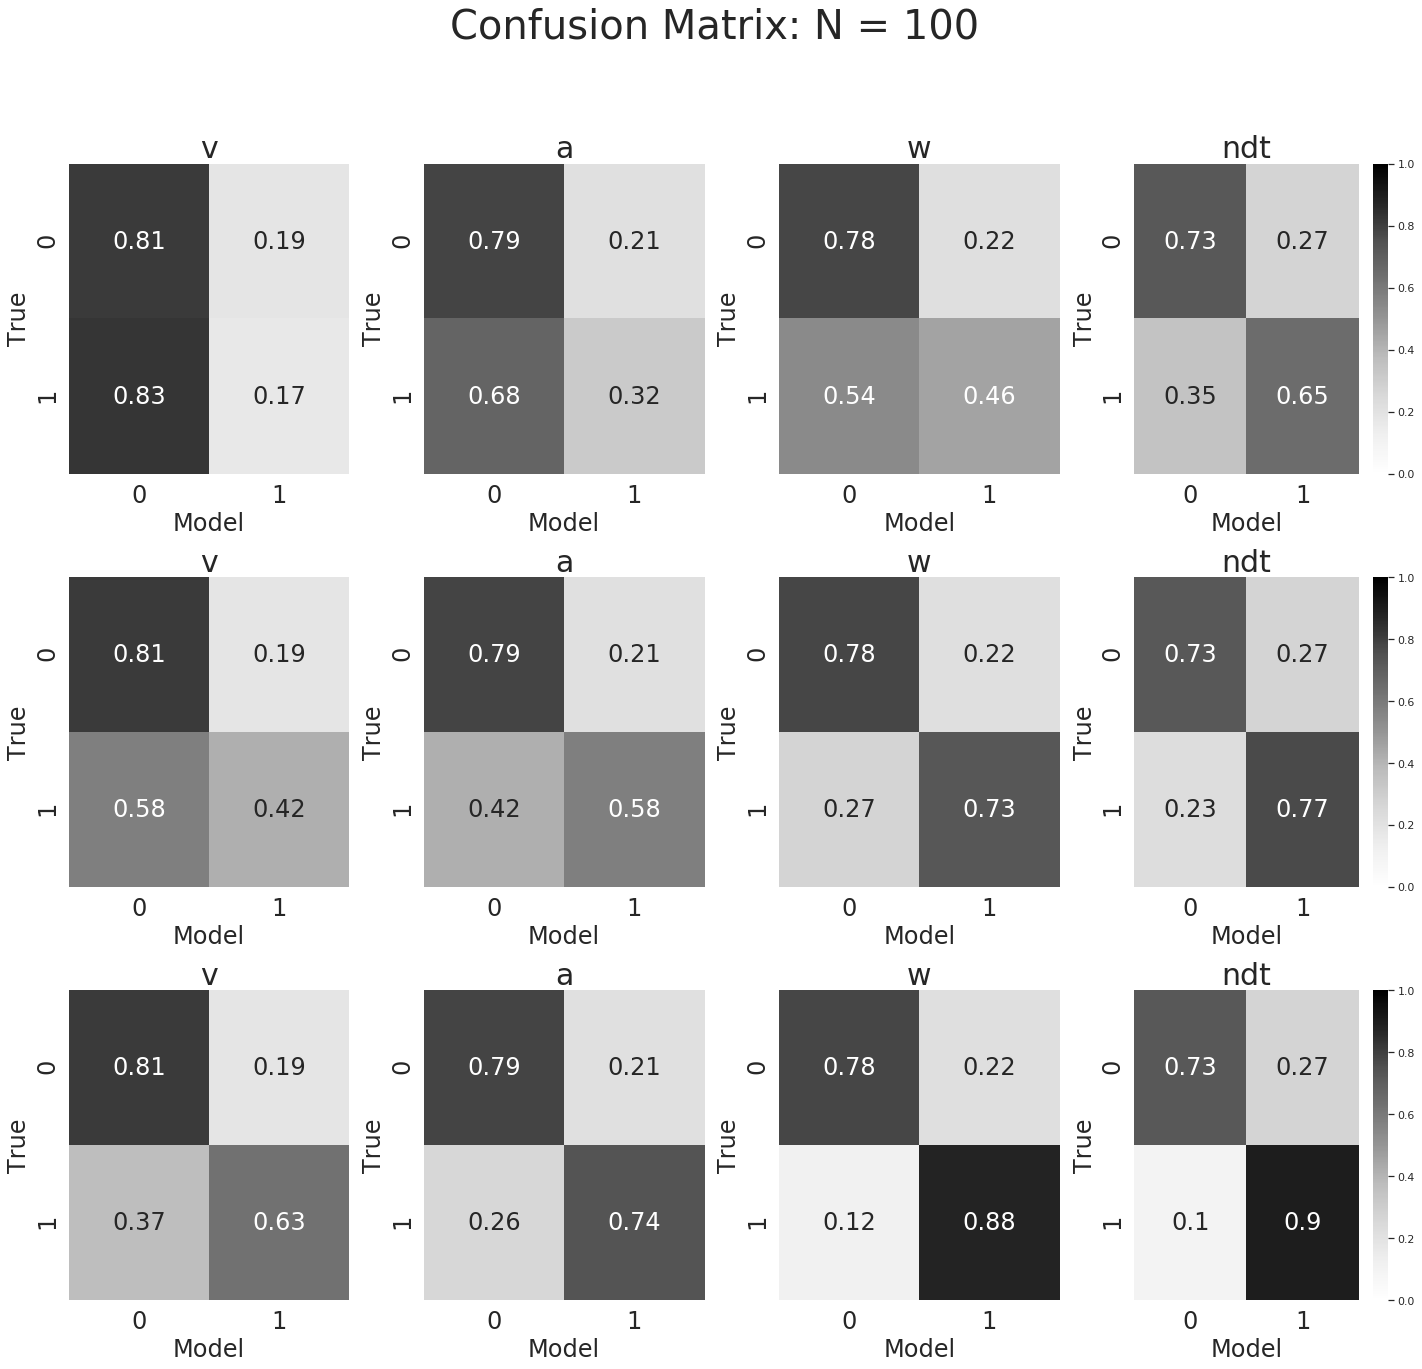

In [286]:
# n = 100
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 100',
                       data = out[0],
                       n_perturb = 3)

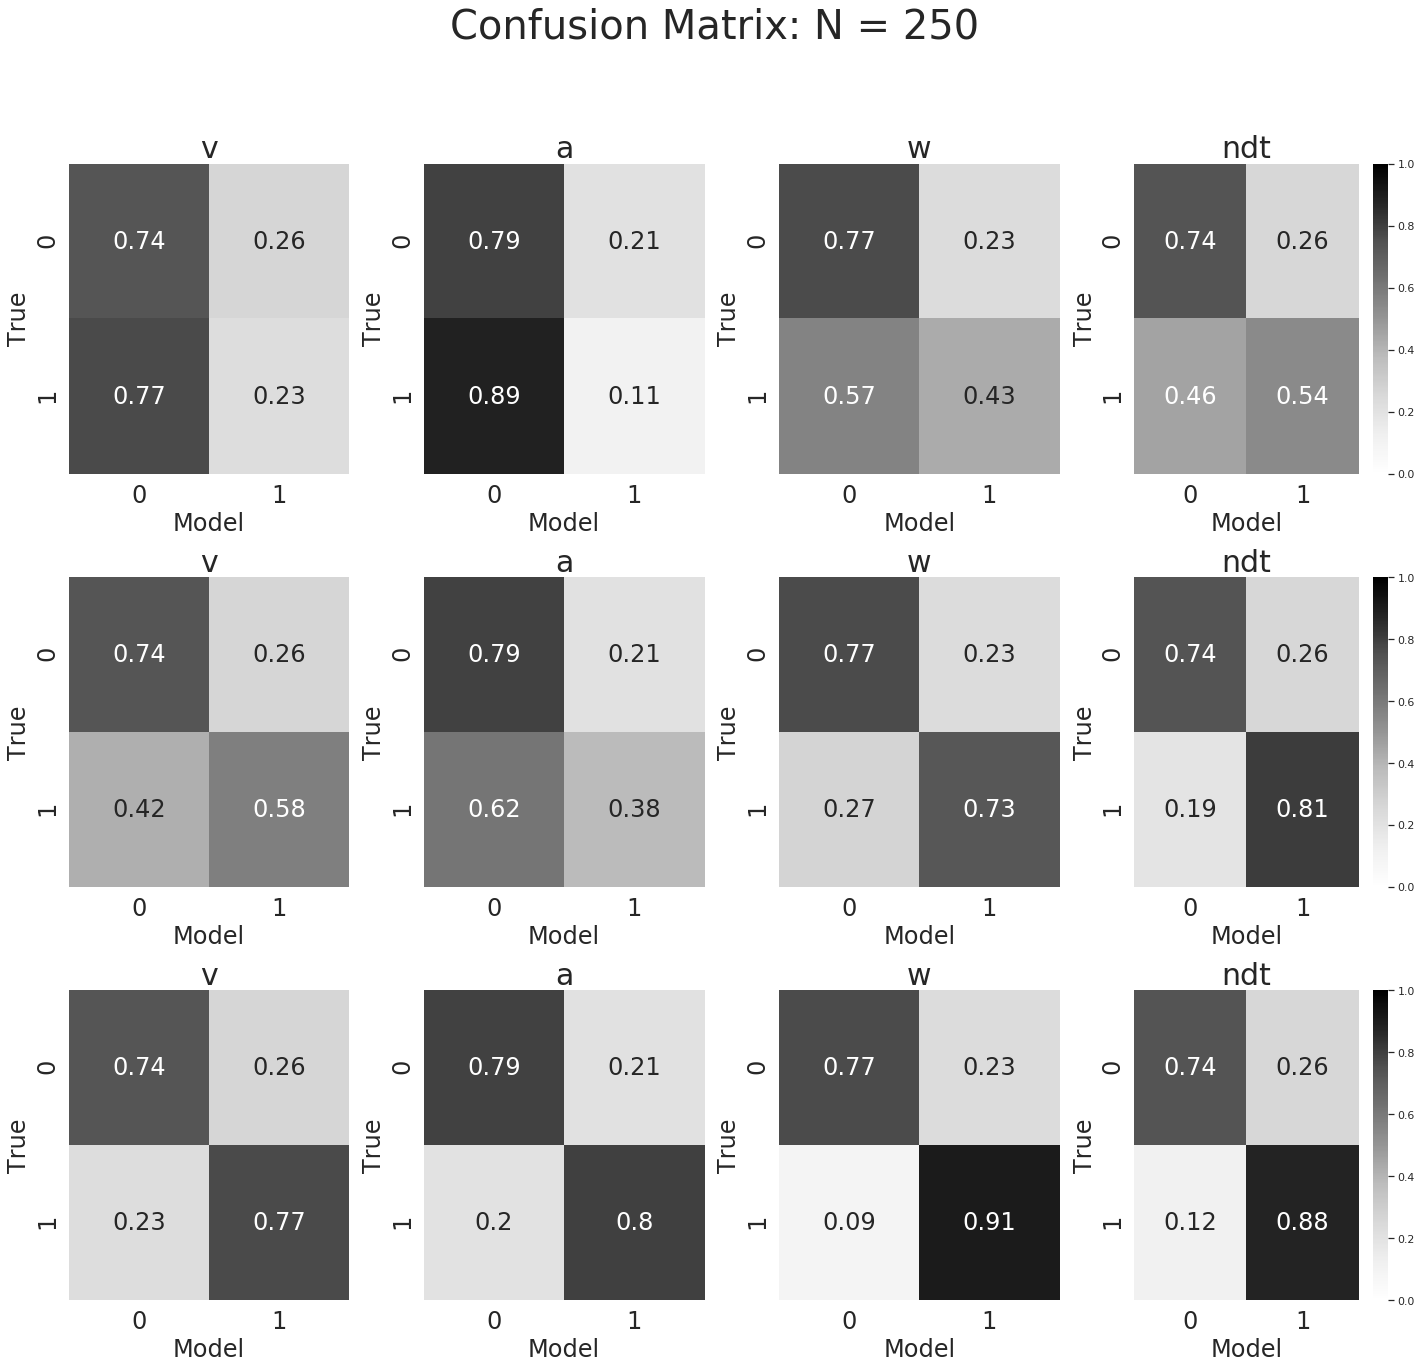

In [287]:
# n = 250
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 250',
                       data = out[1],
                       n_perturb = 3)

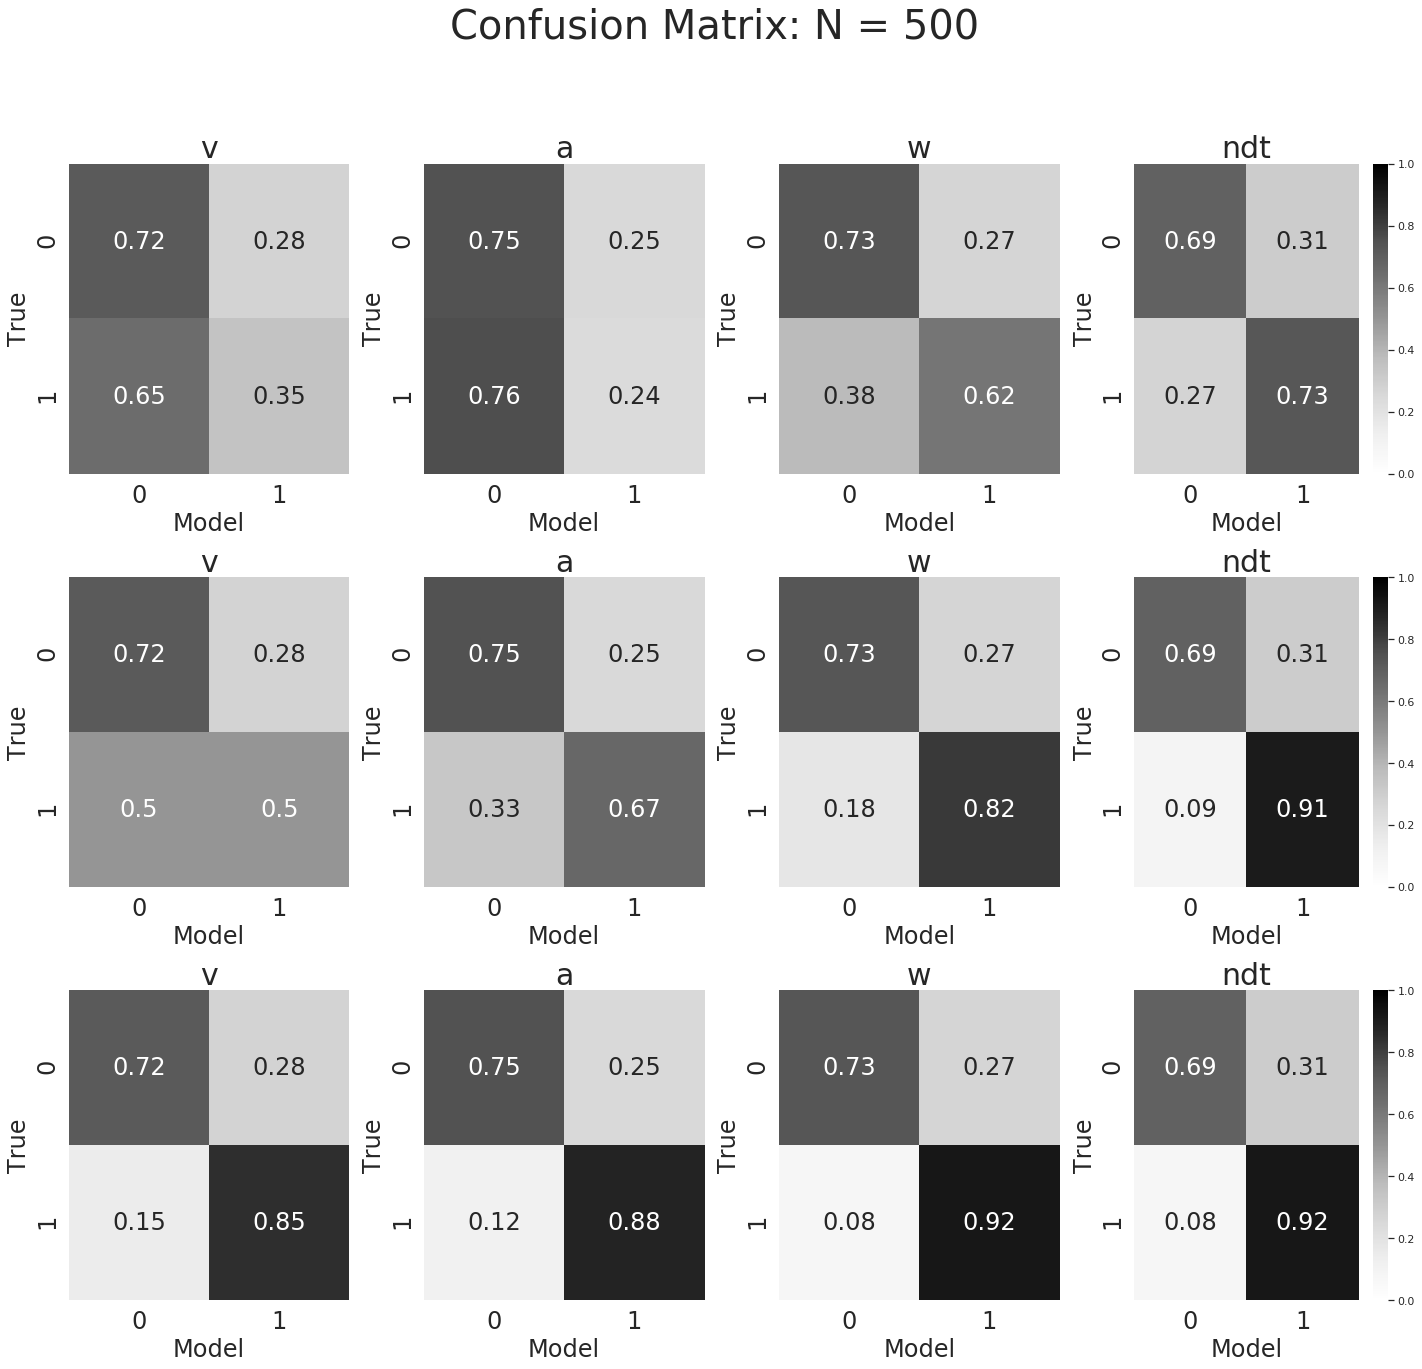

In [288]:
# n = 500
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 500',
                       data = out[2],
                       n_perturb = 3)

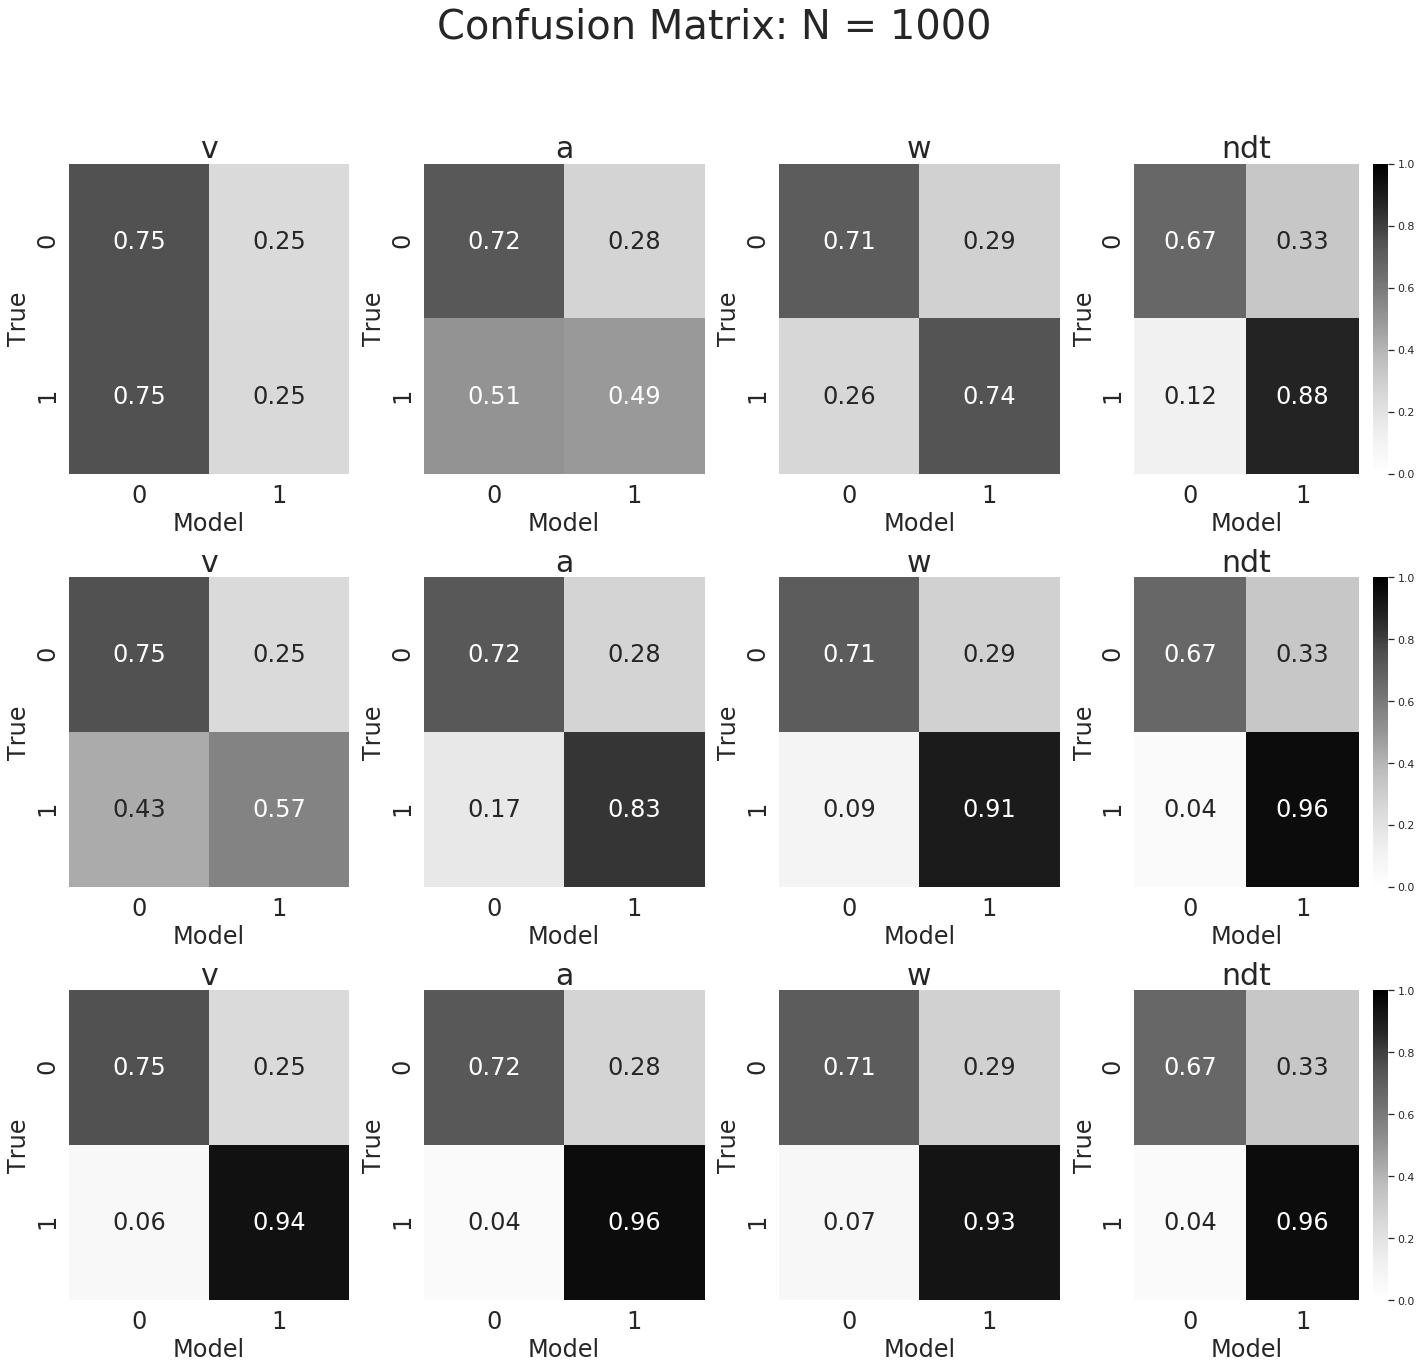

In [289]:
# n = 1000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 1000',
                       data = out[3],
                       n_perturb = 3)

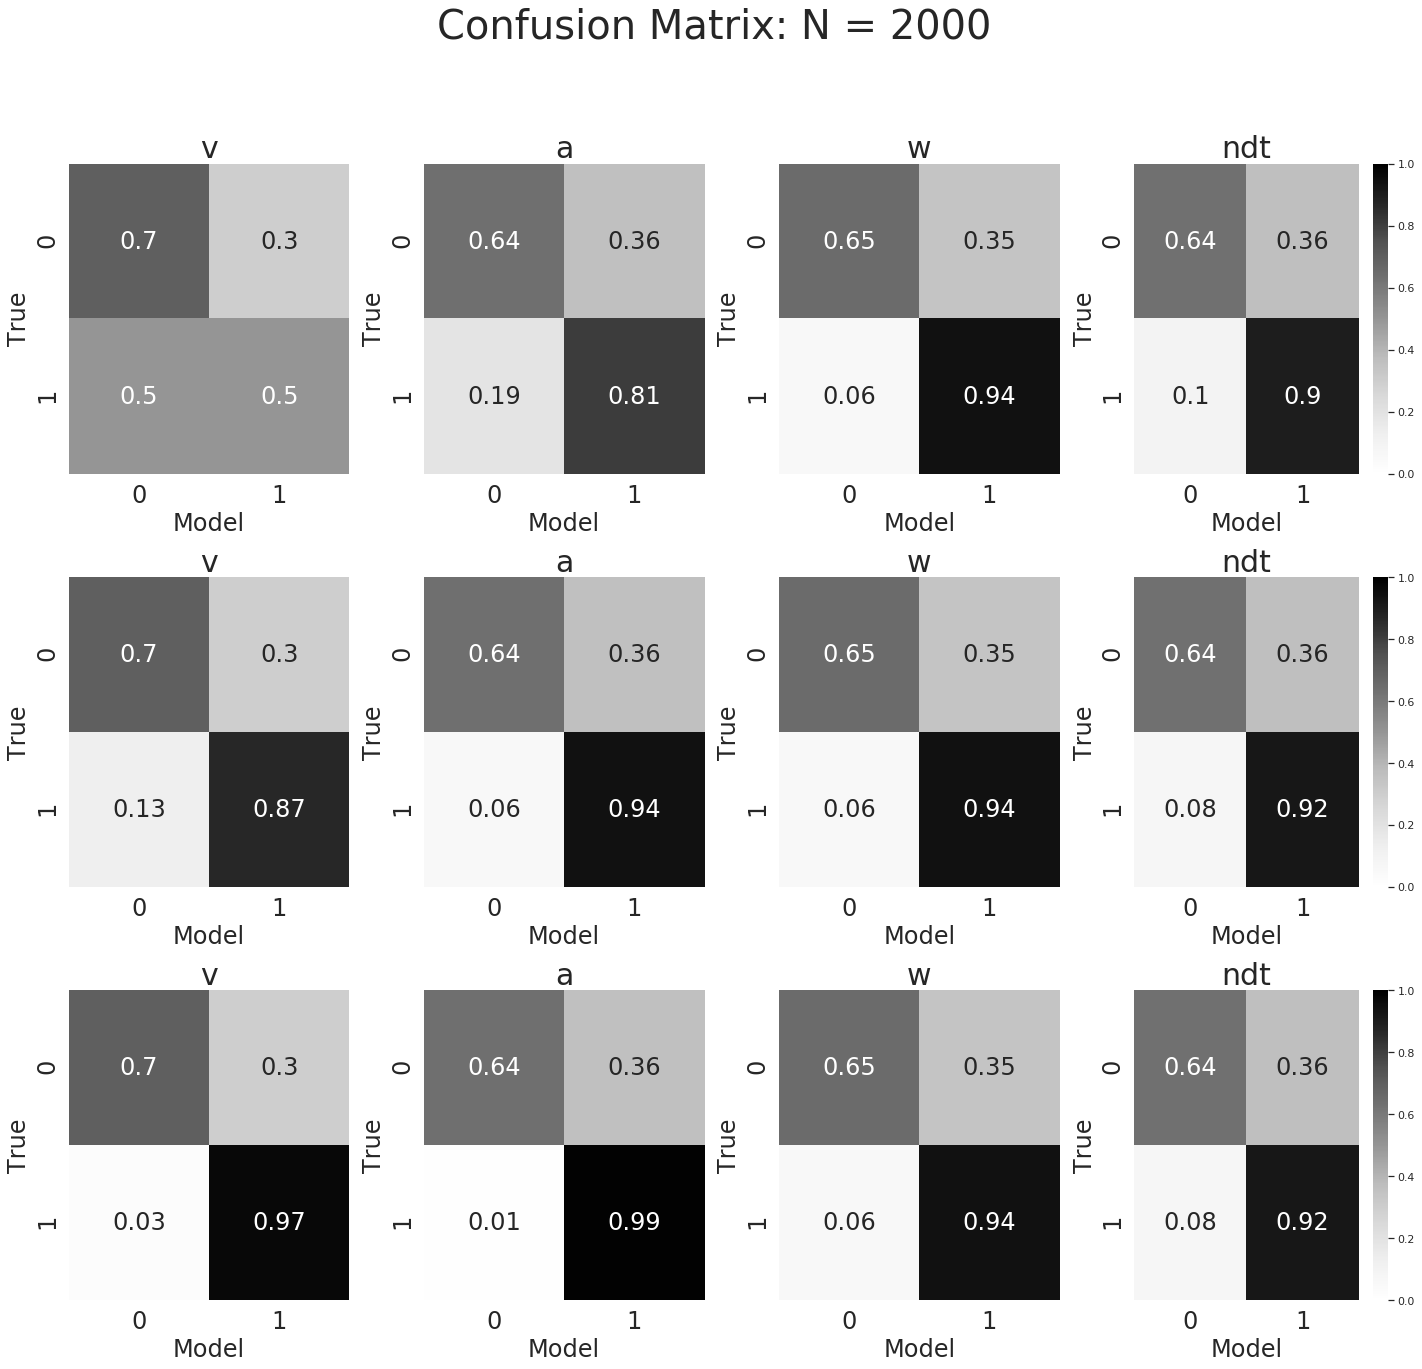

In [290]:
# n = 2000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 2000',
                       data = out[4],
                       n_perturb = 3)

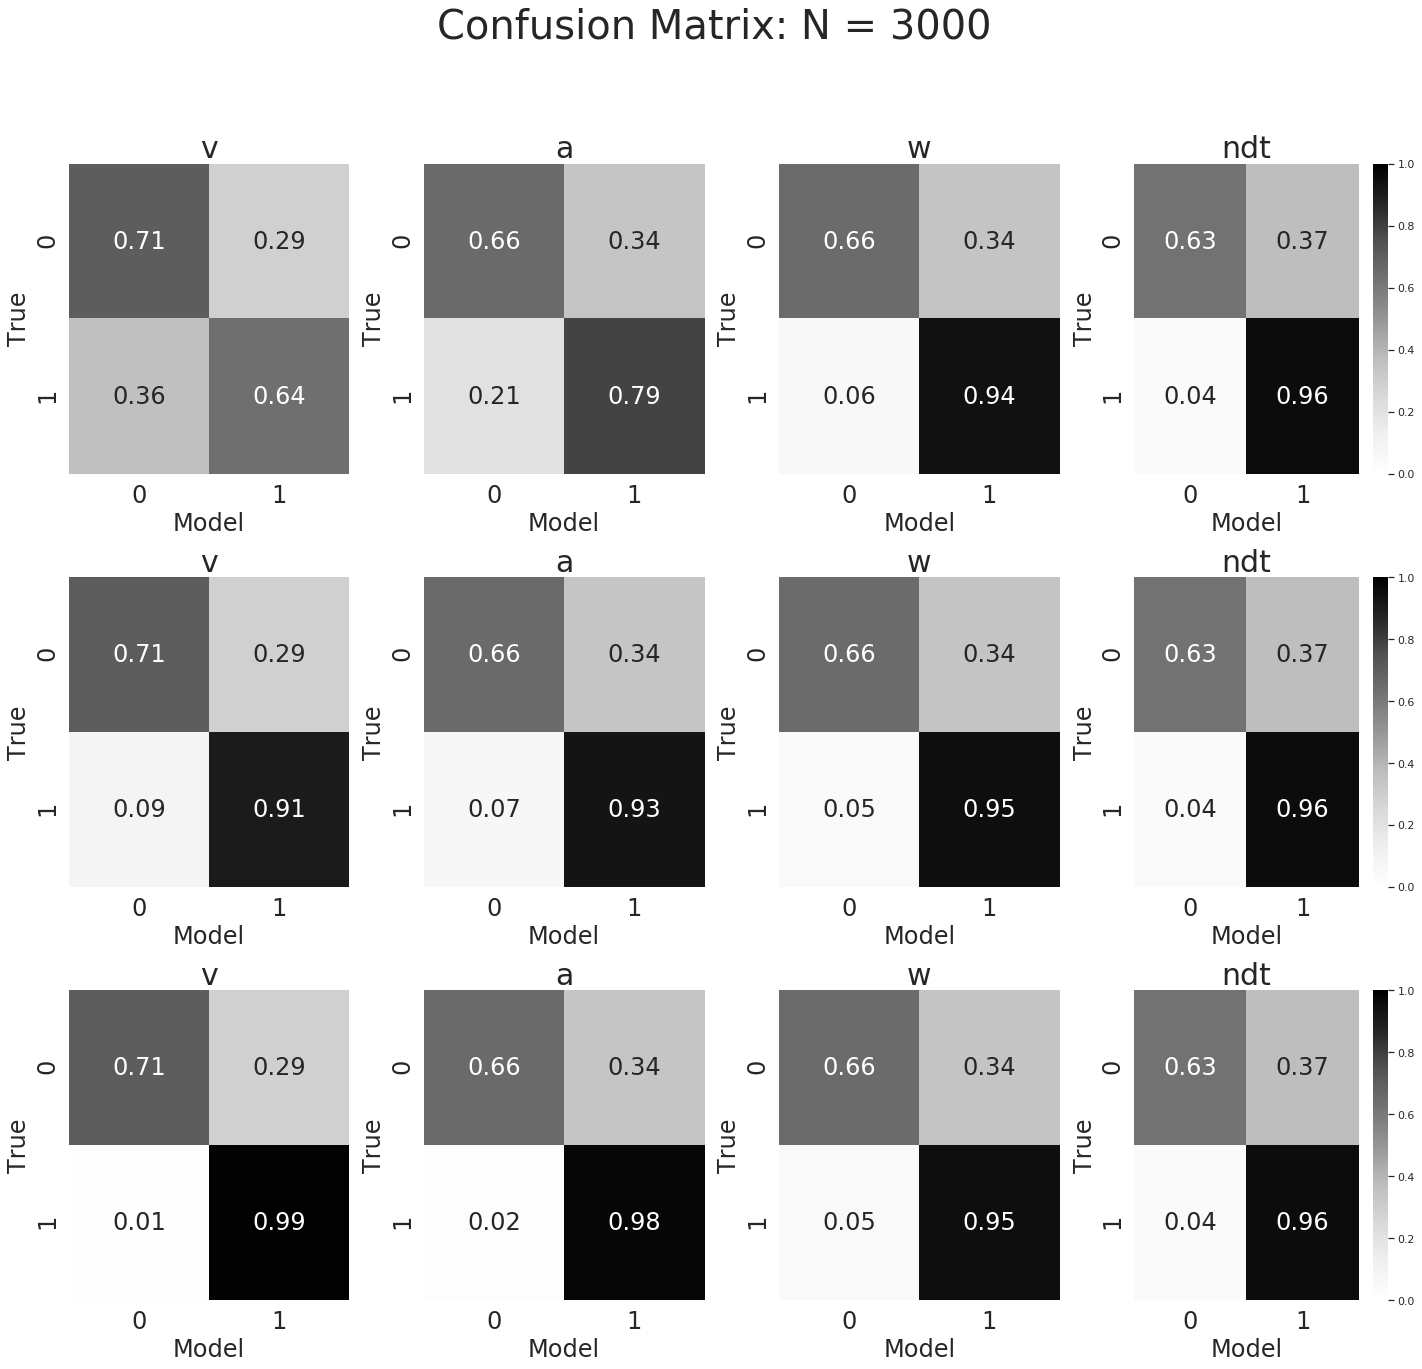

In [291]:
# n = 3000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 3000',
                       data = out[5],
                       n_perturb = 3)

In [307]:
# Analytic
sample_sizes = [100 , 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/analytic/ddm/method_comparison/'
file_base_name = file_folder + 'post_samp_perturbation_experiment_nexp_1_n_'
detection_ratio_list_analytic = []
meta_data = pickle.load(open(glob.glob('/media/data_cifs/afengler/data/kde/ddm/method_comparison/base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]
out_analytic = []

for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out_analytic.append(bayesian_t_test_global(file_list = files_,
                                 meta_data = meta_data,
                                 kind = 'posterior_samples'))

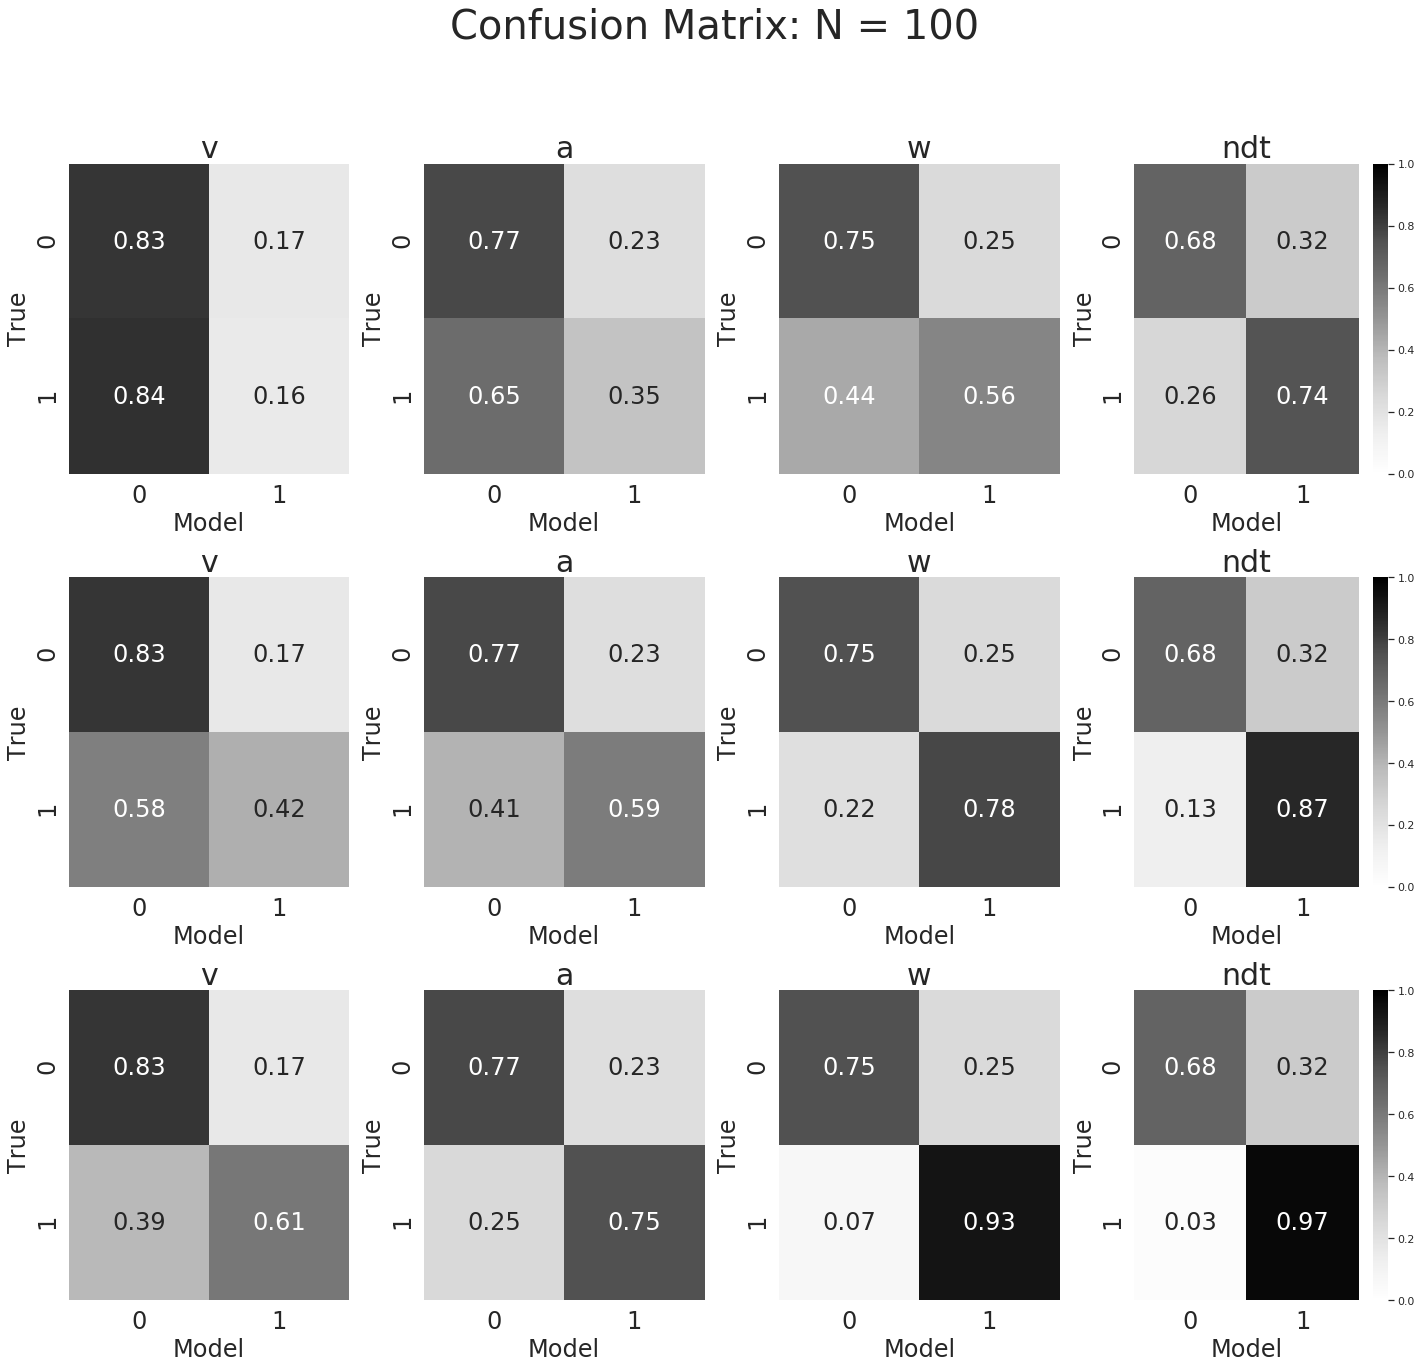

In [308]:
# n = 100
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 100',
                       data = out_analytic[0],
                       n_perturb = 3)

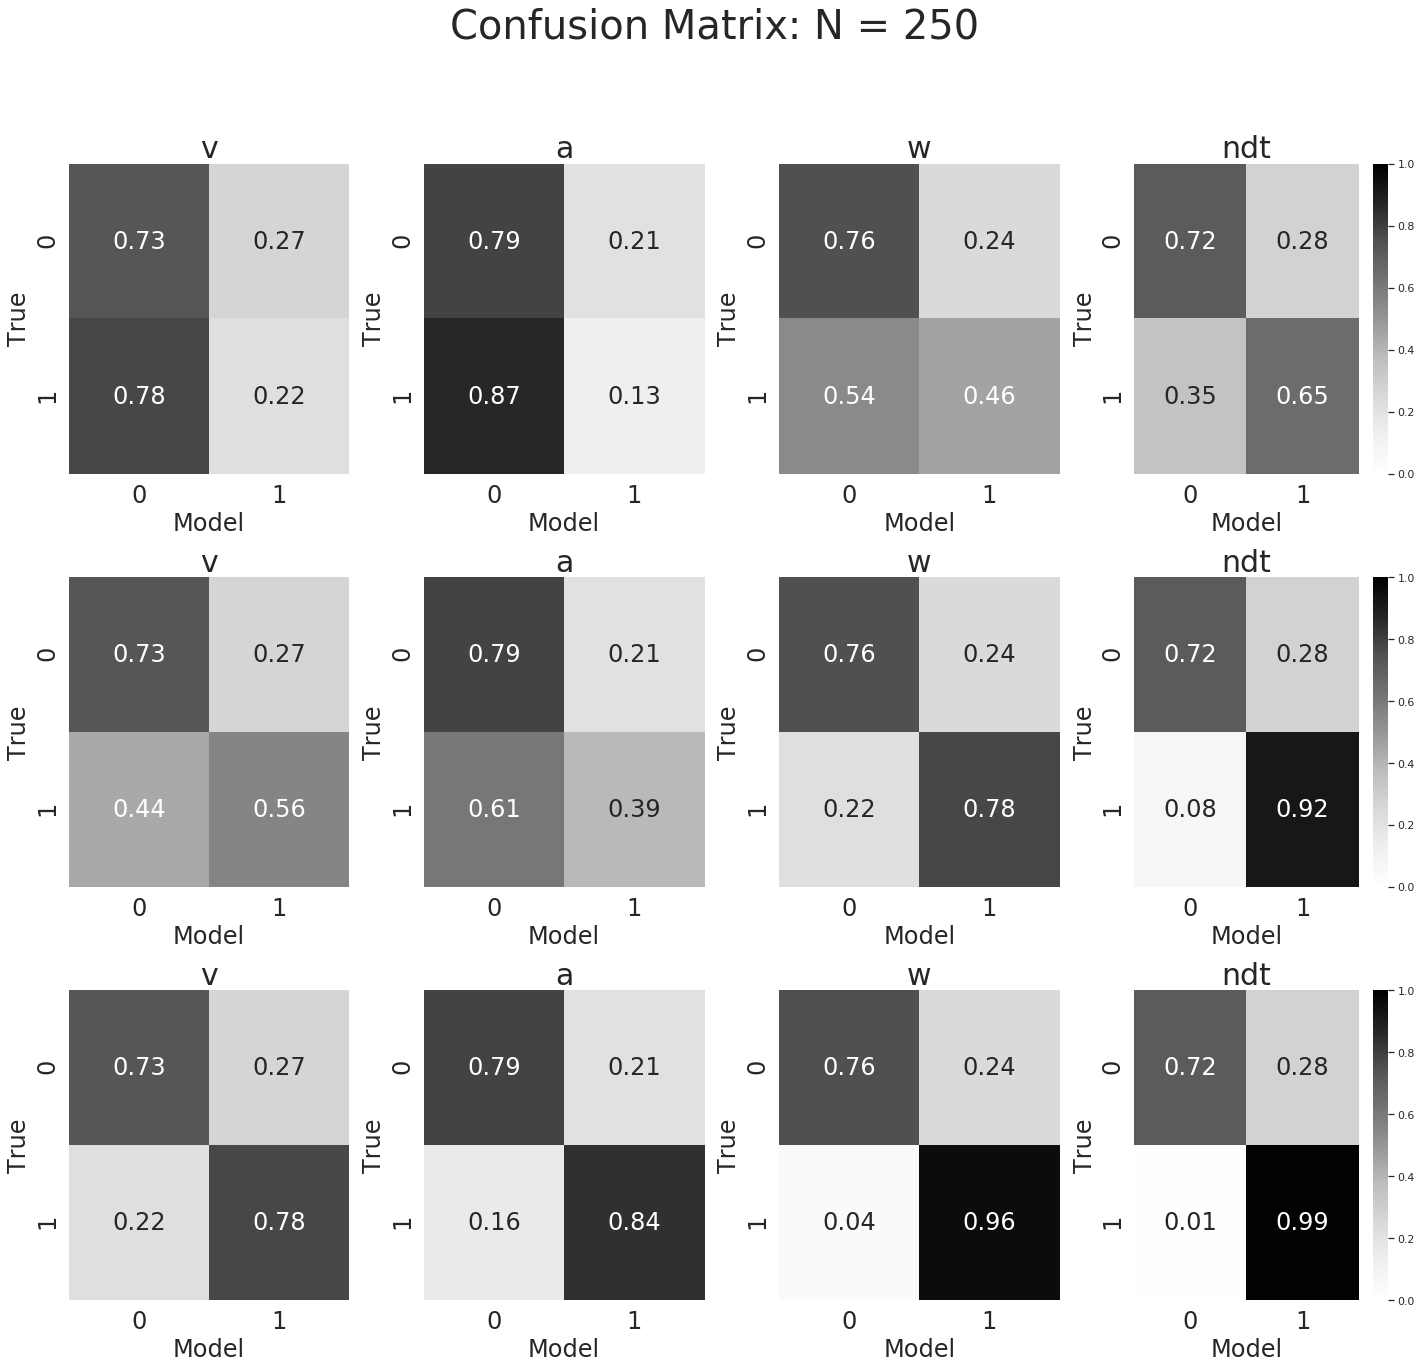

In [309]:
# n = 250
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 250',
                       data = out_analytic[1],
                       n_perturb = 3)

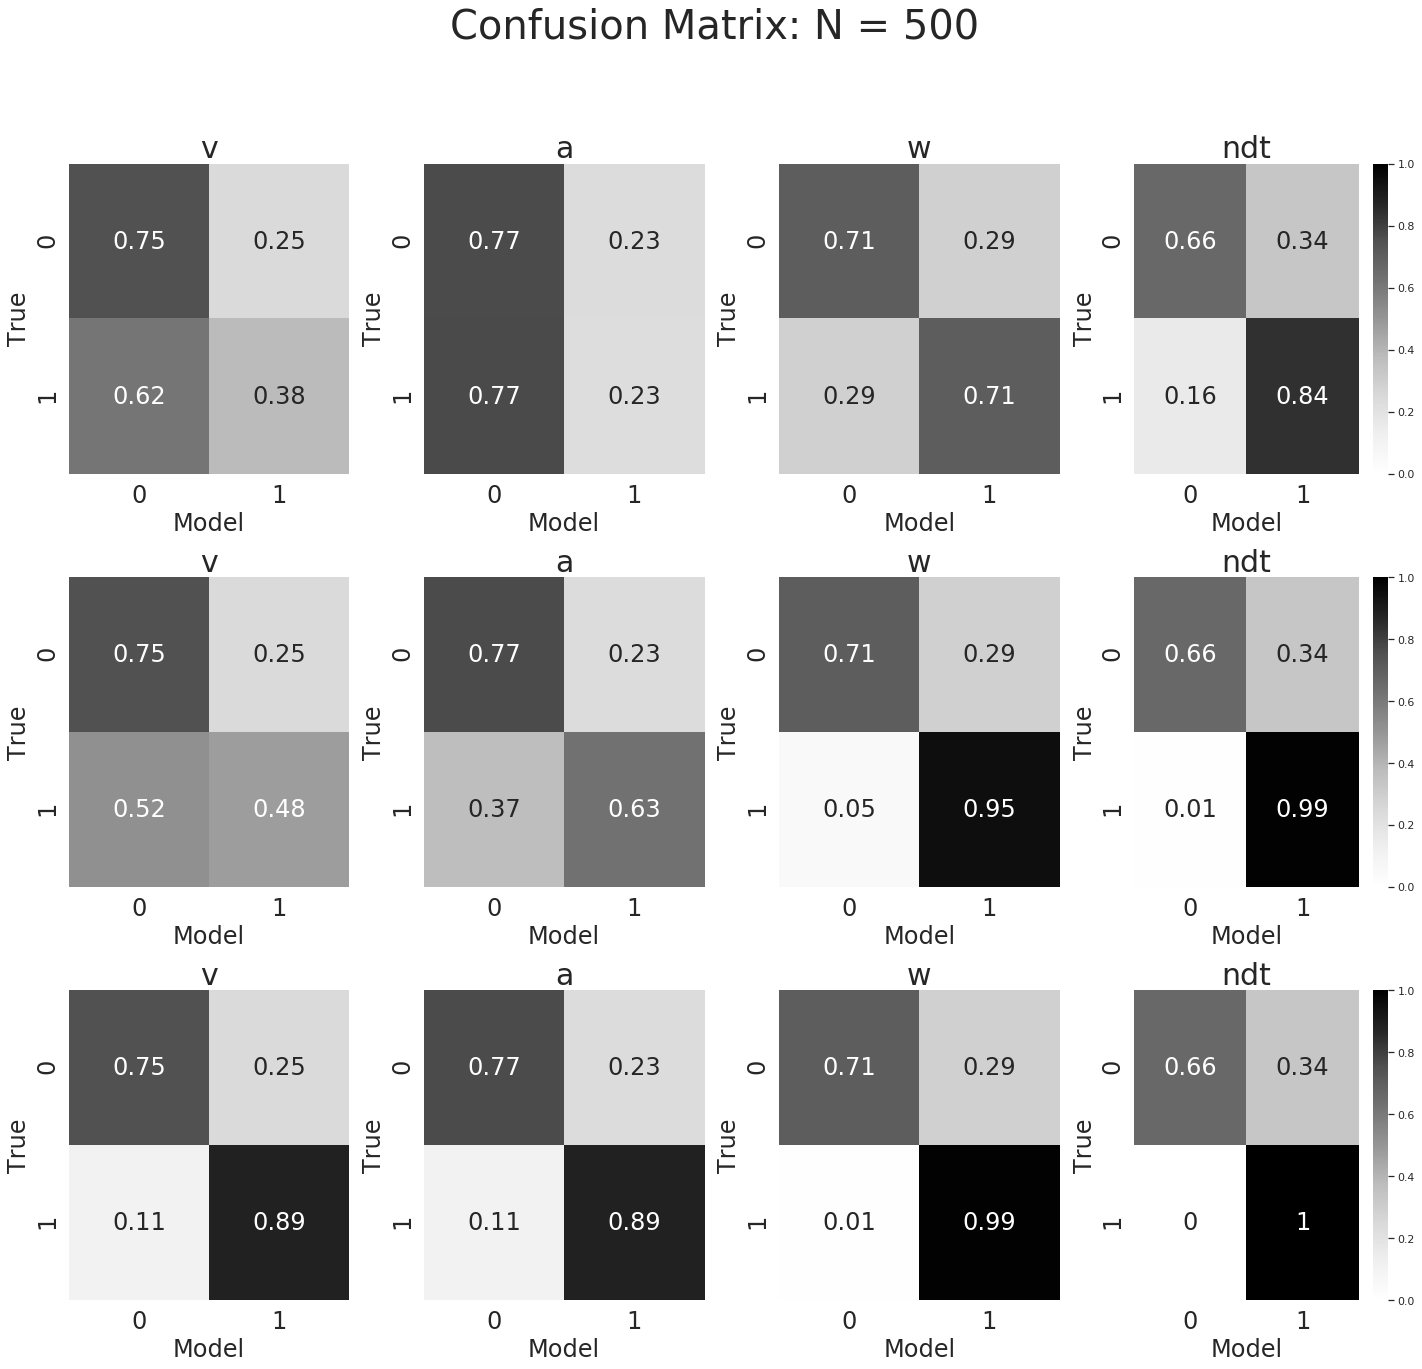

In [310]:
# n = 500
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 500',
                       data = out_analytic[2],
                       n_perturb = 3)

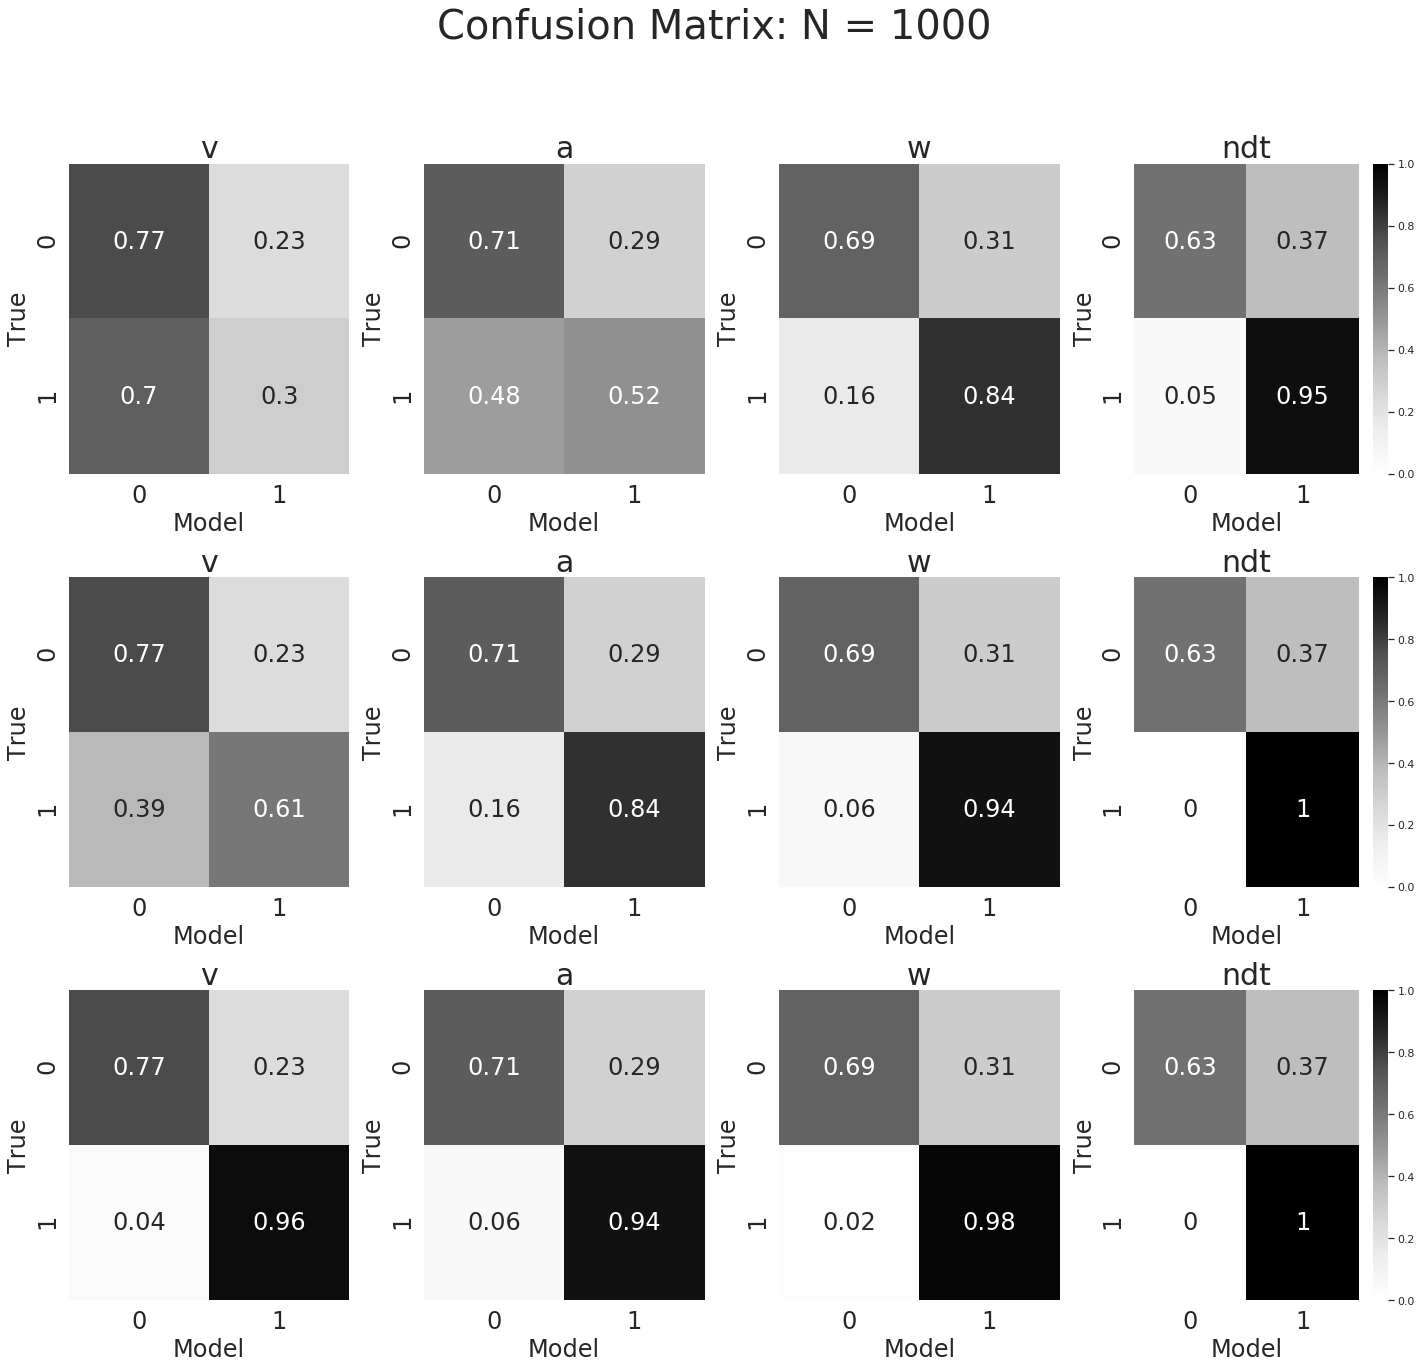

In [311]:
# n = 1000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 1000',
                       data = out_analytic[3],
                       n_perturb = 3)

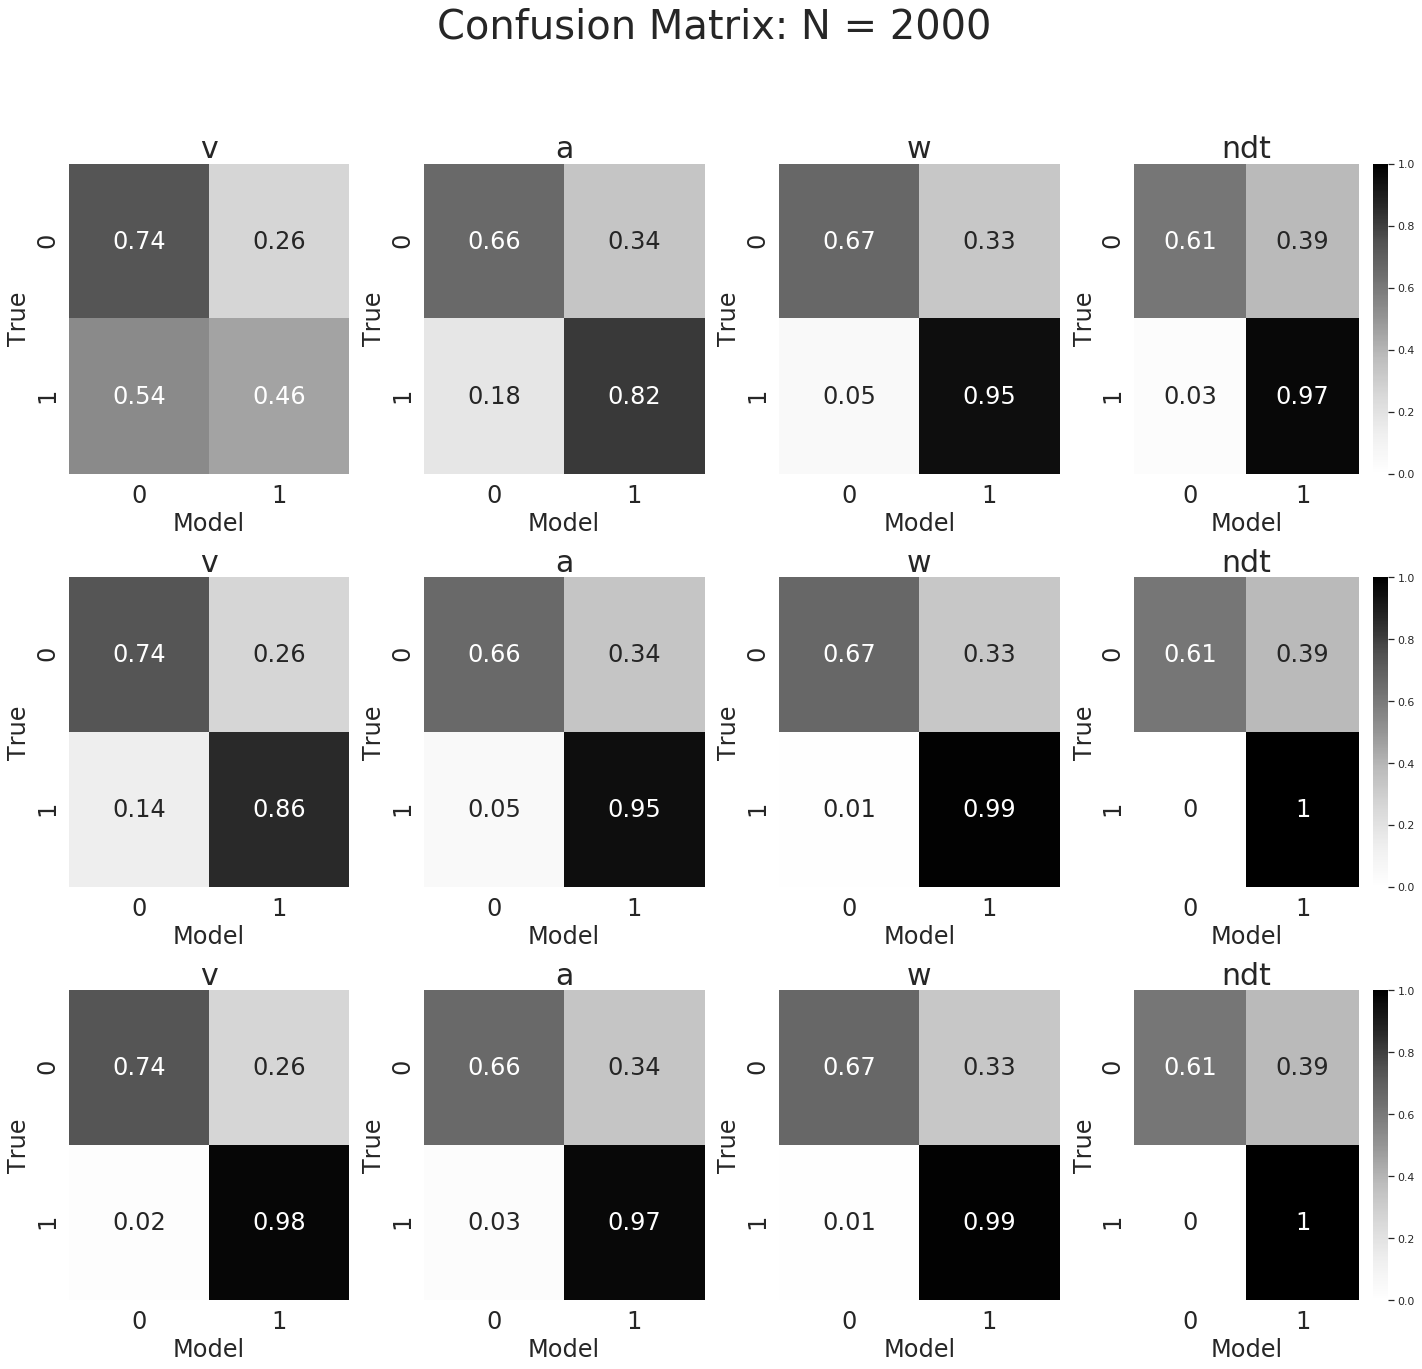

In [312]:
# n = 2000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 2000',
                       data = out_analytic[4],
                       n_perturb = 3)

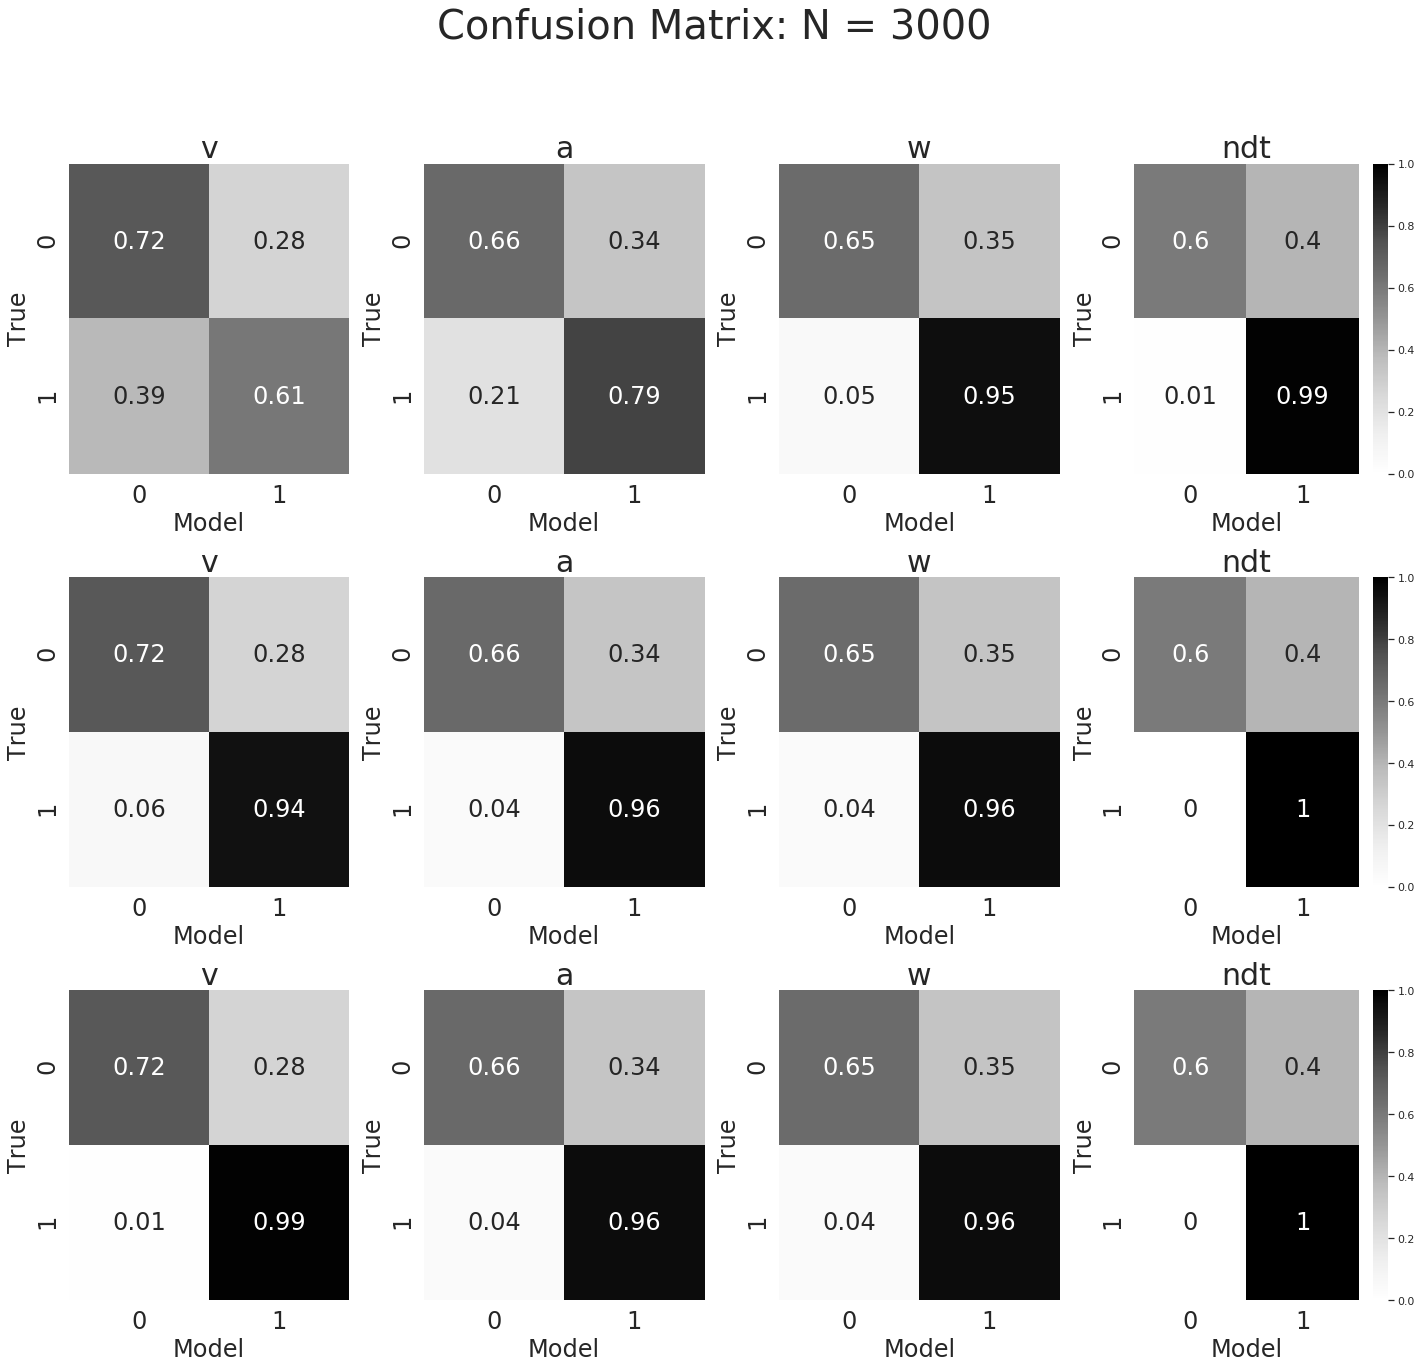

In [313]:
# n = 3000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 3000',
                       data = out_analytic[5],
                       n_perturb = 3)

In [343]:
# FCN

# Initializations
sample_sizes = [100 , 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/kde/ddm/method_comparison/'
file_base_name = file_folder + 'deep_inference_perturbation_experiment_nexp_1_n_'
detection_ratio_list_fcn = []

# Load meta_data file (assumed to be same across all experiment datasets)
meta_data = pickle.load(open(glob.glob(file_folder + 'base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]

out_fcn = []
# Get detection ratios for all experiments
for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out_fcn.append(bayesian_t_test_global(file_list = files_,
                                           meta_data = meta_data,
                                           kind = 'fcn'))

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.615  0.684  0.584  0.245  0.082  0.016  0.022  0.009]
 [-1.984  0.76   0.657  0.238  0.057  0.019  0.014  0.005]
 [-1.966  0.641  0.632  0.266  0.071  0.014  0.014  0.005]
 [-1.437  0.743  0.637  0.254  0.057  0.012  0.011  0.005]
 [-1.882  0.833  0.692  0.231  0.066  0.024  0.015  0.01 ]
 [-1.8    0.825  0.757  0.229  0.063  0.018  0.012  0.009]
 [-0.977  0.896  0.551  0.218  0.05   0.023  0.014  0.01 ]
 [-2.242  0.738  0.732  0.257  0.055  0.018  0.01   0.005]
 [-1.847  0.75   0.722  0.245  0.054  0.013  0.01   0.005]
 [-1.194  0.761  0.773  0.217  0.058  0.011  0.009  0.005]
 [-1.352  0.657  0.526  0.308  0.075  0.015  0.017  0.006]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False  True False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.407  0.611  0.541  0.117  0.081  0.017  0.019  0.009]
 [-2.14   0.696  0.585  0.164  0.081  0.015  0.018  0.007]
 [-1.956  0.639  0.73   0.141  0.095  0.018  0.016  0.007]
 [-2.447  0.593  0.679  0.149  0.097  0.02   0.018  0.007]
 [-1.592  0.791  0.572  0.15   0.054  0.024  0.013  0.004]
 [-1.8    0.743  0.628  0.141  0.071  0.017  0.015  0.009]
 [-1.851  0.817  0.713  0.108  0.07   0.011  0.014  0.009]
 [-1.853  0.638  0.691  0.136  0.071  0.011  0.01   0.004]
 [-1.165  0.596  0.679  0.106  0.08   0.01   0.012  0.005]
 [-1.88   0.607  0.823  0.121  0.104  0.011  0.009  0.004]
 [-1.215  0.617  0.578  0.164  0.067  0.011  0.014  0.007]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [ True False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[2.086 0.804 0.272 0.825 0.06  0.031 0.014 0.009]
 [2.216 0.788 0.217 0.887 0.051 0.023 0.006 0.005]
 [1.262 0.657 0.374 0.9   0.056 0.009 0.009 0.004]
 [1.669 0.773 0.393 0.825 0.067 0.016 0.017 0.008]
 [1.601 0.761 0.347 0.889 0.061 0.015 0.012 0.007]
 [1.853 0.975 0.399 0.833 0.057 0.027 0.018 0.011]
 [2.018 0.968 0.342 0.839 0.059 0.043 0.016 0.009]
 [2.204 0.689 0.323 0.851 0.071 0.02  0.017 0.006]
 [2.087 0.777 0.376 0.833 0.066 0.027 0.02  0.008]
 [1.805 0.656 0.483 0.862 0.073 0.014 0.016 0.006]
 [1.373 0.629 0.293 0.921 0.06  0.01  0.009 0.005]
 [1.852 0.686 0.325 0.945 0.07  0.016 0.011 0.006]
 [1.54  0.749 0.368 0.976 0.055 0.018 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[1.097 0.951 0.536 0.397 0.051 0.018 0.016 0.01 ]
 [1.202 0.869 0.488 0.413 0.053 0.018 0.015 0.009]
 [1.222 0.836 0.565 0.459 0.058 0.015 0.016 0.008]
 [1.004 0.875 0.587 0.46  0.057 0.017 0.016 0.008]
 [0.92  1.113 0.612 0.444 0.05  0.035 0.019 0.012]
 [1.338 1.064 0.498 0.43  0.051 0.03  0.018 0.011]
 [1.506 1.039 0.395 0.38  0.047 0.019 0.016 0.016]
 [1.063 0.883 0.641 0.453 0.058 0.024 0.016 0.007]
 [0.726 0.764 0.702 0.467 0.049 0.014 0.012 0.004]
 [1.511 0.936 0.744 0.439 0.072 0.054 0.021 0.006]
 [1.031 0.82  0.565 0.503 0.059 0.015 0.015 0.007]
 [1.579 1.17  0.531 0.465 0.066 0.051 0.025 0.013]
 [1.012 0.872 0.59  0.651 0.061 0.013 0.0

[[False False False False]
 [ True False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.556 1.371 0.666 0.539 0.039 0.03  0.016 0.013]
 [0.653 1.431 0.748 0.578 0.038 0.051 0.015 0.011]
 [1.099 1.353 0.584 0.45  0.047 0.035 0.02  0.017]
 [0.671 1.47  0.748 0.531 0.045 0.062 0.019 0.014]
 [0.536 1.31  0.664 0.54  0.035 0.022 0.013 0.012]
 [0.672 1.426 0.646 0.424 0.037 0.037 0.015 0.019]
 [0.679 1.677 0.694 0.419 0.032 0.056 0.016 0.02 ]
 [0.437 1.403 0.748 0.501 0.033 0.039 0.015 0.01 ]
 [0.361 1.171 0.777 0.491 0.036 0.024 0.012 0.007]
 [0.581 1.175 0.806 0.474 0.044 0.032 0.013 0.006]
 [0.676 1.505 0.733 0.5   0.035 0.048 0.015 0.013]
 [0.632 1.363 0.588 0.499 0.033 0.022 0.013 0.015]
 [0.478 1.221 0.642 0.743 0.034 0.023 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.337 1.13  0.614 0.245 0.05  0.039 0.018 0.009]
 [1.294 1.364 0.698 0.266 0.058 0.108 0.027 0.011]
 [1.195 1.107 0.723 0.322 0.066 0.07  0.023 0.009]
 [1.412 1.169 0.564 0.194 0.072 0.047 0.025 0.013]
 [1.31  1.183 0.652 0.302 0.057 0.051 0.021 0.01 ]
 [0.884 1.422 0.834 0.29  0.049 0.087 0.017 0.008]
 [1.489 1.401 0.58  0.152 0.073 0.111 0.034 0.02 ]
 [0.841 0.954 0.724 0.255 0.046 0.021 0.012 0.005]
 [1.175 1.082 0.793 0.24  0.055 0.047 0.015 0.005]
 [1.012 0.975 0.899 0.275 0.068 0.048 0.015 0.004]
 [1.889 1.213 0.578 0.283 0.074 0.151 0.041 0.013]
 [1.122 1.361 0.775 0.352 0.054 0.1   0.021 0.009]
 [1.378 1.231 0.641 0.431 0.061 0.074 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[0.533 1.06  0.531 0.486 0.035 0.015 0.011 0.011]
 [0.591 0.933 0.527 0.537 0.039 0.015 0.012 0.008]
 [0.531 0.998 0.613 0.577 0.043 0.019 0.014 0.01 ]
 [0.938 0.968 0.545 0.515 0.049 0.022 0.017 0.01 ]
 [0.401 0.99  0.615 0.582 0.043 0.015 0.013 0.009]
 [0.574 1.06  0.569 0.52  0.037 0.021 0.013 0.011]
 [0.73  1.086 0.527 0.49  0.041 0.021 0.015 0.013]
 [0.654 1.108 0.651 0.5   0.049 0.024 0.015 0.012]
 [0.672 0.944 0.669 0.511 0.048 0.017 0.014 0.007]
 [0.528 0.861 0.708 0.548 0.051 0.017 0.014 0.006]
 [0.292 0.942 0.635 0.687 0.042 0.016 0.013 0.009]
 [0.455 0.887 0.611 0.681 0.044 0.013 0.012 0.008]
 [0.212 0.907 0.63  0.737 0.042 0.012 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.021 1.208 0.49  0.364 0.043 0.028 0.015 0.017]
 [1.086 1.049 0.438 0.348 0.046 0.023 0.014 0.013]
 [0.905 1.228 0.544 0.347 0.05  0.031 0.021 0.019]
 [1.184 0.926 0.509 0.341 0.055 0.017 0.016 0.011]
 [1.086 1.123 0.469 0.303 0.044 0.021 0.015 0.014]
 [0.895 1.326 0.51  0.247 0.038 0.029 0.016 0.018]
 [1.189 1.323 0.437 0.31  0.052 0.02  0.018 0.025]
 [1.255 1.299 0.559 0.248 0.063 0.052 0.024 0.019]
 [0.784 1.111 0.691 0.384 0.051 0.032 0.017 0.01 ]
 [0.95  1.075 0.614 0.286 0.045 0.02  0.014 0.009]
 [0.961 1.131 0.451 0.312 0.043 0.017 0.015 0.017]
 [0.888 1.074 0.475 0.436 0.039 0.015 0.013 0.011]
 [1.219 1.487 0.573 0.457 0.063 0.049 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False  True False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.151 0.66  0.302 0.797 0.059 0.013 0.012 0.005]
 [1.053 0.721 0.27  0.791 0.053 0.011 0.01  0.005]
 [0.786 0.722 0.298 0.745 0.055 0.013 0.012 0.006]
 [1.288 0.668 0.306 0.764 0.063 0.013 0.013 0.007]
 [0.656 0.723 0.377 0.776 0.055 0.013 0.014 0.007]
 [1.018 0.883 0.326 0.709 0.044 0.017 0.011 0.009]
 [0.927 0.887 0.367 0.752 0.045 0.015 0.012 0.008]
 [1.294 0.604 0.366 0.79  0.061 0.01  0.011 0.004]
 [1.165 0.669 0.401 0.76  0.058 0.011 0.012 0.006]
 [0.653 0.617 0.576 0.798 0.057 0.011 0.013 0.005]
 [0.967 0.672 0.395 0.807 0.055 0.011 0.011 0.005]
 [0.817 0.598 0.382 0.877 0.06  0.009 0.011 0.004]
 [1.259 0.721 0.317 0.927 0.059 0.013 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.461 0.687 0.498 0.619 0.052 0.012 0.012 0.005]
 [0.62  0.83  0.47  0.542 0.039 0.013 0.011 0.006]
 [0.676 0.702 0.542 0.65  0.052 0.011 0.012 0.005]
 [1.02  0.773 0.484 0.592 0.062 0.016 0.016 0.009]
 [0.377 0.91  0.612 0.608 0.041 0.014 0.012 0.008]
 [0.975 0.692 0.482 0.654 0.054 0.011 0.012 0.005]
 [0.498 0.938 0.586 0.639 0.043 0.016 0.012 0.008]
 [0.664 0.72  0.576 0.593 0.052 0.01  0.012 0.006]
 [0.396 0.667 0.638 0.61  0.053 0.011 0.012 0.005]
 [0.841 0.782 0.702 0.588 0.063 0.019 0.014 0.005]
 [0.75  0.724 0.507 0.664 0.045 0.011 0.01  0.005]
 [1.031 0.848 0.431 0.672 0.044 0.014 0.011 0.007]
 [0.558 0.736 0.552 0.782 0.057 0.014 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [ True False False False]
 [False False False False]
 [False False  True False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-0.109  0.562  0.643  0.346  0.061  0.007  0.01   0.004]
 [-0.476  0.627  0.581  0.348  0.054  0.008  0.011  0.004]
 [-0.407  0.601  0.673  0.349  0.055  0.008  0.009  0.003]
 [ 0.152  0.605  0.636  0.347  0.057  0.009  0.011  0.004]
 [-0.265  0.699  0.653  0.34   0.048  0.012  0.011  0.005]
 [-0.168  0.705  0.651  0.38   0.058  0.012  0.013  0.007]
 [-0.052  0.775  0.648  0.371  0.052  0.011  0.012  0.006]
 [-0.788  0.666  0.748  0.344  0.061  0.011  0.01   0.005]
 [-0.167  0.631  0.68   0.332  0.053  0.009  0.01   0.004]
 [-0.119  0.613  0.927  0.386  0.086  0.013  0.011  0.002]
 [-0.44   0.621  0.6    0.401  0.054  0.009  0.011  0.004]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.904  1.131  0.403  0.68   0.07   0.092  0.035  0.012]
 [-2.272  0.974  0.52   0.685  0.071  0.065  0.033  0.011]
 [-2.14   1.045  0.426  0.692  0.072  0.121  0.038  0.011]
 [-1.651  0.939  0.466  0.714  0.058  0.034  0.02   0.008]
 [-2.018  1.014  0.375  0.748  0.075  0.112  0.033  0.009]
 [-2.045  1.121  0.489  0.694  0.074  0.107  0.038  0.014]
 [-1.865  1.35   0.587  0.535  0.067  0.056  0.034  0.028]
 [-1.797  1.327  0.431  0.646  0.066  0.152  0.04   0.016]
 [-1.634  0.876  0.58   0.68   0.068  0.014  0.019  0.012]
 [-1.798  0.893  0.725  0.647  0.062  0.022  0.016  0.011]
 [-1.465  1.042  0.363  0.772  0.058  0.047  0.017  0.007]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.018 1.282 0.499 0.886 0.027 0.019 0.011 0.016]
 [0.188 1.23  0.519 0.896 0.029 0.019 0.012 0.015]
 [0.043 1.241 0.514 0.89  0.027 0.017 0.011 0.014]
 [0.297 1.279 0.493 0.845 0.026 0.017 0.01  0.014]
 [0.227 1.358 0.479 0.782 0.029 0.023 0.014 0.021]
 [0.085 1.392 0.502 0.821 0.025 0.022 0.012 0.019]
 [0.003 1.431 0.546 0.846 0.025 0.02  0.012 0.02 ]
 [0.057 1.256 0.586 0.822 0.03  0.018 0.012 0.014]
 [0.157 1.296 0.605 0.856 0.03  0.019 0.012 0.015]
 [0.123 1.196 0.735 0.909 0.034 0.019 0.012 0.011]
 [0.026 1.319 0.616 0.898 0.028 0.019 0.012 0.016]
 [0.091 1.301 0.522 0.947 0.027 0.018 0.012 0.015]
 [0.161 1.345 0.51  0.987 0.028 0.021 0.0

[[False False False False]
 [False False False False]
 [ True False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.541  1.039  0.62   0.866  0.053  0.025  0.016  0.013]
 [-1.278  1.046  0.635  0.814  0.046  0.024  0.014  0.013]
 [-1.156  1.027  0.646  0.809  0.044  0.024  0.013  0.013]
 [-0.952  1.011  0.607  0.852  0.041  0.019  0.012  0.011]
 [-1.331  1.158  0.581  0.802  0.048  0.023  0.015  0.014]
 [-1.324  1.15   0.617  0.838  0.05   0.025  0.016  0.015]
 [-1.395  1.243  0.609  0.835  0.048  0.032  0.016  0.017]
 [-1.289  1.005  0.667  0.819  0.046  0.023  0.012  0.011]
 [-1.076  1.118  0.701  0.783  0.037  0.019  0.01   0.012]
 [-1.037  0.991  0.772  0.806  0.035  0.011  0.008  0.007]
 [-1.308  1.141  0.612  0.869  0.047  0.027  0.014  0.014]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[1.77  1.01  0.612 0.355 0.071 0.065 0.027 0.008]
 [1.883 0.841 0.523 0.36  0.068 0.032 0.023 0.007]
 [1.762 0.972 0.667 0.38  0.068 0.062 0.024 0.007]
 [1.982 0.897 0.647 0.385 0.078 0.05  0.022 0.007]
 [1.88  0.964 0.651 0.396 0.081 0.076 0.029 0.007]
 [1.595 0.883 0.636 0.399 0.071 0.042 0.022 0.007]
 [1.797 0.994 0.618 0.375 0.073 0.071 0.028 0.008]
 [1.871 0.911 0.693 0.374 0.08  0.069 0.026 0.006]
 [2.    0.791 0.632 0.365 0.076 0.035 0.021 0.005]
 [1.728 0.798 0.788 0.37  0.079 0.033 0.017 0.005]
 [1.537 0.898 0.671 0.446 0.07  0.039 0.021 0.007]
 [1.624 0.903 0.614 0.472 0.07  0.04  0.024 0.008]
 [1.911 0.964 0.656 0.582 0.077 0.074 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.144  1.195  0.615  0.507  0.03   0.017  0.01   0.013]
 [ 0.031  1.126  0.605  0.515  0.036  0.016  0.012  0.013]
 [ 0.12   1.141  0.614  0.495  0.036  0.019  0.013  0.014]
 [ 0.063  1.094  0.615  0.524  0.032  0.015  0.01   0.01 ]
 [-0.053  1.174  0.57   0.494  0.031  0.018  0.012  0.013]
 [ 0.125  1.173  0.567  0.497  0.03   0.018  0.011  0.013]
 [-0.011  1.363  0.611  0.497  0.025  0.019  0.01   0.016]
 [-0.019  1.114  0.661  0.513  0.034  0.017  0.011  0.011]
 [-0.107  0.999  0.71   0.572  0.038  0.014  0.011  0.008]
 [ 0.062  1.026  0.818  0.52   0.036  0.018  0.01   0.005]
 [ 0.068  1.146  0.598  0.506  0.031  0.017  0.011  0.012]
 [ 0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.615  1.454  0.502  0.205  0.034  0.03   0.016  0.028]
 [-0.354  1.361  0.509  0.182  0.029  0.023  0.012  0.02 ]
 [-0.464  1.364  0.501  0.238  0.032  0.033  0.014  0.024]
 [-0.3    1.425  0.474  0.159  0.028  0.019  0.012  0.018]
 [-0.355  1.424  0.497  0.172  0.027  0.024  0.012  0.019]
 [-0.46   1.582  0.51   0.124  0.03   0.025  0.013  0.032]
 [-0.482  1.44   0.5    0.273  0.03   0.023  0.013  0.024]
 [-0.412  1.409  0.571  0.182  0.033  0.025  0.015  0.026]
 [-0.501  1.275  0.623  0.228  0.028  0.021  0.01   0.015]
 [-0.447  1.373  0.717  0.204  0.03   0.019  0.011  0.013]
 [-0.561  1.357  0.541  0.293  0.031  0.023  0.012  0.02 ]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.989  1.165  0.431  0.759  0.069  0.145  0.036  0.013]
 [-1.738  1.212  0.381  0.757  0.065  0.119  0.033  0.012]
 [-1.426  1.116  0.355  0.786  0.064  0.066  0.024  0.01 ]
 [-1.428  1.091  0.419  0.763  0.061  0.047  0.023  0.011]
 [-1.534  1.091  0.371  0.786  0.061  0.061  0.022  0.009]
 [-1.603  1.267  0.39   0.788  0.064  0.12   0.032  0.014]
 [-1.704  1.283  0.396  0.773  0.063  0.111  0.031  0.013]
 [-1.552  1.168  0.322  0.819  0.063  0.11   0.027  0.01 ]
 [-1.502  1.013  0.452  0.816  0.064  0.03   0.023  0.012]
 [-1.869  1.182  0.61   0.758  0.064  0.042  0.026  0.019]
 [-1.67   1.081  0.345  0.854  0.064  0.082  0.024  0.008]
 [-1

[[False False False False]
 [False False False False]
 [ True False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-0.542  0.896  0.456  0.174  0.043  0.014  0.013  0.009]
 [-0.247  0.917  0.418  0.212  0.043  0.015  0.014  0.009]
 [-0.095  0.873  0.372  0.24   0.042  0.012  0.011  0.006]
 [ 0.1    0.824  0.382  0.216  0.045  0.015  0.013  0.008]
 [-0.284  0.927  0.393  0.222  0.04   0.015  0.013  0.009]
 [-0.357  0.961  0.4    0.239  0.038  0.015  0.012  0.008]
 [-0.363  1.08   0.443  0.257  0.036  0.016  0.012  0.011]
 [-0.318  0.909  0.435  0.199  0.043  0.014  0.012  0.009]
 [-0.093  0.869  0.446  0.235  0.039  0.011  0.01   0.007]
 [-0.275  0.889  0.622  0.222  0.04   0.013  0.011  0.008]
 [-0.377  0.886  0.44   0.259  0.039  0.012  0.011  0.007]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[0.132 0.687 0.595 0.42  0.05  0.011 0.012 0.005]
 [0.383 0.652 0.588 0.429 0.056 0.011 0.013 0.005]
 [0.225 0.668 0.64  0.439 0.056 0.01  0.012 0.005]
 [0.427 0.672 0.647 0.448 0.059 0.013 0.013 0.005]
 [0.315 0.666 0.564 0.426 0.052 0.01  0.012 0.005]
 [0.206 0.765 0.664 0.428 0.049 0.012 0.012 0.005]
 [0.192 0.838 0.655 0.458 0.047 0.014 0.012 0.007]
 [0.226 0.668 0.628 0.428 0.054 0.011 0.012 0.005]
 [0.015 0.621 0.722 0.447 0.061 0.01  0.011 0.004]
 [0.254 0.615 0.771 0.417 0.058 0.011 0.011 0.002]
 [0.401 0.685 0.622 0.469 0.059 0.013 0.014 0.006]
 [0.254 0.603 0.556 0.544 0.056 0.009 0.012 0.004]
 [0.097 0.602 0.601 0.642 0.054 0.009 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.766  1.16   0.375  0.311  0.068  0.129  0.033  0.01 ]
 [-1.641  1.196  0.399  0.269  0.069  0.078  0.031  0.014]
 [-1.429  1.222  0.371  0.297  0.064  0.082  0.026  0.012]
 [-1.25   1.202  0.343  0.277  0.058  0.063  0.02   0.01 ]
 [-1.46   1.207  0.407  0.292  0.062  0.061  0.023  0.012]
 [-1.328  1.281  0.312  0.324  0.06   0.094  0.023  0.011]
 [-1.719  1.33   0.398  0.286  0.065  0.169  0.032  0.014]
 [-1.544  1.221  0.448  0.28   0.065  0.058  0.029  0.016]
 [-1.622  1.23   0.463  0.319  0.071  0.074  0.032  0.017]
 [-1.662  1.259  0.6    0.257  0.061  0.04   0.026  0.026]
 [-1.411  1.099  0.349  0.347  0.063  0.058  0.02   0.008]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[ 7.597e-02  6.845e-01  6.247e-01  7.546e-01  5.368e-02  1.094e-02
   1.235e-02  5.472e-03]
 [ 2.968e-01  6.589e-01  6.322e-01  7.677e-01  5.674e-02  1.152e-02
   1.298e-02  5.329e-03]
 [ 7.747e-04  6.879e-01  7.016e-01  7.673e-01  5.920e-02  1.151e-02
   1.261e-02  5.037e-03]
 [ 3.070e-01  6.409e-01  6.680e-01  7.757e-01  6.069e-02  1.118e-02
   1.225e-02  4.874e-03]
 [ 1.722e-01  6.963e-01  6.320e-01  7.736e-01  5.149e-02  1.116e-02
   1.176e-02  5.123e-03]
 [ 1.527e-01  7.507e-01  6.459e-01  7.549e-01  4.920e-02  1.281e-02
   1.225e-02  6.098e-03]
 [ 1.531e-01  8.641e-01  6.797e-01  7.879e-01  4.248e-02  1.326e-02
   1.097e-02  6.216e-03]
 [

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.833  0.745  0.302  0.398  0.066  0.027  0.014  0.004]
 [-2.172  0.721  0.359  0.389  0.07   0.025  0.016  0.005]
 [-1.81   0.784  0.347  0.395  0.074  0.034  0.018  0.005]
 [-1.717  0.741  0.309  0.403  0.072  0.032  0.019  0.005]
 [-1.644  0.654  0.341  0.415  0.077  0.016  0.017  0.005]
 [-1.98   0.708  0.372  0.406  0.08   0.029  0.021  0.005]
 [-1.769  0.954  0.314  0.385  0.073  0.085  0.027  0.007]
 [-1.757  0.709  0.34   0.404  0.074  0.023  0.016  0.005]
 [-1.529  0.675  0.355  0.439  0.088  0.018  0.021  0.005]
 [-1.573  0.747  0.509  0.399  0.07   0.015  0.019  0.007]
 [-1.745  0.696  0.329  0.46   0.075  0.026  0.018  0.005]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.981  1.016  0.357  0.317  0.072  0.132  0.036  0.008]
 [-1.883  1.038  0.341  0.301  0.071  0.122  0.032  0.008]
 [-1.812  1.031  0.381  0.3    0.068  0.083  0.026  0.008]
 [-1.54   0.987  0.404  0.3    0.067  0.039  0.022  0.009]
 [-1.639  1.083  0.331  0.299  0.069  0.099  0.028  0.008]
 [-1.575  1.083  0.376  0.291  0.065  0.061  0.024  0.009]
 [-1.624  1.147  0.393  0.326  0.071  0.072  0.032  0.012]
 [-1.692  1.104  0.331  0.313  0.073  0.118  0.031  0.009]
 [-1.636  1.027  0.438  0.292  0.068  0.045  0.023  0.009]
 [-1.659  1.008  0.583  0.28   0.07   0.017  0.023  0.015]
 [-1.891  0.976  0.375  0.37   0.072  0.086  0.03   0.008]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.487  1.347  0.455  0.78   0.057  0.057  0.026  0.018]
 [-1.129  1.304  0.406  0.802  0.051  0.036  0.021  0.015]
 [-1.22   1.319  0.403  0.826  0.052  0.041  0.021  0.015]
 [-1.229  1.282  0.464  0.781  0.052  0.041  0.021  0.017]
 [-1.271  1.378  0.452  0.758  0.051  0.043  0.022  0.019]
 [-1.452  1.442  0.541  0.699  0.054  0.042  0.024  0.027]
 [-1.333  1.413  0.47   0.786  0.051  0.043  0.022  0.019]
 [-1.323  1.342  0.515  0.768  0.051  0.032  0.02   0.021]
 [-1.332  1.371  0.502  0.831  0.05   0.039  0.021  0.021]
 [-1.357  1.341  0.672  0.784  0.042  0.03   0.014  0.02 ]
 [-1.374  1.357  0.493  0.797  0.054  0.043  0.023  0.02 ]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.42  1.158 0.513 0.38  0.032 0.019 0.011 0.014]
 [0.389 1.162 0.558 0.379 0.034 0.018 0.012 0.014]
 [0.504 1.177 0.515 0.344 0.033 0.018 0.012 0.015]
 [0.691 1.141 0.549 0.383 0.039 0.021 0.014 0.013]
 [0.367 1.168 0.546 0.389 0.031 0.018 0.011 0.013]
 [0.522 1.244 0.51  0.378 0.033 0.023 0.013 0.016]
 [0.505 1.347 0.5   0.358 0.032 0.023 0.014 0.021]
 [0.413 1.126 0.585 0.377 0.034 0.018 0.012 0.012]
 [0.466 1.194 0.621 0.341 0.034 0.019 0.012 0.013]
 [0.432 1.185 0.709 0.356 0.034 0.022 0.012 0.008]
 [0.467 1.156 0.554 0.453 0.033 0.018 0.012 0.013]
 [0.467 1.116 0.524 0.483 0.035 0.017 0.012 0.013]
 [0.46  1.16  0.549 0.589 0.033 0.02  0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.077 0.825 0.494 0.202 0.044 0.013 0.012 0.008]
 [0.131 0.804 0.502 0.207 0.042 0.012 0.012 0.007]
 [0.234 0.847 0.507 0.207 0.039 0.013 0.011 0.007]
 [0.263 0.859 0.51  0.174 0.041 0.014 0.012 0.008]
 [0.162 0.887 0.476 0.188 0.042 0.015 0.013 0.009]
 [0.146 0.911 0.5   0.2   0.04  0.015 0.013 0.01 ]
 [0.068 1.024 0.514 0.191 0.037 0.017 0.013 0.012]
 [0.083 0.806 0.584 0.211 0.041 0.012 0.011 0.006]
 [0.242 0.828 0.585 0.187 0.044 0.013 0.012 0.007]
 [0.08  0.802 0.711 0.201 0.049 0.013 0.012 0.005]
 [0.141 0.825 0.501 0.248 0.044 0.014 0.013 0.008]
 [0.043 0.847 0.538 0.281 0.043 0.013 0.012 0.008]
 [0.121 0.824 0.525 0.391 0.042 0.012 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.343  1.162  0.625  0.391  0.045  0.027  0.014  0.015]
 [-1.064  1.065  0.635  0.413  0.044  0.02   0.012  0.013]
 [-1.192  1.092  0.667  0.415  0.043  0.019  0.012  0.012]
 [-1.094  1.065  0.653  0.409  0.042  0.02   0.012  0.012]
 [-1.12   1.12   0.625  0.434  0.042  0.02   0.012  0.014]
 [-1.221  1.191  0.653  0.39   0.043  0.026  0.013  0.017]
 [-1.157  1.288  0.618  0.454  0.044  0.028  0.015  0.02 ]
 [-1.258  1.114  0.691  0.414  0.04   0.021  0.011  0.012]
 [-1.161  1.098  0.736  0.408  0.035  0.017  0.009  0.009]
 [-0.989  1.006  0.805  0.389  0.038  0.012  0.008  0.007]
 [-1.262  1.082  0.675  0.491  0.044  0.024  0.012  0.012]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.25   1.102  0.349  0.19   0.057  0.044  0.02   0.009]
 [-0.893  1.017  0.338  0.2    0.054  0.026  0.016  0.009]
 [-0.829  1.025  0.358  0.203  0.046  0.02   0.012  0.008]
 [-0.762  0.979  0.33   0.225  0.047  0.018  0.012  0.007]
 [-1.101  1.064  0.342  0.202  0.056  0.033  0.018  0.008]
 [-0.778  1.132  0.309  0.218  0.044  0.03   0.013  0.009]
 [-0.999  1.238  0.357  0.201  0.047  0.032  0.016  0.012]
 [-0.994  1.046  0.403  0.205  0.05   0.021  0.016  0.009]
 [-0.957  0.984  0.426  0.218  0.053  0.019  0.017  0.01 ]
 [-0.922  1.057  0.548  0.191  0.047  0.022  0.016  0.015]
 [-1.006  1.046  0.355  0.245  0.055  0.028  0.016  0.008]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.549 0.82  0.575 0.327 0.067 0.028 0.02  0.006]
 [1.694 0.74  0.563 0.334 0.073 0.022 0.02  0.006]
 [1.664 0.748 0.591 0.355 0.077 0.025 0.021 0.006]
 [1.757 0.76  0.603 0.346 0.079 0.03  0.022 0.006]
 [1.752 0.821 0.557 0.335 0.071 0.029 0.022 0.008]
 [1.546 0.93  0.587 0.327 0.068 0.038 0.022 0.008]
 [1.773 0.997 0.528 0.315 0.07  0.052 0.027 0.01 ]
 [1.501 0.78  0.646 0.344 0.07  0.024 0.018 0.006]
 [1.513 0.727 0.689 0.346 0.075 0.021 0.016 0.005]
 [1.891 0.685 0.726 0.337 0.077 0.02  0.014 0.004]
 [1.767 0.799 0.58  0.378 0.075 0.032 0.022 0.006]
 [1.628 0.806 0.583 0.434 0.07  0.027 0.02  0.007]
 [1.74  0.838 0.555 0.505 0.072 0.033 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[0.295 0.765 0.645 0.459 0.051 0.013 0.012 0.006]
 [0.496 0.727 0.651 0.47  0.057 0.013 0.014 0.005]
 [0.42  0.698 0.682 0.468 0.055 0.012 0.012 0.005]
 [0.663 0.735 0.649 0.47  0.057 0.013 0.014 0.005]
 [0.326 0.778 0.661 0.471 0.051 0.013 0.013 0.006]
 [0.301 0.832 0.654 0.457 0.048 0.013 0.012 0.007]
 [0.459 0.921 0.66  0.477 0.045 0.016 0.013 0.007]
 [0.368 0.7   0.721 0.481 0.057 0.013 0.012 0.004]
 [0.574 0.736 0.716 0.455 0.057 0.014 0.013 0.004]
 [0.482 0.684 0.874 0.466 0.062 0.015 0.011 0.002]
 [0.436 0.709 0.65  0.52  0.053 0.012 0.012 0.005]
 [0.264 0.728 0.682 0.57  0.053 0.012 0.012 0.005]
 [0.317 0.71  0.674 0.671 0.052 0.011 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.292 1.074 0.633 0.438 0.035 0.016 0.011 0.01 ]
 [0.417 1.055 0.636 0.447 0.037 0.018 0.012 0.01 ]
 [0.375 1.104 0.635 0.408 0.035 0.018 0.012 0.01 ]
 [0.597 1.096 0.627 0.437 0.041 0.024 0.015 0.011]
 [0.394 1.196 0.631 0.413 0.033 0.021 0.012 0.012]
 [0.291 1.118 0.63  0.444 0.035 0.018 0.013 0.012]
 [0.428 1.324 0.614 0.417 0.035 0.023 0.014 0.017]
 [0.399 1.066 0.656 0.426 0.039 0.016 0.012 0.01 ]
 [0.405 1.125 0.746 0.436 0.035 0.022 0.012 0.007]
 [0.35  1.022 0.841 0.435 0.042 0.024 0.011 0.004]
 [0.377 1.092 0.641 0.484 0.037 0.018 0.013 0.011]
 [0.265 1.114 0.647 0.541 0.037 0.018 0.012 0.011]
 [0.377 1.06  0.635 0.652 0.039 0.018 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.549 1.247 0.647 0.371 0.035 0.022 0.013 0.011]
 [0.695 1.298 0.626 0.32  0.04  0.032 0.016 0.015]
 [0.71  1.292 0.591 0.286 0.041 0.024 0.016 0.017]
 [0.84  1.204 0.632 0.357 0.044 0.029 0.015 0.012]
 [0.635 1.324 0.623 0.308 0.037 0.026 0.015 0.015]
 [0.61  1.366 0.622 0.349 0.035 0.028 0.015 0.016]
 [0.705 1.45  0.615 0.319 0.037 0.032 0.016 0.019]
 [0.73  1.282 0.666 0.346 0.04  0.027 0.015 0.012]
 [0.606 1.247 0.743 0.349 0.042 0.032 0.014 0.01 ]
 [0.708 1.085 0.84  0.356 0.049 0.033 0.013 0.005]
 [0.515 1.233 0.651 0.405 0.035 0.023 0.013 0.011]
 [0.637 1.348 0.616 0.408 0.036 0.026 0.014 0.016]
 [0.714 1.225 0.612 0.539 0.04  0.024 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.063 1.266 0.571 0.676 0.047 0.034 0.017 0.015]
 [1.313 1.252 0.52  0.634 0.055 0.037 0.021 0.018]
 [1.373 1.388 0.477 0.561 0.058 0.032 0.022 0.025]
 [1.256 1.161 0.514 0.665 0.053 0.029 0.019 0.014]
 [1.284 1.349 0.522 0.632 0.058 0.039 0.022 0.021]
 [1.334 1.417 0.487 0.598 0.055 0.036 0.021 0.023]
 [1.157 1.388 0.526 0.678 0.049 0.032 0.019 0.022]
 [1.244 1.249 0.589 0.67  0.055 0.043 0.021 0.013]
 [1.191 1.208 0.591 0.617 0.056 0.039 0.02  0.013]
 [1.166 1.178 0.76  0.667 0.063 0.074 0.022 0.009]
 [1.286 1.391 0.522 0.661 0.056 0.037 0.021 0.022]
 [1.371 1.245 0.461 0.723 0.056 0.027 0.02  0.019]
 [1.135 1.296 0.546 0.844 0.049 0.033 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.316 1.334 0.349 0.741 0.045 0.031 0.016 0.023]
 [1.301 1.258 0.363 0.739 0.045 0.022 0.015 0.02 ]
 [1.399 1.291 0.337 0.75  0.044 0.03  0.014 0.02 ]
 [1.553 1.238 0.327 0.723 0.05  0.027 0.016 0.021]
 [1.319 1.362 0.353 0.713 0.046 0.029 0.016 0.025]
 [1.249 1.334 0.355 0.751 0.042 0.025 0.014 0.021]
 [1.308 1.487 0.368 0.732 0.044 0.028 0.016 0.029]
 [1.363 1.291 0.404 0.751 0.049 0.027 0.016 0.02 ]
 [1.414 1.359 0.442 0.72  0.055 0.032 0.02  0.023]
 [1.283 1.304 0.563 0.717 0.059 0.045 0.023 0.017]
 [1.291 1.302 0.329 0.785 0.043 0.027 0.014 0.02 ]
 [1.262 1.256 0.361 0.852 0.042 0.025 0.013 0.016]
 [1.39  1.329 0.349 0.906 0.045 0.028 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.933  1.449  0.363  0.281  0.045  0.049  0.02   0.019]
 [-0.863  1.39   0.377  0.275  0.044  0.034  0.018  0.017]
 [-0.804  1.36   0.402  0.275  0.039  0.029  0.015  0.017]
 [-0.727  1.406  0.41   0.274  0.037  0.027  0.015  0.02 ]
 [-0.97   1.434  0.413  0.27   0.045  0.034  0.019  0.021]
 [-0.873  1.48   0.381  0.292  0.041  0.036  0.019  0.02 ]
 [-0.901  1.529  0.397  0.292  0.042  0.042  0.02   0.023]
 [-1.027  1.421  0.462  0.256  0.045  0.031  0.019  0.022]
 [-0.949  1.408  0.49   0.28   0.045  0.029  0.018  0.026]
 [-0.889  1.397  0.584  0.298  0.04   0.031  0.016  0.027]
 [-0.892  1.387  0.385  0.324  0.043  0.034  0.018  0.018]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.099 1.119 0.418 0.722 0.031 0.016 0.01  0.012]
 [0.233 1.118 0.4   0.735 0.033 0.017 0.011 0.012]
 [0.232 1.099 0.428 0.714 0.032 0.016 0.011 0.012]
 [0.327 1.11  0.439 0.736 0.032 0.017 0.01  0.012]
 [0.161 1.184 0.396 0.727 0.03  0.017 0.011 0.014]
 [0.192 1.195 0.406 0.743 0.03  0.017 0.01  0.013]
 [0.093 1.368 0.423 0.689 0.028 0.02  0.012 0.019]
 [0.124 1.095 0.469 0.73  0.032 0.016 0.011 0.012]
 [0.198 1.092 0.509 0.753 0.032 0.017 0.011 0.012]
 [0.147 1.093 0.622 0.73  0.035 0.017 0.012 0.011]
 [0.161 1.106 0.409 0.796 0.033 0.017 0.012 0.013]
 [0.07  1.097 0.424 0.838 0.033 0.017 0.012 0.012]
 [0.125 1.085 0.432 0.917 0.033 0.016 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.955  1.075  0.679  0.135  0.038  0.019  0.011  0.011]
 [-0.87   1.096  0.67   0.123  0.036  0.019  0.01   0.011]
 [-0.784  1.041  0.681  0.156  0.039  0.016  0.011  0.01 ]
 [-0.704  1.069  0.69   0.134  0.037  0.017  0.011  0.01 ]
 [-0.943  1.148  0.695  0.138  0.036  0.019  0.01   0.012]
 [-0.93   1.197  0.684  0.128  0.035  0.021  0.011  0.013]
 [-0.917  1.242  0.69   0.15   0.034  0.022  0.011  0.014]
 [-0.88   1.06   0.717  0.138  0.042  0.017  0.011  0.01 ]
 [-0.843  1.015  0.774  0.139  0.04   0.013  0.009  0.007]
 [-0.727  0.946  0.856  0.097  0.053  0.014  0.011  0.005]
 [-0.864  1.049  0.674  0.208  0.039  0.017  0.011  0.011]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.596 1.    0.352 0.847 0.039 0.015 0.011 0.01 ]
 [0.58  0.989 0.356 0.849 0.038 0.014 0.01  0.009]
 [0.718 0.998 0.351 0.848 0.039 0.016 0.01  0.01 ]
 [0.751 0.991 0.37  0.844 0.04  0.016 0.011 0.01 ]
 [0.584 1.058 0.37  0.844 0.035 0.016 0.01  0.011]
 [0.646 1.083 0.336 0.873 0.036 0.017 0.011 0.012]
 [0.631 1.19  0.347 0.857 0.033 0.017 0.01  0.013]
 [0.631 0.993 0.389 0.852 0.039 0.015 0.011 0.01 ]
 [0.578 0.979 0.439 0.865 0.039 0.016 0.012 0.01 ]
 [0.587 0.998 0.54  0.844 0.041 0.017 0.013 0.01 ]
 [0.63  0.983 0.335 0.902 0.039 0.014 0.01  0.009]
 [0.639 1.003 0.357 0.947 0.037 0.013 0.009 0.009]
 [0.519 0.997 0.384 1.008 0.038 0.014 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[0.413 0.73  0.474 0.651 0.048 0.011 0.012 0.006]
 [0.408 0.733 0.509 0.632 0.047 0.011 0.012 0.006]
 [0.411 0.714 0.489 0.65  0.049 0.01  0.012 0.006]
 [0.636 0.715 0.491 0.641 0.05  0.011 0.012 0.006]
 [0.374 0.774 0.496 0.643 0.044 0.011 0.011 0.006]
 [0.407 0.815 0.486 0.647 0.043 0.012 0.011 0.007]
 [0.406 0.914 0.482 0.64  0.039 0.014 0.011 0.009]
 [0.374 0.753 0.567 0.639 0.047 0.012 0.012 0.006]
 [0.469 0.725 0.575 0.627 0.051 0.011 0.012 0.006]
 [0.347 0.722 0.696 0.64  0.056 0.013 0.013 0.005]
 [0.414 0.731 0.47  0.684 0.048 0.011 0.012 0.006]
 [0.465 0.726 0.501 0.732 0.049 0.011 0.012 0.006]
 [0.358 0.708 0.502 0.852 0.051 0.011 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.012  0.681  0.58   0.261  0.057  0.012  0.013  0.006]
 [-0.78   0.657  0.579  0.263  0.055  0.01   0.011  0.005]
 [-0.974  0.68   0.611  0.252  0.055  0.011  0.011  0.005]
 [-0.791  0.668  0.592  0.251  0.052  0.011  0.011  0.005]
 [-0.981  0.719  0.624  0.268  0.053  0.012  0.011  0.006]
 [-0.926  0.793  0.574  0.251  0.051  0.014  0.012  0.007]
 [-0.926  0.844  0.612  0.277  0.048  0.014  0.012  0.008]
 [-0.985  0.669  0.635  0.263  0.056  0.011  0.011  0.005]
 [-0.98   0.669  0.716  0.269  0.055  0.009  0.009  0.004]
 [-0.787  0.664  0.782  0.257  0.06   0.009  0.009  0.004]
 [-0.955  0.663  0.603  0.313  0.057  0.011  0.012  0.005]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.533  1.236  0.51   0.411  0.06   0.048  0.024  0.018]
 [-1.434  1.192  0.493  0.437  0.062  0.035  0.023  0.016]
 [-1.277  1.216  0.486  0.428  0.054  0.034  0.019  0.015]
 [-1.293  1.232  0.519  0.405  0.052  0.033  0.018  0.016]
 [-1.428  1.231  0.514  0.412  0.059  0.033  0.022  0.018]
 [-1.464  1.289  0.531  0.422  0.057  0.035  0.022  0.019]
 [-1.482  1.375  0.51   0.418  0.057  0.048  0.025  0.023]
 [-1.418  1.184  0.563  0.424  0.055  0.026  0.018  0.016]
 [-1.414  1.157  0.6    0.429  0.049  0.027  0.015  0.015]
 [-1.419  1.147  0.702  0.408  0.043  0.021  0.012  0.014]
 [-1.466  1.23   0.503  0.469  0.06   0.039  0.023  0.017]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[0.985 0.633 0.453 0.728 0.061 0.011 0.014 0.005]
 [1.182 0.611 0.444 0.732 0.062 0.01  0.013 0.005]
 [1.077 0.637 0.453 0.728 0.063 0.012 0.014 0.006]
 [1.193 0.617 0.445 0.734 0.062 0.01  0.013 0.005]
 [1.039 0.643 0.455 0.738 0.059 0.011 0.013 0.005]
 [0.99  0.712 0.471 0.742 0.057 0.013 0.013 0.006]
 [0.872 0.812 0.49  0.74  0.049 0.014 0.013 0.007]
 [1.033 0.634 0.517 0.724 0.063 0.011 0.014 0.005]
 [1.046 0.631 0.557 0.728 0.062 0.011 0.013 0.005]
 [1.047 0.617 0.645 0.733 0.07  0.012 0.014 0.004]
 [1.053 0.625 0.466 0.784 0.061 0.01  0.013 0.005]
 [0.92  0.627 0.493 0.828 0.062 0.011 0.013 0.005]
 [0.997 0.619 0.481 0.926 0.062 0.01  0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.797  1.307  0.562  0.398  0.064  0.06   0.029  0.023]
 [-1.673  1.231  0.528  0.452  0.065  0.054  0.028  0.018]
 [-1.637  1.24   0.593  0.406  0.056  0.035  0.021  0.018]
 [-1.511  1.193  0.574  0.412  0.062  0.03   0.022  0.019]
 [-1.704  1.311  0.557  0.408  0.064  0.041  0.028  0.025]
 [-1.753  1.305  0.601  0.417  0.065  0.043  0.029  0.026]
 [-1.753  1.414  0.545  0.456  0.061  0.066  0.031  0.026]
 [-1.759  1.302  0.627  0.391  0.062  0.036  0.025  0.025]
 [-1.663  1.187  0.664  0.457  0.054  0.035  0.017  0.018]
 [-1.628  1.236  0.757  0.371  0.037  0.027  0.01   0.014]
 [-1.758  1.297  0.572  0.441  0.065  0.049  0.029  0.022]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-0.974  0.643  0.469  0.143  0.062  0.012  0.014  0.005]
 [-0.829  0.633  0.508  0.129  0.058  0.01   0.012  0.005]
 [-0.817  0.627  0.473  0.143  0.061  0.011  0.014  0.005]
 [-0.81   0.637  0.504  0.138  0.055  0.01   0.012  0.005]
 [-0.792  0.658  0.472  0.146  0.06   0.012  0.014  0.006]
 [-0.959  0.714  0.511  0.146  0.055  0.012  0.013  0.006]
 [-0.905  0.813  0.479  0.153  0.052  0.014  0.013  0.007]
 [-0.884  0.636  0.568  0.137  0.058  0.011  0.012  0.005]
 [-0.867  0.62   0.593  0.138  0.063  0.011  0.012  0.005]
 [-0.863  0.628  0.682  0.135  0.065  0.011  0.011  0.005]
 [-0.852  0.633  0.491  0.191  0.062  0.012  0.013  0.005]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.7   1.033 0.333 0.456 0.056 0.025 0.017 0.014]
 [1.774 1.109 0.327 0.418 0.051 0.032 0.015 0.014]
 [1.779 1.048 0.34  0.435 0.058 0.034 0.019 0.014]
 [1.926 1.042 0.328 0.443 0.061 0.033 0.021 0.015]
 [1.787 1.124 0.318 0.422 0.053 0.026 0.017 0.017]
 [1.843 1.174 0.279 0.395 0.05  0.028 0.015 0.018]
 [1.912 1.324 0.315 0.423 0.06  0.034 0.023 0.028]
 [1.686 1.107 0.407 0.436 0.057 0.035 0.019 0.014]
 [1.836 1.044 0.387 0.419 0.063 0.036 0.023 0.015]
 [1.793 1.112 0.563 0.451 0.068 0.08  0.03  0.011]
 [1.767 1.077 0.313 0.462 0.054 0.031 0.017 0.015]
 [1.706 1.053 0.326 0.543 0.052 0.031 0.015 0.012]
 [1.814 1.093 0.299 0.609 0.055 0.031 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.8   0.95  0.541 0.138 0.046 0.016 0.013 0.009]
 [0.901 1.    0.521 0.118 0.051 0.02  0.016 0.012]
 [1.004 0.94  0.532 0.141 0.05  0.018 0.015 0.009]
 [1.121 0.936 0.51  0.138 0.054 0.02  0.016 0.01 ]
 [0.949 0.951 0.503 0.143 0.049 0.018 0.015 0.011]
 [0.916 1.044 0.519 0.145 0.043 0.019 0.014 0.011]
 [0.886 1.143 0.523 0.129 0.045 0.023 0.016 0.015]
 [0.863 0.975 0.563 0.134 0.049 0.018 0.015 0.01 ]
 [0.994 0.951 0.597 0.129 0.054 0.021 0.016 0.008]
 [0.768 0.938 0.781 0.154 0.06  0.024 0.014 0.005]
 [0.825 0.97  0.554 0.185 0.046 0.019 0.014 0.01 ]
 [0.809 0.962 0.541 0.243 0.045 0.017 0.014 0.01 ]
 [0.914 0.942 0.493 0.335 0.046 0.015 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.16   0.769  0.408  0.751  0.062  0.018  0.016  0.006]
 [-1.146  0.756  0.415  0.75   0.063  0.016  0.016  0.006]
 [-1.007  0.761  0.414  0.749  0.058  0.016  0.015  0.006]
 [-0.925  0.761  0.411  0.75   0.059  0.016  0.015  0.006]
 [-1.165  0.802  0.427  0.755  0.06   0.018  0.016  0.007]
 [-1.229  0.848  0.454  0.74   0.059  0.018  0.017  0.008]
 [-1.156  0.961  0.427  0.75   0.057  0.023  0.017  0.009]
 [-1.119  0.754  0.455  0.762  0.059  0.016  0.015  0.007]
 [-1.202  0.757  0.527  0.746  0.058  0.016  0.015  0.007]
 [-1.223  0.77   0.617  0.751  0.053  0.014  0.012  0.007]
 [-1.17   0.752  0.418  0.802  0.063  0.016  0.016  0.006]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.167  1.201  0.568  0.723  0.046  0.024  0.015  0.017]
 [-1.101  1.214  0.587  0.709  0.043  0.025  0.014  0.017]
 [-1.085  1.225  0.599  0.703  0.041  0.024  0.013  0.017]
 [-0.963  1.223  0.587  0.704  0.039  0.023  0.013  0.017]
 [-1.158  1.229  0.572  0.742  0.046  0.026  0.016  0.018]
 [-1.117  1.289  0.568  0.741  0.043  0.027  0.015  0.019]
 [-1.142  1.331  0.586  0.753  0.043  0.026  0.015  0.02 ]
 [-1.137  1.209  0.633  0.697  0.041  0.023  0.013  0.016]
 [-1.196  1.191  0.693  0.726  0.038  0.02   0.011  0.013]
 [-0.971  1.154  0.747  0.7    0.033  0.016  0.009  0.01 ]
 [-1.136  1.221  0.564  0.778  0.045  0.025  0.015  0.018]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.115  1.091  0.456  0.861  0.033  0.017  0.011  0.012]
 [-0.042  1.085  0.468  0.854  0.033  0.017  0.012  0.012]
 [ 0.017  1.084  0.468  0.847  0.032  0.016  0.011  0.012]
 [ 0.1    1.112  0.447  0.846  0.032  0.017  0.011  0.012]
 [-0.078  1.158  0.46   0.857  0.032  0.017  0.011  0.013]
 [-0.114  1.205  0.46   0.858  0.03   0.018  0.011  0.014]
 [-0.153  1.303  0.471  0.857  0.028  0.019  0.012  0.016]
 [-0.113  1.115  0.518  0.841  0.032  0.017  0.011  0.012]
 [-0.048  1.081  0.55   0.865  0.032  0.016  0.011  0.011]
 [-0.105  1.093  0.653  0.851  0.034  0.016  0.011  0.01 ]
 [-0.108  1.103  0.475  0.899  0.032  0.017  0.011  0.012]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.793 1.038 0.584 0.782 0.069 0.072 0.028 0.009]
 [1.789 0.98  0.573 0.79  0.069 0.06  0.027 0.009]
 [1.913 0.982 0.569 0.785 0.069 0.067 0.027 0.008]
 [1.959 0.964 0.57  0.786 0.07  0.067 0.028 0.008]
 [1.838 1.088 0.582 0.784 0.069 0.083 0.03  0.01 ]
 [1.82  1.07  0.563 0.786 0.069 0.073 0.029 0.01 ]
 [1.879 1.166 0.544 0.785 0.069 0.09  0.032 0.013]
 [1.816 1.002 0.626 0.787 0.071 0.075 0.027 0.008]
 [1.809 0.94  0.659 0.787 0.072 0.061 0.025 0.007]
 [1.853 0.861 0.709 0.775 0.076 0.048 0.022 0.005]
 [1.786 1.018 0.582 0.837 0.067 0.066 0.027 0.009]
 [1.761 0.991 0.574 0.883 0.069 0.058 0.026 0.009]
 [1.978 1.063 0.505 0.935 0.069 0.067 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.82   1.292  0.677  0.298  0.061  0.036  0.023  0.024]
 [-1.695  1.291  0.671  0.309  0.056  0.035  0.02   0.024]
 [-1.691  1.265  0.675  0.324  0.055  0.035  0.019  0.021]
 [-1.604  1.299  0.666  0.332  0.055  0.035  0.019  0.023]
 [-1.801  1.343  0.671  0.313  0.063  0.036  0.027  0.031]
 [-1.739  1.38   0.65   0.334  0.058  0.043  0.024  0.027]
 [-1.699  1.381  0.649  0.39   0.057  0.044  0.022  0.026]
 [-1.76   1.235  0.72   0.34   0.051  0.032  0.016  0.018]
 [-1.693  1.301  0.75   0.287  0.041  0.031  0.012  0.016]
 [-1.369  1.141  0.796  0.283  0.036  0.016  0.008  0.008]
 [-1.77   1.253  0.671  0.376  0.061  0.034  0.023  0.024]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.897  1.253  0.565  0.879  0.038  0.024  0.014  0.017]
 [-0.812  1.264  0.561  0.878  0.035  0.024  0.013  0.016]
 [-0.795  1.265  0.579  0.862  0.034  0.023  0.012  0.016]
 [-0.689  1.233  0.565  0.889  0.034  0.022  0.012  0.016]
 [-0.893  1.309  0.567  0.884  0.035  0.025  0.013  0.017]
 [-0.916  1.34   0.579  0.895  0.037  0.026  0.014  0.019]
 [-0.9    1.419  0.556  0.916  0.036  0.028  0.015  0.021]
 [-0.924  1.275  0.63   0.872  0.035  0.023  0.012  0.017]
 [-0.841  1.234  0.669  0.908  0.033  0.019  0.011  0.014]
 [-0.862  1.209  0.75   0.888  0.031  0.016  0.009  0.011]
 [-0.901  1.271  0.585  0.926  0.037  0.023  0.013  0.017]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.689  0.714  0.665  0.38   0.062  0.015  0.013  0.006]
 [-1.701  0.738  0.644  0.381  0.063  0.017  0.014  0.006]
 [-1.557  0.735  0.64   0.388  0.062  0.015  0.013  0.007]
 [-1.45   0.716  0.641  0.383  0.06   0.014  0.012  0.006]
 [-1.695  0.789  0.648  0.384  0.06   0.018  0.014  0.008]
 [-1.725  0.815  0.673  0.38   0.059  0.017  0.014  0.008]
 [-1.724  0.917  0.648  0.392  0.059  0.023  0.016  0.01 ]
 [-1.639  0.729  0.687  0.386  0.058  0.014  0.011  0.005]
 [-1.665  0.713  0.746  0.387  0.057  0.011  0.009  0.005]
 [-1.356  0.659  0.819  0.378  0.058  0.008  0.007  0.004]
 [-1.761  0.71   0.663  0.435  0.062  0.015  0.013  0.006]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.292 0.741 0.458 0.883 0.061 0.016 0.014 0.007]
 [1.35  0.734 0.436 0.877 0.062 0.015 0.014 0.007]
 [1.489 0.729 0.44  0.869 0.062 0.016 0.015 0.007]
 [1.54  0.738 0.45  0.87  0.064 0.017 0.016 0.007]
 [1.397 0.791 0.43  0.872 0.06  0.017 0.015 0.008]
 [1.326 0.838 0.453 0.878 0.057 0.018 0.015 0.008]
 [1.375 0.948 0.436 0.869 0.056 0.021 0.016 0.011]
 [1.37  0.741 0.484 0.871 0.062 0.016 0.015 0.006]
 [1.263 0.75  0.566 0.88  0.064 0.018 0.016 0.006]
 [1.303 0.759 0.654 0.879 0.07  0.022 0.018 0.006]
 [1.38  0.76  0.437 0.911 0.06  0.016 0.014 0.007]
 [1.371 0.761 0.439 0.95  0.059 0.016 0.013 0.007]
 [1.305 0.82  0.425 0.994 0.053 0.016 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.414 1.254 0.329 0.665 0.046 0.03  0.015 0.019]
 [1.501 1.234 0.311 0.645 0.047 0.027 0.015 0.019]
 [1.597 1.29  0.303 0.632 0.05  0.028 0.017 0.023]
 [1.693 1.25  0.314 0.658 0.055 0.033 0.018 0.021]
 [1.427 1.316 0.313 0.643 0.043 0.028 0.013 0.02 ]
 [1.467 1.387 0.312 0.627 0.046 0.028 0.015 0.025]
 [1.402 1.445 0.322 0.642 0.046 0.028 0.016 0.029]
 [1.398 1.254 0.352 0.628 0.049 0.028 0.017 0.02 ]
 [1.398 1.275 0.429 0.64  0.055 0.031 0.02  0.021]
 [1.426 1.254 0.517 0.654 0.058 0.04  0.022 0.016]
 [1.476 1.255 0.331 0.683 0.047 0.03  0.014 0.019]
 [1.44  1.295 0.315 0.734 0.044 0.03  0.014 0.02 ]
 [1.435 1.269 0.32  0.838 0.045 0.028 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.106 1.315 0.606 0.532 0.029 0.018 0.011 0.015]
 [0.196 1.345 0.613 0.524 0.029 0.02  0.012 0.016]
 [0.195 1.357 0.636 0.542 0.03  0.02  0.012 0.015]
 [0.317 1.344 0.634 0.545 0.031 0.021 0.012 0.015]
 [0.126 1.386 0.602 0.503 0.027 0.02  0.011 0.017]
 [0.108 1.434 0.602 0.5   0.027 0.021 0.012 0.019]
 [0.176 1.496 0.599 0.519 0.028 0.023 0.013 0.022]
 [0.103 1.339 0.672 0.507 0.029 0.019 0.012 0.014]
 [0.103 1.319 0.717 0.509 0.03  0.019 0.011 0.012]
 [0.177 1.307 0.787 0.507 0.032 0.024 0.012 0.008]
 [0.117 1.299 0.617 0.57  0.029 0.019 0.011 0.015]
 [0.115 1.329 0.615 0.63  0.029 0.02  0.011 0.016]
 [0.125 1.327 0.615 0.744 0.028 0.019 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.321  1.045  0.39   0.539  0.06   0.036  0.019  0.009]
 [-1.198  1.048  0.389  0.542  0.059  0.033  0.019  0.01 ]
 [-1.149  1.028  0.397  0.537  0.056  0.028  0.017  0.009]
 [-1.106  1.024  0.428  0.529  0.056  0.024  0.017  0.011]
 [-1.271  1.123  0.368  0.546  0.059  0.045  0.021  0.01 ]
 [-1.229  1.141  0.386  0.544  0.056  0.039  0.018  0.01 ]
 [-1.298  1.222  0.403  0.534  0.056  0.049  0.022  0.013]
 [-1.32   1.04   0.449  0.534  0.057  0.03   0.019  0.011]
 [-1.264  1.018  0.495  0.542  0.056  0.023  0.018  0.012]
 [-1.25   1.041  0.588  0.54   0.049  0.022  0.015  0.013]
 [-1.265  1.067  0.376  0.595  0.06   0.043  0.02   0.009]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.286 1.299 0.65  0.499 0.059 0.069 0.024 0.013]
 [1.416 1.234 0.606 0.482 0.061 0.066 0.025 0.013]
 [1.4   1.269 0.653 0.505 0.063 0.083 0.026 0.012]
 [1.549 1.25  0.638 0.498 0.065 0.097 0.029 0.012]
 [1.273 1.326 0.654 0.495 0.06  0.075 0.025 0.014]
 [1.325 1.343 0.648 0.502 0.06  0.082 0.026 0.014]
 [1.335 1.433 0.611 0.481 0.059 0.075 0.025 0.018]
 [1.274 1.219 0.701 0.508 0.061 0.075 0.023 0.01 ]
 [1.397 1.177 0.729 0.496 0.066 0.093 0.025 0.008]
 [1.441 0.95  0.813 0.495 0.073 0.052 0.019 0.005]
 [1.279 1.308 0.668 0.551 0.06  0.077 0.024 0.012]
 [1.241 1.325 0.691 0.61  0.058 0.081 0.024 0.012]
 [1.241 1.271 0.657 0.71  0.058 0.063 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.462 1.172 0.523 0.715 0.033 0.019 0.012 0.014]
 [0.524 1.168 0.522 0.725 0.034 0.019 0.012 0.014]
 [0.536 1.178 0.529 0.728 0.035 0.019 0.012 0.014]
 [0.663 1.159 0.53  0.726 0.038 0.02  0.014 0.014]
 [0.4   1.216 0.542 0.743 0.032 0.019 0.012 0.014]
 [0.496 1.26  0.521 0.714 0.032 0.02  0.013 0.016]
 [0.444 1.353 0.522 0.724 0.029 0.022 0.012 0.018]
 [0.447 1.166 0.584 0.728 0.035 0.019 0.013 0.013]
 [0.47  1.192 0.619 0.711 0.036 0.021 0.013 0.013]
 [0.485 1.13  0.724 0.72  0.039 0.023 0.013 0.008]
 [0.417 1.16  0.543 0.796 0.033 0.019 0.012 0.013]
 [0.416 1.177 0.54  0.829 0.033 0.02  0.012 0.014]
 [0.469 1.156 0.522 0.913 0.032 0.018 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.642  0.914  0.634  0.581  0.04   0.014  0.01   0.009]
 [-0.541  0.908  0.628  0.581  0.04   0.013  0.011  0.008]
 [-0.488  0.905  0.634  0.581  0.041  0.013  0.011  0.008]
 [-0.463  0.913  0.638  0.58   0.04   0.013  0.011  0.008]
 [-0.62   0.958  0.643  0.582  0.039  0.015  0.011  0.009]
 [-0.618  0.996  0.622  0.602  0.037  0.015  0.011  0.01 ]
 [-0.624  1.109  0.639  0.583  0.033  0.017  0.01   0.012]
 [-0.605  0.911  0.69   0.579  0.041  0.013  0.01   0.008]
 [-0.55   0.91   0.725  0.573  0.04   0.012  0.01   0.007]
 [-0.508  0.854  0.801  0.565  0.043  0.012  0.009  0.005]
 [-0.625  0.912  0.633  0.635  0.04   0.013  0.011  0.008]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.046  1.072  0.49   0.642  0.048  0.023  0.016  0.013]
 [-0.965  1.046  0.503  0.649  0.046  0.02   0.015  0.013]
 [-0.919  1.073  0.485  0.667  0.045  0.021  0.015  0.012]
 [-0.855  1.079  0.499  0.647  0.043  0.022  0.015  0.013]
 [-1.016  1.127  0.501  0.642  0.046  0.023  0.016  0.014]
 [-1.032  1.13   0.492  0.669  0.046  0.022  0.016  0.014]
 [-1.031  1.278  0.49   0.649  0.045  0.027  0.017  0.018]
 [-0.993  1.052  0.544  0.669  0.045  0.021  0.014  0.013]
 [-1.037  1.091  0.598  0.64   0.041  0.021  0.013  0.013]
 [-1.01   1.051  0.689  0.657  0.038  0.016  0.01   0.01 ]
 [-1.023  1.051  0.499  0.699  0.047  0.021  0.016  0.013]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-0.842  0.639  0.65   0.579  0.057  0.01   0.011  0.005]
 [-0.764  0.641  0.665  0.578  0.056  0.01   0.01   0.005]
 [-0.671  0.625  0.654  0.579  0.057  0.009  0.011  0.004]
 [-0.566  0.629  0.651  0.579  0.056  0.009  0.011  0.004]
 [-0.856  0.685  0.662  0.581  0.053  0.011  0.011  0.005]
 [-0.776  0.717  0.662  0.577  0.051  0.011  0.011  0.006]
 [-0.858  0.831  0.658  0.58   0.045  0.013  0.011  0.007]
 [-0.761  0.63   0.698  0.58   0.057  0.009  0.01   0.004]
 [-0.775  0.631  0.749  0.572  0.058  0.009  0.009  0.004]
 [-0.594  0.601  0.828  0.566  0.063  0.009  0.009  0.003]
 [-0.797  0.63   0.663  0.628  0.056  0.009  0.01   0.004]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[0.635 0.849 0.479 0.767 0.045 0.014 0.012 0.008]
 [0.717 0.848 0.476 0.766 0.046 0.014 0.013 0.008]
 [0.77  0.851 0.475 0.771 0.047 0.015 0.013 0.008]
 [0.897 0.847 0.485 0.775 0.049 0.015 0.013 0.008]
 [0.632 0.905 0.475 0.764 0.043 0.015 0.012 0.009]
 [0.697 0.952 0.468 0.755 0.041 0.016 0.012 0.01 ]
 [0.655 1.053 0.476 0.771 0.038 0.018 0.012 0.012]
 [0.63  0.845 0.532 0.77  0.047 0.014 0.013 0.008]
 [0.636 0.845 0.583 0.775 0.048 0.015 0.013 0.007]
 [0.718 0.848 0.674 0.77  0.053 0.016 0.014 0.006]
 [0.691 0.861 0.477 0.813 0.045 0.015 0.012 0.008]
 [0.65  0.852 0.478 0.874 0.045 0.013 0.012 0.008]
 [0.707 0.888 0.467 0.94  0.044 0.014 0.0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.696  0.753  0.353  0.721  0.073  0.025  0.019  0.005]
 [-1.71   0.753  0.361  0.72   0.072  0.026  0.019  0.005]
 [-1.531  0.763  0.347  0.722  0.071  0.022  0.017  0.005]
 [-1.41   0.751  0.339  0.726  0.071  0.02   0.017  0.005]
 [-1.666  0.809  0.351  0.725  0.07   0.032  0.019  0.006]
 [-1.674  0.867  0.348  0.725  0.069  0.038  0.02   0.006]
 [-1.622  0.962  0.342  0.724  0.067  0.052  0.022  0.007]
 [-1.65   0.766  0.398  0.723  0.072  0.024  0.02   0.006]
 [-1.735  0.795  0.442  0.72   0.07   0.024  0.02   0.007]
 [-1.705  0.729  0.574  0.724  0.066  0.017  0.017  0.007]
 [-1.66   0.766  0.357  0.769  0.071  0.026  0.018  0.006]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.787  1.128  0.535  0.407  0.067  0.046  0.028  0.015]
 [-1.594  1.099  0.518  0.428  0.065  0.036  0.024  0.014]
 [-1.599  1.104  0.519  0.435  0.065  0.037  0.024  0.015]
 [-1.471  1.104  0.524  0.428  0.061  0.03   0.021  0.014]
 [-1.747  1.168  0.537  0.418  0.067  0.05   0.028  0.016]
 [-1.707  1.199  0.529  0.428  0.067  0.051  0.028  0.018]
 [-1.702  1.272  0.535  0.434  0.064  0.054  0.029  0.02 ]
 [-1.698  1.097  0.565  0.436  0.064  0.036  0.023  0.015]
 [-1.713  1.085  0.62   0.436  0.06   0.029  0.02   0.015]
 [-1.667  1.087  0.731  0.423  0.044  0.023  0.011  0.011]
 [-1.631  1.11   0.511  0.482  0.063  0.039  0.024  0.013]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-1.808  1.139  0.485  0.558  0.068  0.065  0.031  0.014]
 [-1.699  1.172  0.486  0.554  0.066  0.06   0.029  0.015]
 [-1.751  1.209  0.506  0.537  0.066  0.063  0.03   0.017]
 [-1.612  1.176  0.501  0.557  0.063  0.047  0.026  0.016]
 [-1.876  1.21   0.517  0.542  0.067  0.069  0.032  0.017]
 [-1.818  1.24   0.51   0.554  0.066  0.07   0.032  0.018]
 [-1.783  1.298  0.511  0.562  0.064  0.073  0.032  0.02 ]
 [-1.845  1.154  0.558  0.549  0.066  0.05   0.028  0.017]
 [-1.82   1.122  0.609  0.561  0.064  0.038  0.024  0.017]
 [-1.84   1.17   0.725  0.529  0.053  0.031  0.016  0.016]
 [-1.7    1.162  0.489  0.609  0.065  0.056  0.028  0.015]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[-0.518  0.782  0.584  0.836  0.046  0.012  0.011  0.007]
 [-0.416  0.767  0.596  0.85   0.046  0.011  0.011  0.006]
 [-0.39   0.774  0.599  0.847  0.046  0.012  0.011  0.006]
 [-0.268  0.763  0.587  0.844  0.047  0.011  0.011  0.006]
 [-0.492  0.822  0.582  0.845  0.044  0.012  0.011  0.007]
 [-0.486  0.878  0.586  0.855  0.042  0.014  0.011  0.008]
 [-0.472  0.97   0.581  0.851  0.038  0.015  0.011  0.01 ]
 [-0.509  0.778  0.64   0.842  0.046  0.011  0.011  0.006]
 [-0.46   0.773  0.675  0.843  0.047  0.011  0.01   0.006]
 [-0.41   0.752  0.757  0.831  0.049  0.011  0.01   0.005]
 [-0.441  0.781  0.585  0.893  0.046  0.012  0.011  0.007]
 [-0

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False  True]]
experiment outcomes: 
[[-1.411  0.942  0.314  0.181  0.065  0.042  0.018  0.006]
 [-1.309  0.927  0.315  0.18   0.063  0.036  0.018  0.006]
 [-1.205  0.93   0.294  0.188  0.062  0.034  0.018  0.006]
 [-1.165  0.937  0.326  0.179  0.061  0.03   0.016  0.006]
 [-1.405  0.996  0.317  0.181  0.063  0.051  0.019  0.006]
 [-1.328  1.032  0.313  0.182  0.063  0.051  0.02   0.007]
 [-1.427  1.14   0.308  0.18   0.064  0.087  0.024  0.008]
 [-1.349  0.932  0.358  0.19   0.063  0.031  0.018  0.007]
 [-1.364  0.941  0.42   0.186  0.061  0.029  0.019  0.008]
 [-1.386  0.927  0.537  0.173  0.06   0.019  0.017  0.01 ]
 [-1.461  0.906  0.331  0.234  0.066  0.037  0.019  0.006]
 [-1

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]
experiment outcomes: 
[[1.444 1.21  0.31  0.17  0.042 0.029 0.012 0.016]
 [1.518 1.246 0.318 0.162 0.045 0.028 0.013 0.017]
 [1.548 1.212 0.32  0.178 0.048 0.03  0.014 0.018]
 [1.583 1.213 0.346 0.182 0.052 0.032 0.017 0.018]
 [1.432 1.276 0.328 0.159 0.045 0.026 0.014 0.02 ]
 [1.417 1.332 0.322 0.164 0.047 0.03  0.015 0.023]
 [1.429 1.413 0.33  0.178 0.047 0.03  0.016 0.031]
 [1.487 1.23  0.368 0.171 0.051 0.029 0.017 0.019]
 [1.44  1.243 0.421 0.166 0.053 0.031 0.019 0.02 ]
 [1.494 1.271 0.527 0.157 0.058 0.05  0.024 0.016]
 [1.421 1.228 0.324 0.213 0.047 0.026 0.014 0.019]
 [1.394 1.219 0.34  0.29  0.047 0.031 0.014 0.018]
 [1.416 1.215 0.337 0.379 0.046 0.027 0.0

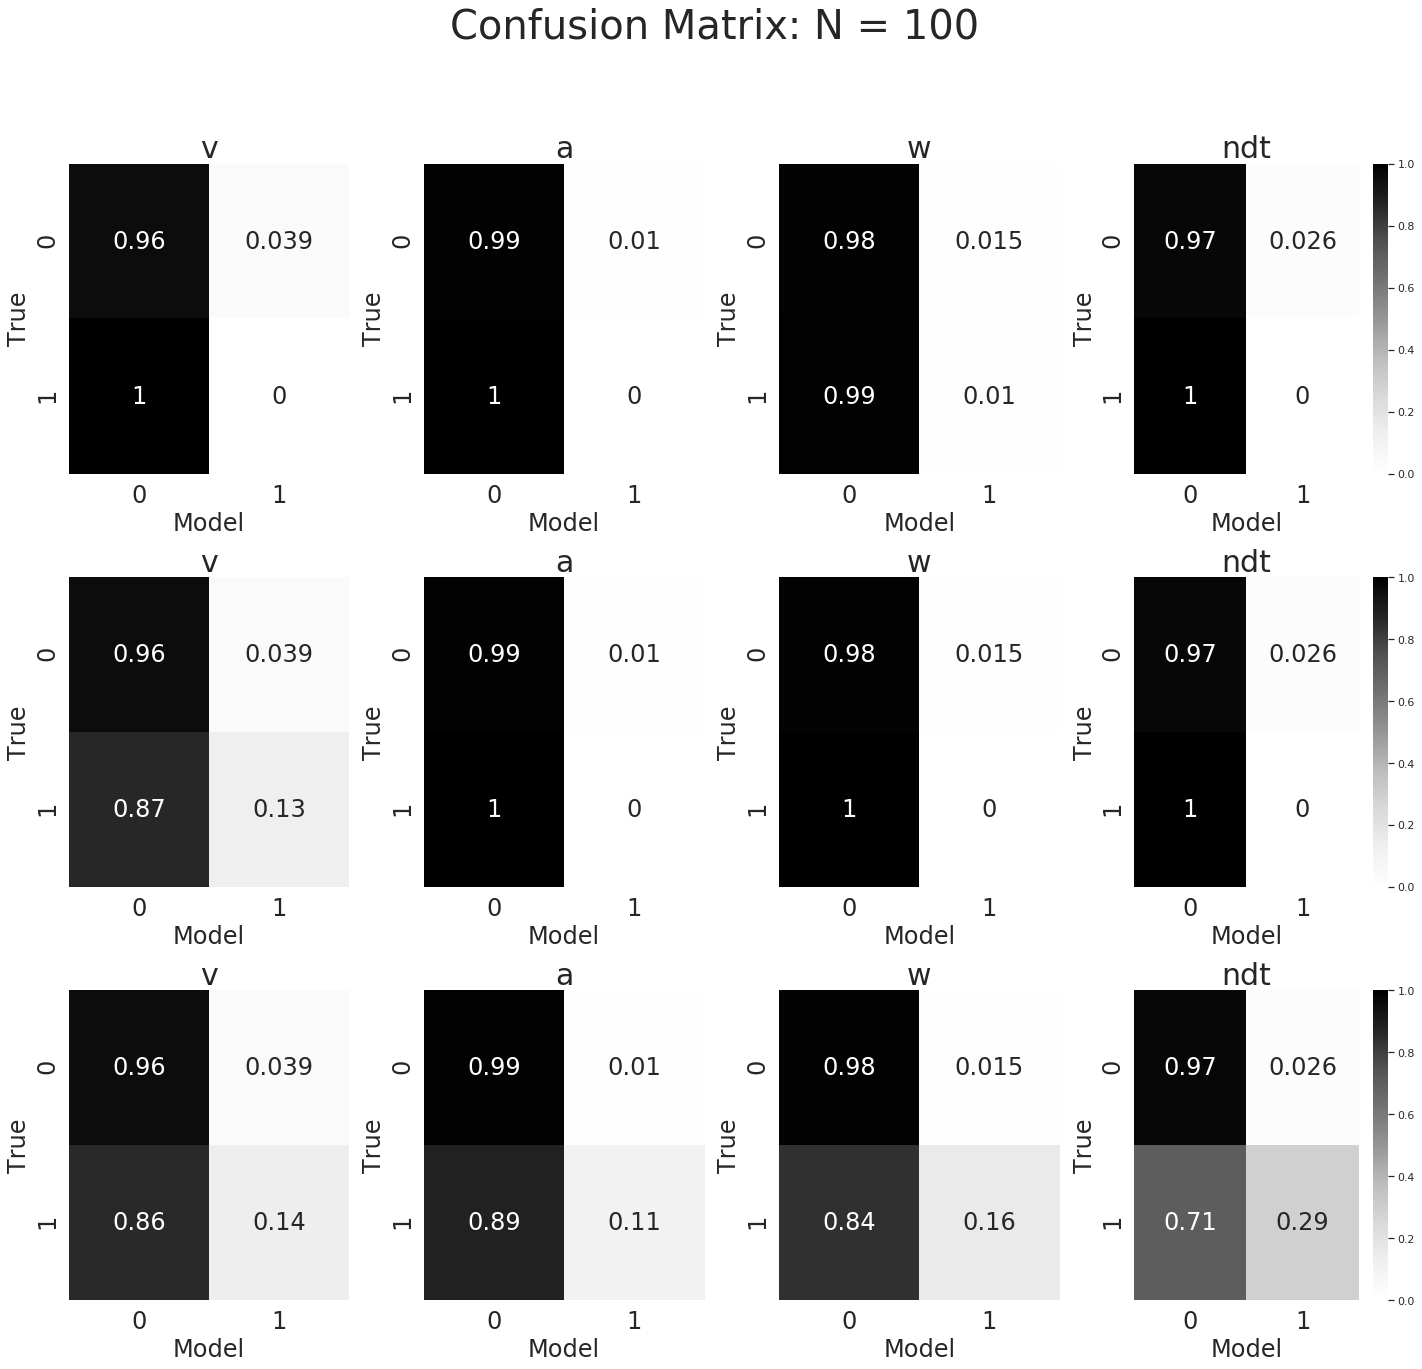

In [315]:
# n = 100
id = 0
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = ' + str(sample_sizes[id]),
                       data = out_fcn[id],
                       n_perturb = 3)

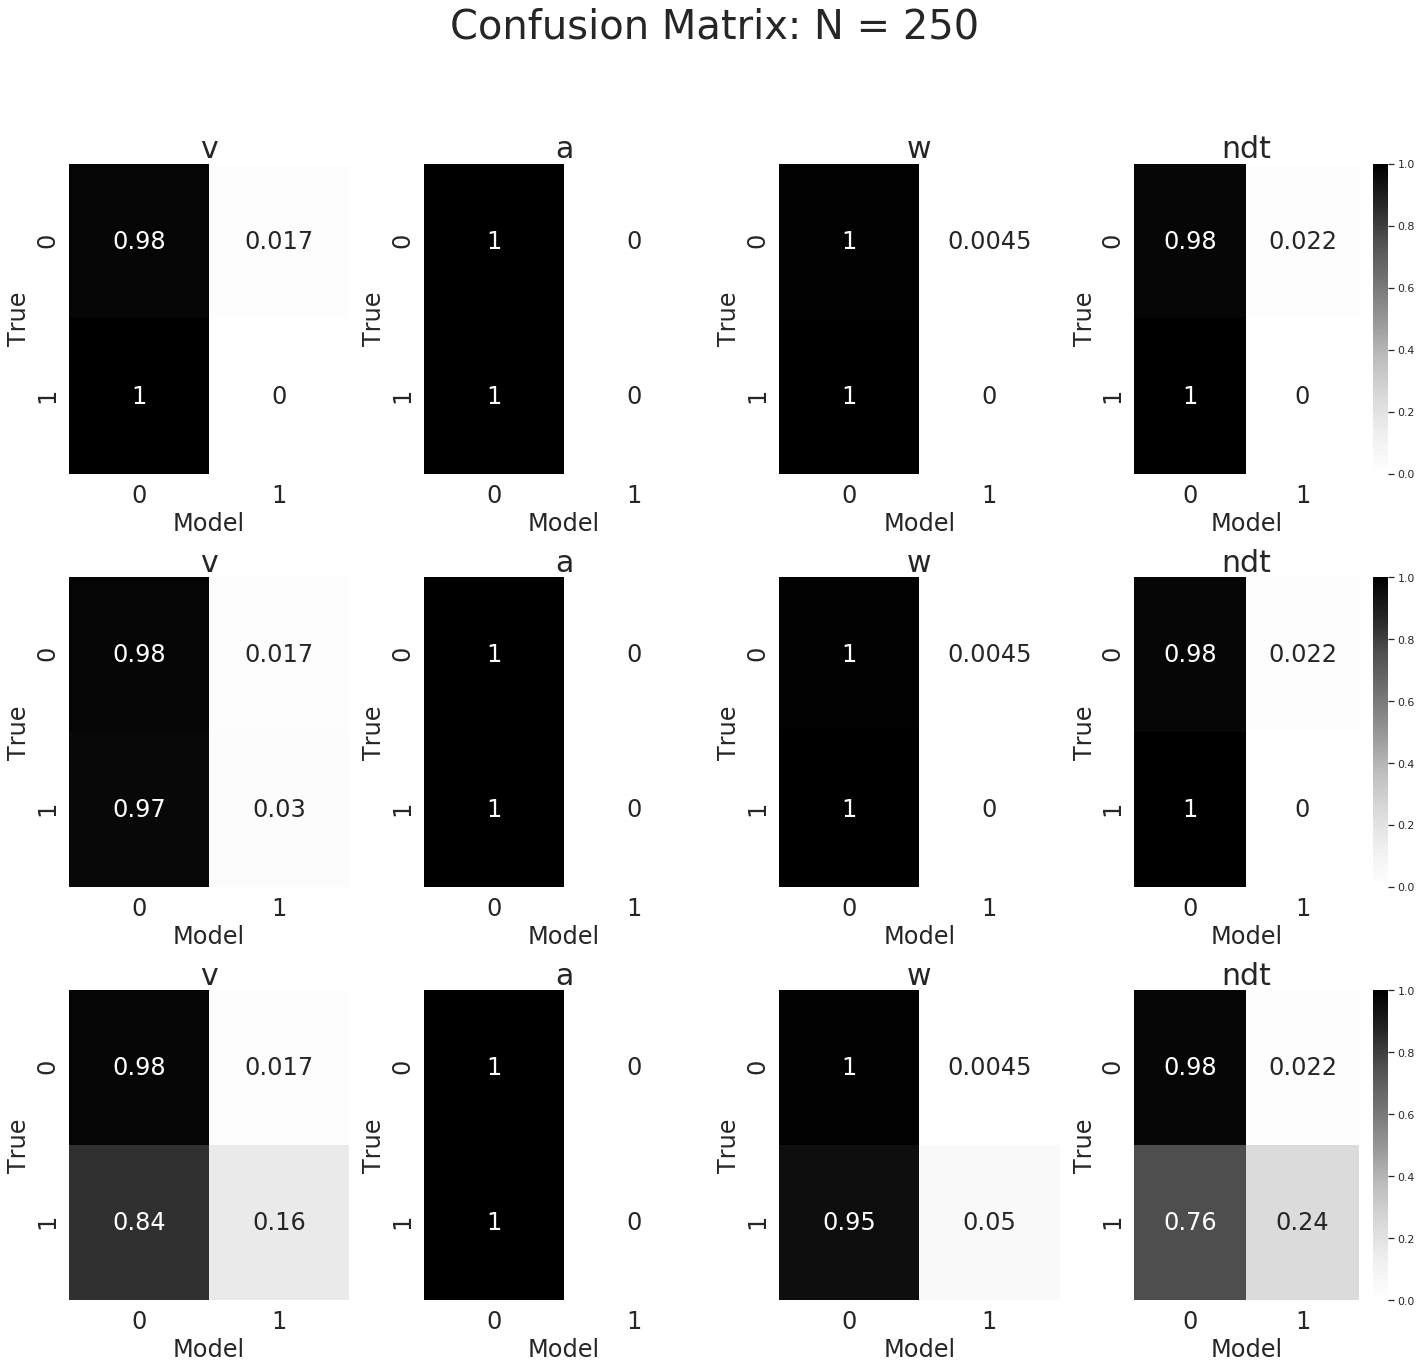

In [316]:
# n = 250
id = 1
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = ' + str(sample_sizes[id]),
                       data = out_fcn[id],
                       n_perturb = 3)

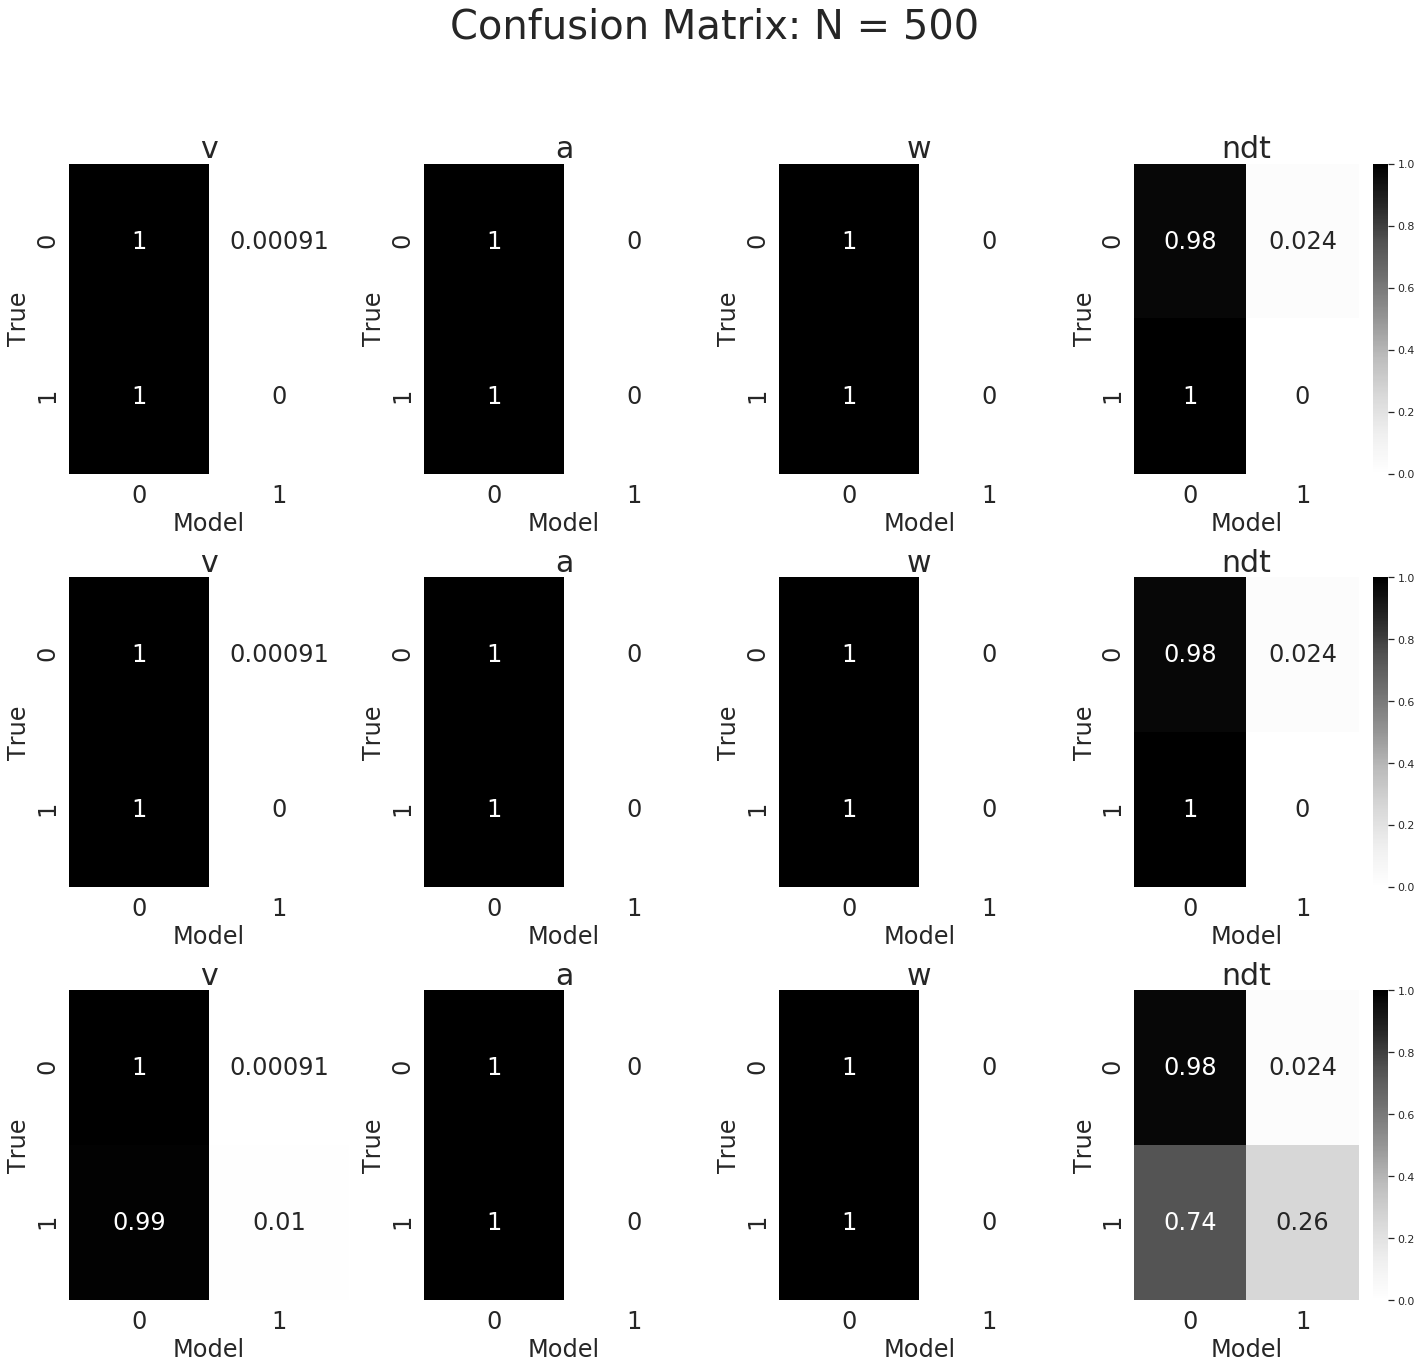

In [317]:
# n = 500
id = 2
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = ' + str(sample_sizes[id]),
                       data = out_fcn[id],
                       n_perturb = 3)

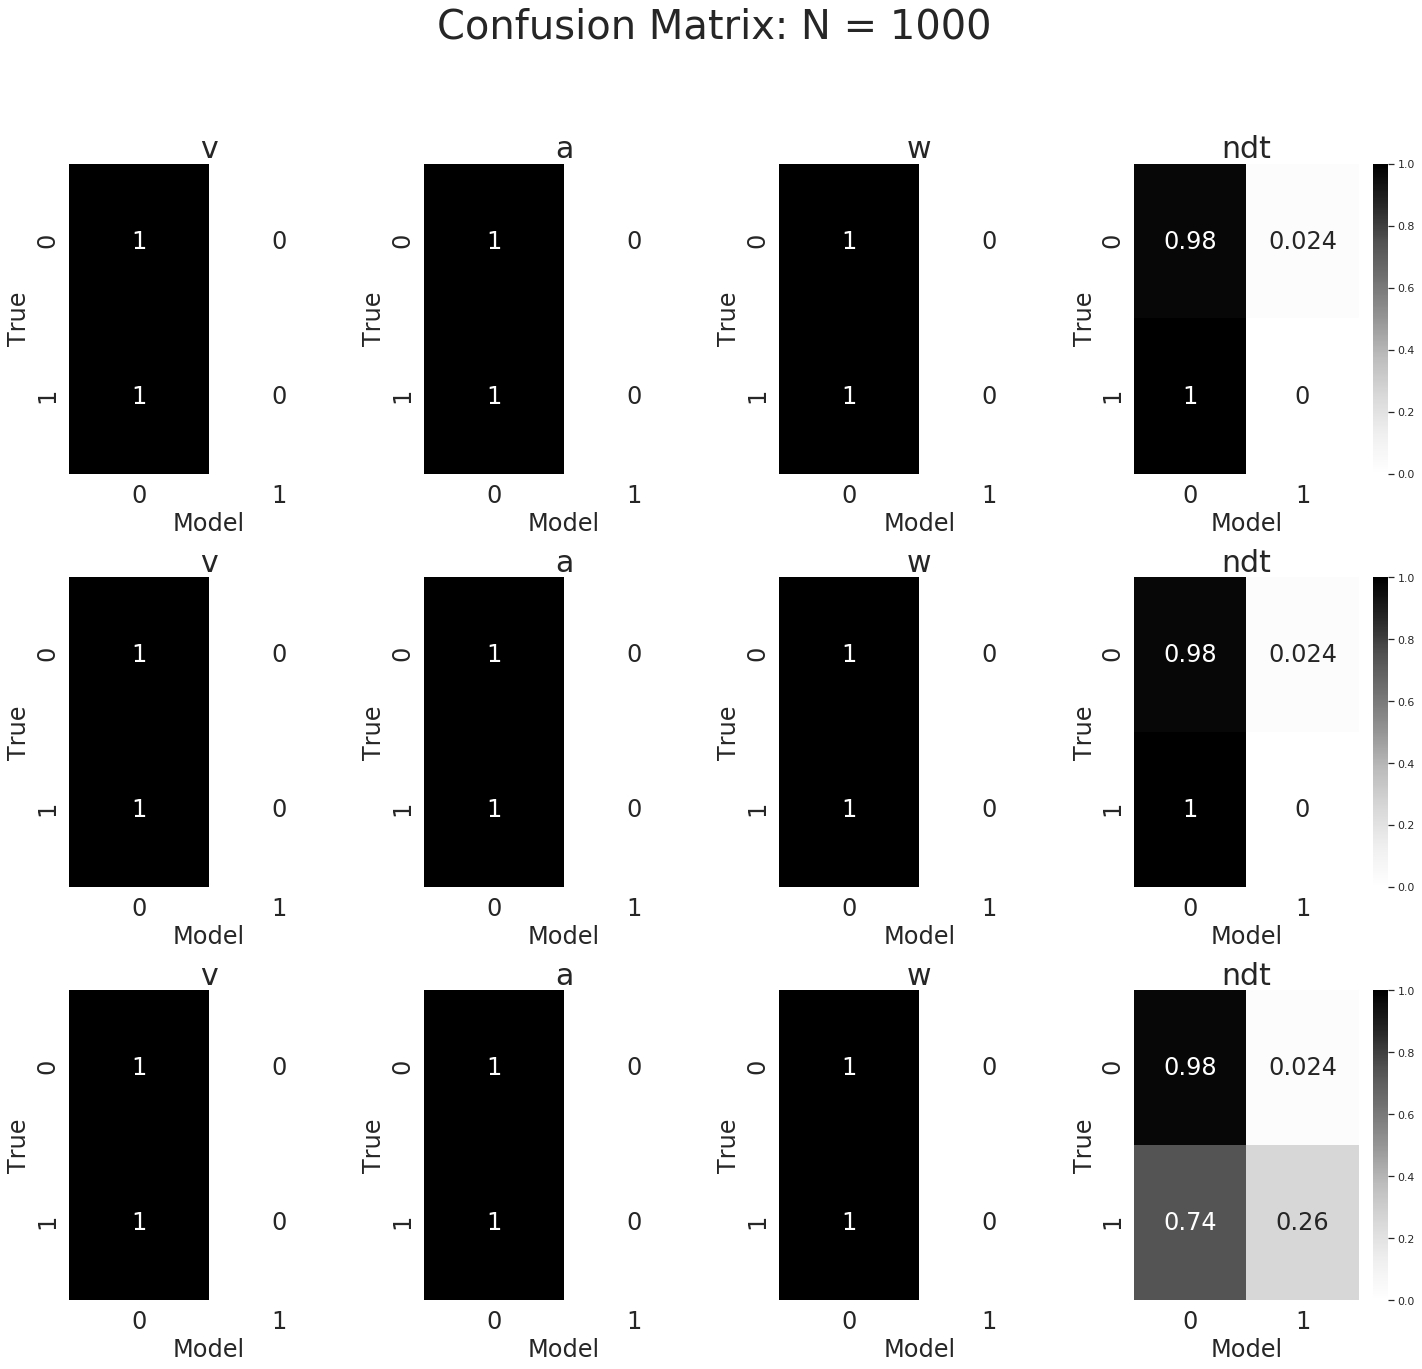

In [318]:
# n = 1000
id = 3
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = ' + str(sample_sizes[id]),
                       data = out_fcn[id],
                       n_perturb = 3)

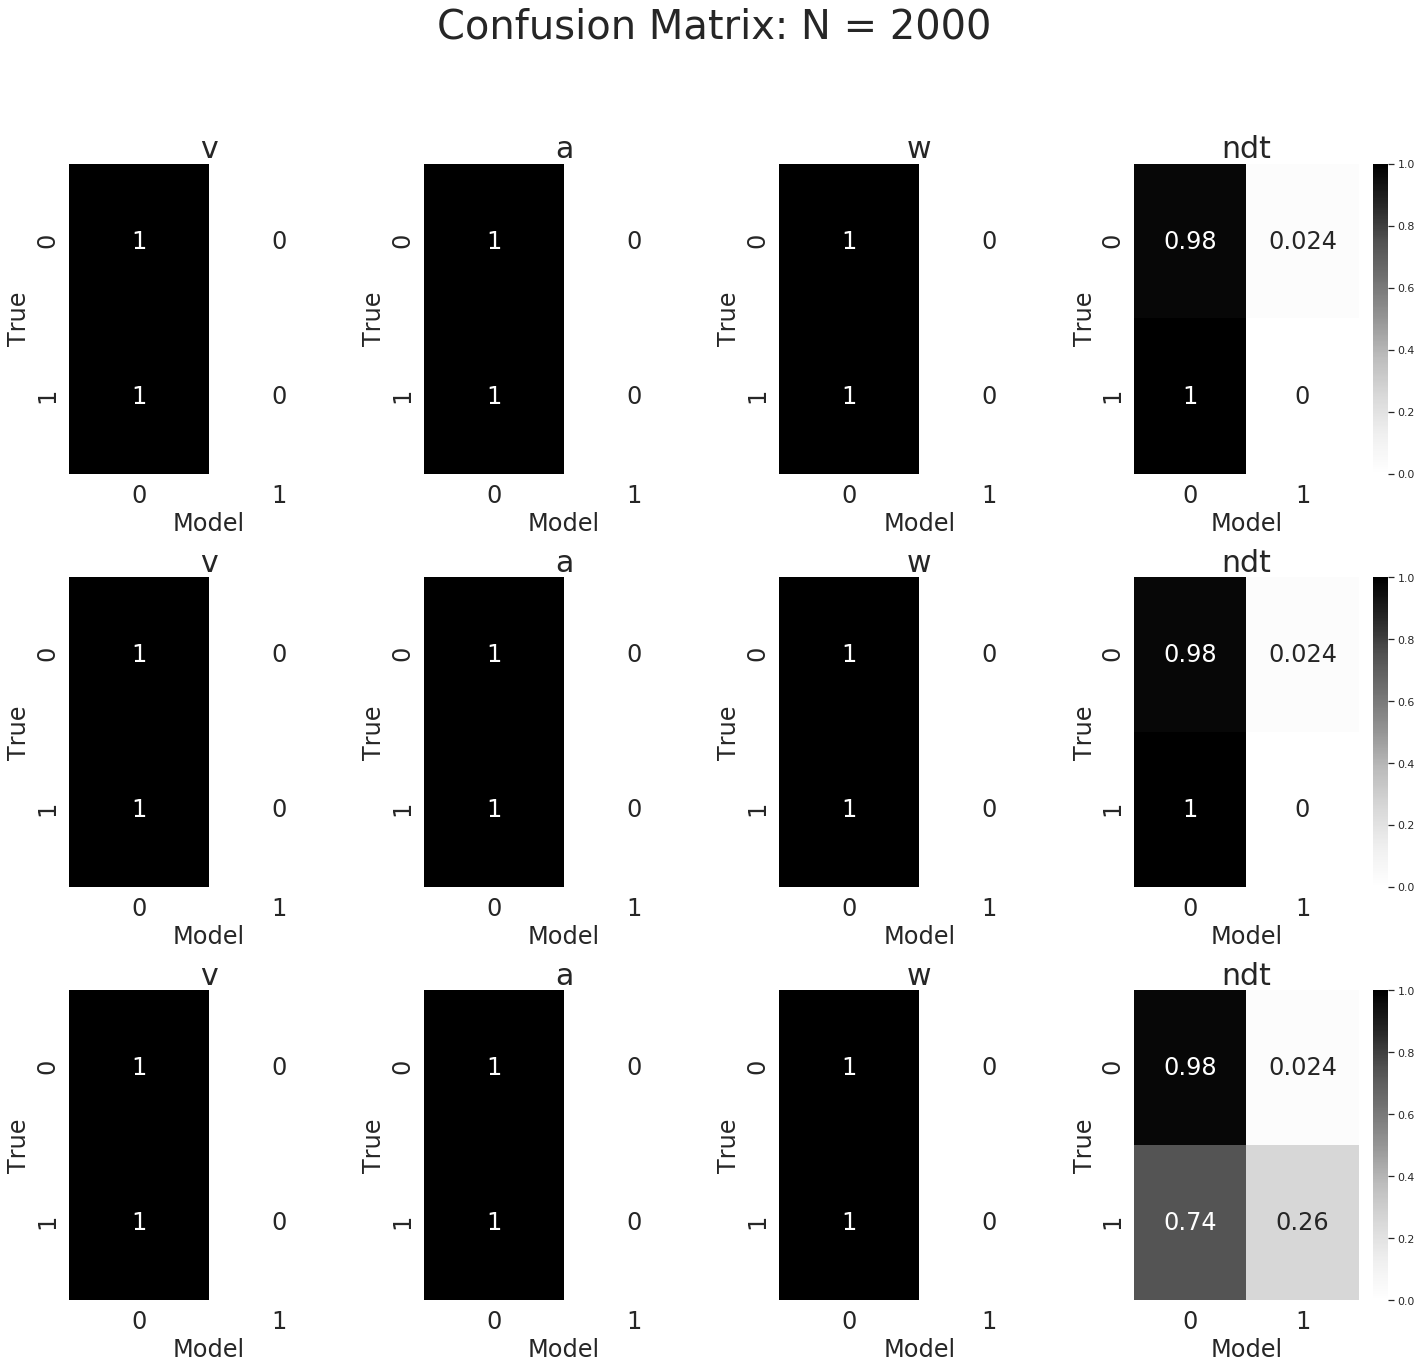

In [319]:
# n = 2000
id = 4
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = ' + str(sample_sizes[id]),
                       data = out_fcn[id],
                       n_perturb = 3)

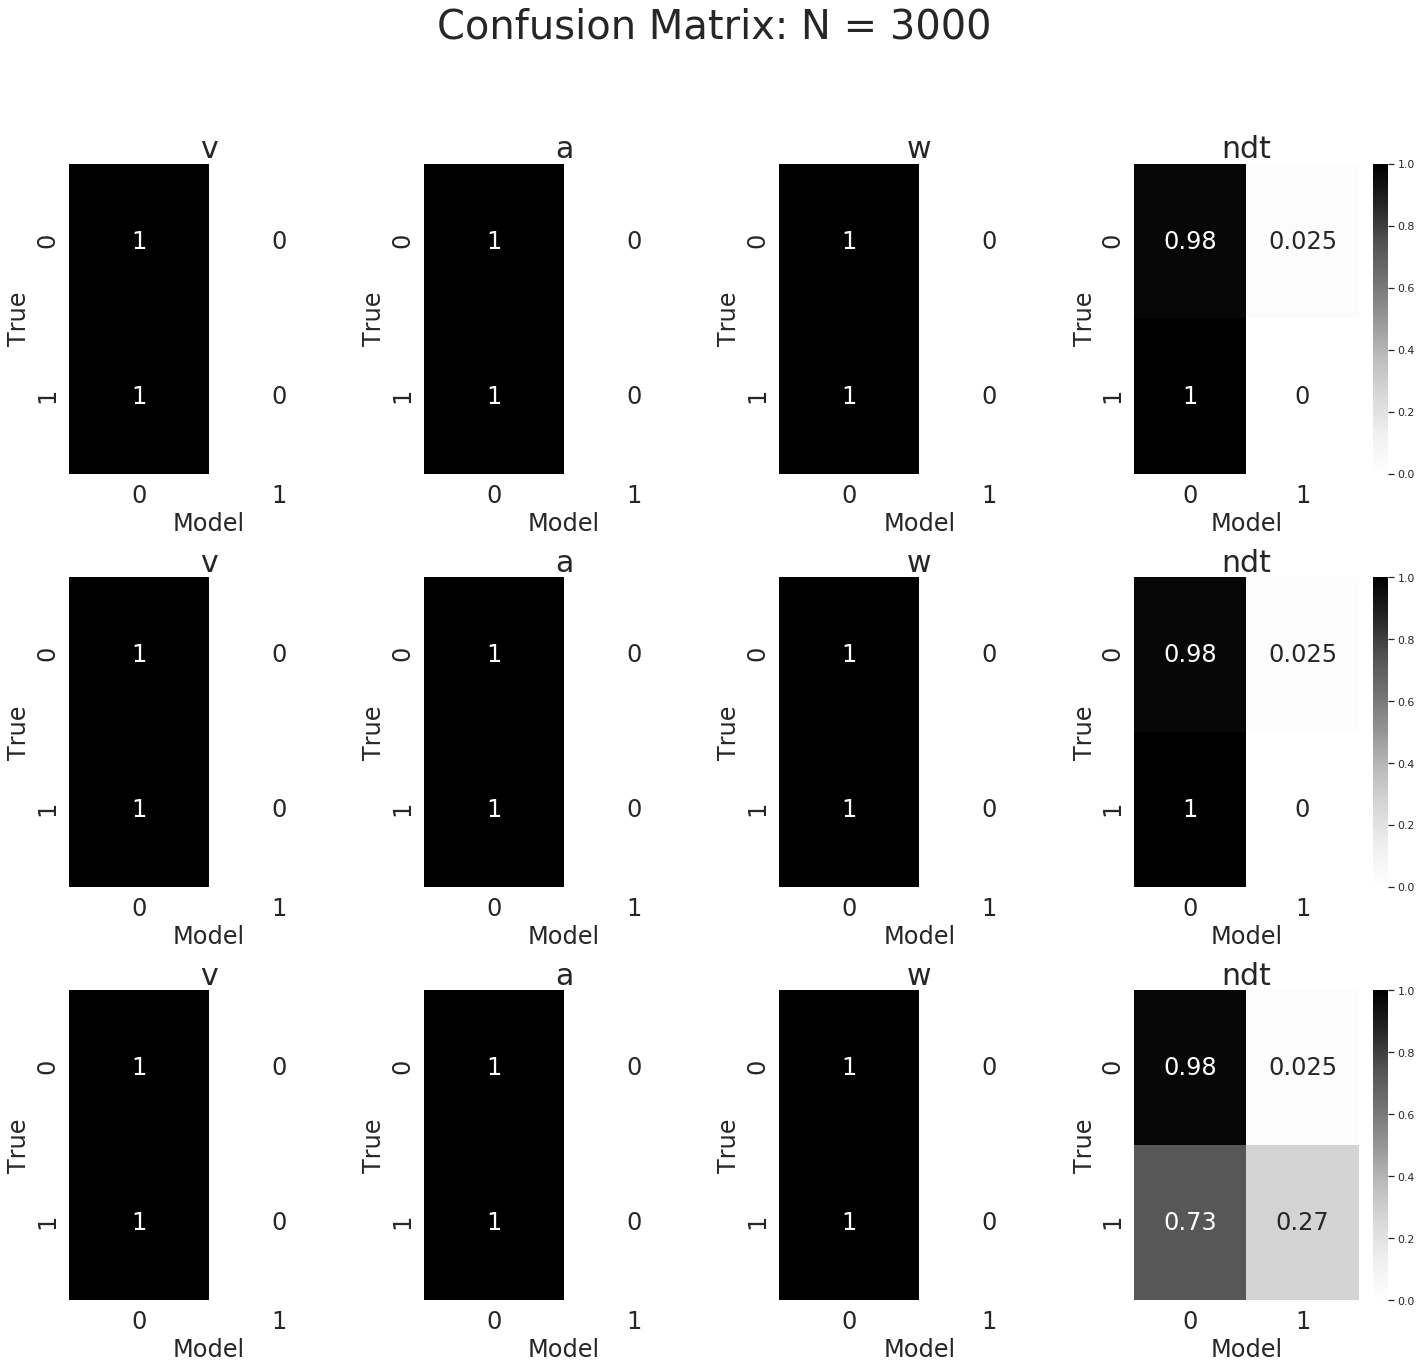

In [320]:
# n = 3000
id = 5
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = ' + str(sample_sizes[id]),
                       data = out_fcn[id],
                       n_perturb = 3)

In [ ]:
# def get_detection_ratios(t_test_results = [0]):
#     n_params = len(np.unique(t_test_results[:, -2]))
#     n_perturb = len(np.unique(t_test_results[:, -1]))
#     n_exp_levels = n_params * n_perturb
#     n_exp_by_level = out.shape[0] / n_exp_levels

#     detection_ratios = np.zeros((n_perturb, n_params))

#     for i in range(n_params):
#         for j in range(n_perturb):
#             detection_ratios[j, i] = np.sum(t_test_results[(t_test_results[:, -1] == j) & \
#                                                            (t_test_results[:, -2] == i), i]) / n_exp_by_level
#     return detection_ratios

# # SUPPORT FUNCTIONS GRAPHS
# def detection_rate_plots(ax_titles = ['v', 'a', 'w', 'ndt'], 
#                          title = 'Effect detection: Bayesian T-test',
#                          data = [],
#                          cols = 3):
    
#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = False)
#     fig.suptitle(title, fontsize = 40)

#     sns.despine(right = True)

#     for i in range(len(ax_titles)):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].bar(x = ['0.05', '0.1', '0.2'], height = data[:, i])
#         ax[row_tmp, col_tmp].set_xlabel('Perturbation Levels', 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].set_ylabel('Detection Probability', 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].set_title(ax_titles[i], 
#                                        fontsize = 24);
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)

#     for i in range(len(ax_titles), rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     plt.setp(ax, yticks = [])
#     return plt.show()